<a href="https://colab.research.google.com/github/ashishar/q_character/blob/main/Brahmi_post_variational_qnn_and_pauli_observables%20with%20distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install pennylane pennylane-lightning-gpu torch torchvision matplotlib scikit-learn torchvision
# !pip install pytorch-toolbelt kahypar pennylane-qiskit

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Change directory to the desired location where the file is stored.
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [4]:
# prompt: I want to download devanagari character dataset from Kaggle.

#!pip install kaggle
#!mkdir -p ~/.kaggle
#!cp /content/drive/MyDrive/brahmi/kaggle.json ~/.kaggle/kaggle.json
#!kaggle datasets download --force -d gautamneha/brahmi-dataset
!unzip "/content/drive/My Drive/brahmi-dataset.zip" -d "/content/data"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/test/117/26.jpg  
  inflating: /content/data/test/117/27.jpg  
  inflating: /content/data/test/117/28.jpg  
  inflating: /content/data/test/117/29.jpg  
  inflating: /content/data/test/117/30.jpg  
  inflating: /content/data/test/118/26.jpg  
  inflating: /content/data/test/118/27.jpg  
  inflating: /content/data/test/118/28.jpg  
  inflating: /content/data/test/118/29.jpg  
  inflating: /content/data/test/118/30.jpg  
  inflating: /content/data/test/119/26.jpg  
  inflating: /content/data/test/119/27.jpg  
  inflating: /content/data/test/119/28.jpg  
  inflating: /content/data/test/119/29.jpg  
  inflating: /content/data/test/119/30.jpg  
  inflating: /content/data/test/12/1.jpg  
  inflating: /content/data/test/12/11.jpg  
  inflating: /content/data/test/12/15.jpg  
  inflating: /content/data/test/12/18.jpg  
  inflating: /content/data/test/12/22.jpg  
  inflating: /content/data/test/120/26.jpg  
  inflatin

In [36]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset

from torchvision import transforms
from skimage.morphology import skeletonize
from sklearn.preprocessing import binarize
from skimage import exposure
from skimage import io, transform
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler


def seam_carving(image, output_shape):
    """Apply seam carving to resize the image to the specified output shape."""
    image_np = image.numpy().squeeze()  # Convert to numpy and remove the channel dimension
    carved_image = resize(image_np, output_shape, anti_aliasing=True, mode='reflect')
    return torch.tensor(carved_image).unsqueeze(0)  # Convert back to tensor and add channel dimension


def binarize_image(image, threshold):
    return (image > threshold).float()

# Custom function to skeletonize the image
def skeletonize_image(image):
    image_np = image.numpy()  # Convert to NumPy array and remove channel dimension
    skeleton = skeletonize(image_np)  # Skeletonize the image
    return torch.tensor(skeleton).unsqueeze(0)  # Convert back to tensor and add channel dimension

# Custom function to flatten and normalize the image
def flatten_and_normalize(img):

    img = img.view(-1)  # Flatten the image
    img = img[:127]  # Use only the first 127 pixels
    #norm = img.norm(p=1)  # Calculate the L2 norm
    #img = img / norm  # Normalize the image
        # Normalize data to the range [0, π]

    return img

# Custom function for histogram normalization
def histogram_normalize(img):
    img_np = img.squeeze().numpy()  # Convert to NumPy array and remove channel dimension
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    img = scaler.fit_transform(img)
    img_eq = img# exposure.equalize_hist(img_np)  # Apply histogram normalization
    return torch.tensor(img_eq).unsqueeze(0)  # Convert back to tensor and add channel dimension


image_size= 10
# Define the transform to resize, inspect size, flatten, and normalize the images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((image_size, image_size)),  # Resize all images to 28x28 pixels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Lambda(lambda x: seam_carving(x, (image_size, image_size))),  # Resize using seam carving
#    transforms.Lambda(lambda x: binarize_image(x, threshold=0.5)),  # Binarize the image
#    transforms.Lambda(skeletonize_image),  # Skeletonize the image
#    transforms.Lambda(lambda x: print(f"Image shape before flattening: {x.shape}") or x),  # Inspect size
    transforms.Lambda(flatten_and_normalize)  # Flatten and normalize
])

# Load the datasets with the defined transformation
train_dataset_all = datasets.ImageFolder(root='/content/data/train', transform=transform)
test_dataset_all = datasets.ImageFolder(root='/content/data/test', transform=transform)

batch_size=32
# Create DataLoaders
train_loader = DataLoader(train_dataset_all, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_all, batch_size=batch_size, shuffle=False)

In [26]:
for batch in train_loader:
    print(f"Type of batch: {type(batch)}")
    print(f"Length of batch: {len(batch)}")
    if isinstance(batch, (list, tuple)):
        print(f"Batch contains {len(batch)} elements.")
        for idx, item in enumerate(batch):
            print(f"Batch element {idx} type: {type(item)}")
            if isinstance(item, torch.Tensor):
                print(f"Batch element {idx} shape: {item.shape}")
            else:
                print(f"Batch element {idx} content: {item}")
    else:
        print("Batch is not a tuple or list.")
    break  # Only inspect the first batch


Type of batch: <class 'list'>
Length of batch: 2
Batch contains 2 elements.
Batch element 0 type: <class 'torch.Tensor'>
Batch element 0 shape: torch.Size([32, 100])
Batch element 1 type: <class 'torch.Tensor'>
Batch element 1 shape: torch.Size([32])


In [27]:
for images, targets in test_loader:
    print("Flattened and Normalized Images shape:", images.shape)
    print("Targets shape:", targets.shape)
    break  # Only need to check the first batch

Flattened and Normalized Images shape: torch.Size([32, 100])
Targets shape: torch.Size([32])


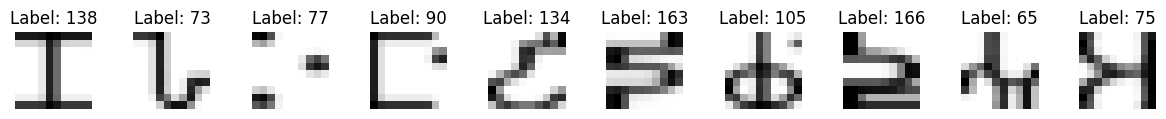

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Load a batch of images from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use the built-in next() function

# Reshape the flattened images back to 28x28
images = images.view(-1, image_size, image_size)

# Plot a few images from the batch
fig, axes = plt.subplots(1, 10, figsize=(15,1))
for i in range(10):
    img = images[i] / 2 + 0.5  # Unnormalize if the images were normalized
    ax = axes[i]
    ax.imshow(img.numpy(), cmap='gray')  # Plot in grayscale
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')

plt.show()


In [29]:
# dev = qml.device('default.qubit', wires=3)

# @qml.qnode(dev)
# def circuit(state):
#     qml.MottonenStatePreparation(state_vector=state, wires=range(3))
#     return qml.state()

# state = np.array([1, 2j, 3, 4j, 5, 6j, 7, 9j])
# state = state / np.linalg.norm(state)

# qml.draw_mpl(circuit, expansion_strategy="device", max_length=80)(state)

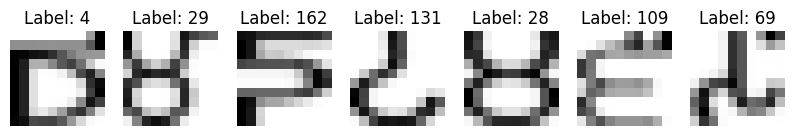

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Load a batch of images from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use the built-in next() function

# Reshape the flattened images back to 28x28
images = images.view(-1, image_size, image_size)

# Plot a few images from the batch
fig, axes = plt.subplots(1, 7, figsize=(10, 6))
for i in range(7):
    img = images[i] / 2 + 0.5  # Unnormalize if the images were normalized
    ax = axes[i]
    ax.imshow(img.numpy(), cmap='gray')  # Plot in grayscale
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')

plt.show()


In [31]:
import numpy as np

# Extract all labels from the dataset
all_labels = [label for _, label in train_dataset_all]

# Get the unique labels using numpy
unique_labels = np.unique(all_labels)

# Count the number of unique labels
num_unique_labels = len(unique_labels)

print("Number of unique labels in train_dataset_all:", num_unique_labels)
#print("Unique labels:", unique_labels)


Number of unique labels in train_dataset_all: 170


0


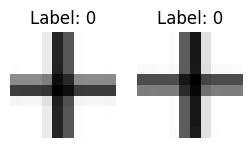

In [32]:
import matplotlib.pyplot as plt
import torch

def plot_images_of_same_label(train_loader, target_label, num_images=5):
    images_of_label = []

    # Loop through the train_loader to find images with the desired label
    for images, labels in train_loader:
        for i in range(len(labels)):
            if labels[i] == target_label:
                images_of_label.append(images[i])
            if len(images_of_label) == num_images:
                break
        if len(images_of_label) == num_images:
            break

    if len(images_of_label) == 0:
        print(f"No images found with label {target_label}")
        return

    # Reshape images if necessary (e.g., from 784 to 28x28)
    images_of_label = torch.stack(images_of_label)
    images_of_label = images_of_label.view(-1, image_size, image_size)

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(3, 3))
    for i in range(num_images):
        img = images_of_label[i] / 2 + 0.5  # Unnormalize if the images were normalized
        ax = axes[i]
        ax.imshow(img.numpy(), cmap='gray')  # Plot in grayscale
        ax.set_title(f'Label: {target_label}')
        ax.axis('off')

    plt.show()

# Example usage:
target_labels = [0]  # Specify the label you want to plot
for target_label in target_labels:
  print(target_label)
  plot_images_of_same_label(train_loader, target_label, num_images=2)


In [49]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import torch
from torchvision import transforms
from sklearn.preprocessing import normalize


n_pixels = image_size * image_size
n_qubits = int(np.ceil(np.log2(n_pixels)))  # Number of qubits required for amplitude encoding

n_layers = 3  # Number of layers in the variational circuit

# Define the device
dev = qml.device("default.qubit", wires=n_qubits)

# Define the feature map (amplitude encoding)
def amplitude_encoding(x):
    """Encode classical data into quantum states using amplitude encoding."""
    qml.AmplitudeEmbedding(features=x, wires=range(n_qubits),pad_with=0, normalize=True)

# Define the variational circuit
def variational_circuit(params):
    """Variational circuit with trainable parameters."""
    for layer in range(n_layers):
        for i in range(n_qubits):
            qml.RX(params[layer, i, 0], wires=i)
            qml.RY(params[layer, i, 1], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

# Define the QNode
@qml.qnode(dev)
def quantum_circuit(x, params):
    """Combines the amplitude encoding and variational circuit."""
    amplitude_encoding(x)
    variational_circuit(params)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Step 3: Training
# Initialize parameters
params = np.random.rand(n_layers, n_qubits, 2)

# Define the loss function
def cross_entropy_loss(predictions, labels):
    """Cross-entropy loss for multi-class classification."""
    predictions = np.clip(predictions, 1e-10, 1 - 1e-10)  # Avoid log(0)
    return -np.sum(labels * np.log(predictions)) / len(labels)

def cost(params, X, Y):
    """Cost function to minimize."""
    predictions = [quantum_circuit(x, params) for x in X]
    return cross_entropy_loss(np.array(predictions), Y)

# Convert labels to one-hot encoding
def to_one_hot(labels, num_classes):
    """Convert labels to one-hot encoding."""
    return np.eye(num_classes)[labels]

# Training loop
num_classes = 170  # Number of classes
batch_size = train_loader.batch_size  # Batch size from the data loader

opt = AdamOptimizer(stepsize=0.1)
steps = 50

for step in range(steps):
    for batch_idx, (train_images, train_labels) in enumerate(train_loader):
        # Preprocess the batch
        X_train = train_images
        y_train = to_one_hot(train_labels.numpy(), num_classes)

        # Update parameters
        params = opt.step(lambda p: cost(p, X_train, y_train), params)

        # Print loss every few steps
        if batch_idx % 10 == 0:
            loss = cost(params, X_train, y_train)
            print(f"Step {step}, Batch {batch_idx}, Loss: {loss:.4f}")

# Step 4: Evaluation
# Test the circuit on the test set
correct = 0
total = 0

for test_images, test_labels in test_loader:
    # Preprocess the batch
    X_test = test_images
    y_test = to_one_hot(test_labels.numpy(), num_classes)

    # Make predictions
    predictions = [quantum_circuit(x, params) for x in X_test]
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    # Calculate accuracy
    correct += np.sum(predicted_labels == true_labels)
    total += len(true_labels)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.6f}")

/usr/local/lib/python3.11/dist-packages/pennylane/math/interface_utils.py:127: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


TypeError: object of type 'numpy.complex128' has no len()

image_size  10


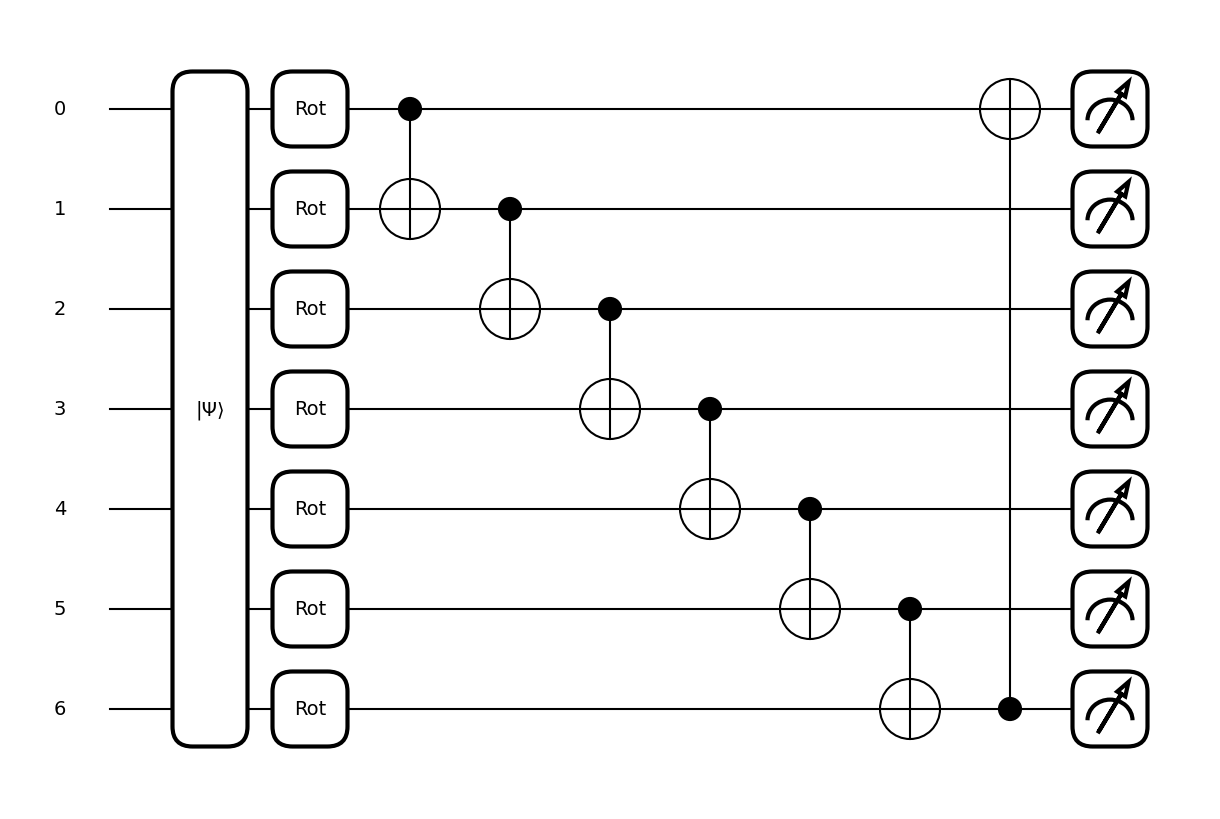

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


No checkpoint found at /content/sample_data/checkpoint.pthqnn.tar. Starting from scratch.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10 - Loss: 5.0257 - Accuracy: 0.0772 - Precision: 0.1819 - Recall: 0.0772 - F1: 0.0714


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy_test-  18.941176470588236 precision_test-  0.11434256729152434 recall_test-  0.18941176470588236 f1 test-  0.1163985804496959
Checkpoint saved at epoch 1.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/10 - Loss: 4.2870 - Accuracy: 0.2715 - Precision: 0.3712 - Recall: 0.2715 - F1: 0.2535


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy_test-  49.05882352941177 precision_test-  0.38948491698798654 recall_test-  0.49058823529411766 f1 test-  0.3929007481311139
Checkpoint saved at epoch 2.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/10 - Loss: 3.0790 - Accuracy: 0.5024 - Precision: 0.5658 - Recall: 0.5024 - F1: 0.4761


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy_test-  63.88235294117647 precision_test-  0.5808251163073515 recall_test-  0.6388235294117647 f1 test-  0.5678058216461969
Checkpoint saved at epoch 3.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/10 - Loss: 2.0542 - Accuracy: 0.6751 - Precision: 0.6910 - Recall: 0.6751 - F1: 0.6571


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy_test-  75.17647058823529 precision_test-  0.7273751669726901 recall_test-  0.7517647058823529 f1 test-  0.708809943066909
Checkpoint saved at epoch 4.
Epoch 5/10 - Loss: 1.4329 - Accuracy: 0.7508 - Precision: 0.7573 - Recall: 0.7508 - F1: 0.7362


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy_test-  77.76470588235294 precision_test-  0.7427965721489116 recall_test-  0.7776470588235294 f1 test-  0.7348635050879633
Checkpoint saved at epoch 5.
Epoch 6/10 - Loss: 1.0794 - Accuracy: 0.7955 - Precision: 0.8073 - Recall: 0.7955 - F1: 0.7876


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy_test-  80.0 precision_test-  0.7891571173924116 recall_test-  0.8 f1 test-  0.767925212042859
Checkpoint saved at epoch 6.
Epoch 7/10 - Loss: 0.8637 - Accuracy: 0.8315 - Precision: 0.8381 - Recall: 0.8315 - F1: 0.8274


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy_test-  82.3529411764706 precision_test-  0.8248789866823921 recall_test-  0.8235294117647058 f1 test-  0.7989542560476818
Checkpoint saved at epoch 7.
Epoch 8/10 - Loss: 0.7209 - Accuracy: 0.8628 - Precision: 0.8691 - Recall: 0.8628 - F1: 0.8591


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy_test-  85.17647058823529 precision_test-  0.8426400560224091 recall_test-  0.8517647058823529 f1 test-  0.8309975834279241
Checkpoint saved at epoch 8.
Epoch 9/10 - Loss: 0.6211 - Accuracy: 0.8791 - Precision: 0.8819 - Recall: 0.8791 - F1: 0.8756


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy_test-  87.17647058823529 precision_test-  0.8717145191409897 recall_test-  0.871764705882353 f1 test-  0.8558500323206205
Checkpoint saved at epoch 9.
Epoch 10/10 - Loss: 0.5439 - Accuracy: 0.8965 - Precision: 0.9020 - Recall: 0.8965 - F1: 0.8948


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy_test-  88.23529411764706 precision_test-  0.8968893726419678 recall_test-  0.8823529411764706 f1 test-  0.8730945064163057
Checkpoint saved at epoch 10.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [56]:
  # Step 1: Install Required Packages
  #!pip install pennylane pennylane-lightning-gpu torch torchvision matplotlib scikit-learn

  import pennylane as qml
  from pennylane import numpy as np
  import torch
  from torchvision import datasets, transforms
  from torch.utils.data import DataLoader, Dataset, random_split
  from torch import nn, optim
  import matplotlib.pyplot as plt
  from sklearn.metrics import precision_score, recall_score, f1_score


  # Step 3: Set Up the Quantum Device with lightning.qubit and GPU
  print("image_size ", image_size)
  n_pixels = image_size * image_size  # Total number of pixels in the image (784 for 28x28)
  n_qubits = int(np.ceil(np.log2(n_pixels)))  # Number of qubits needed for amplitude encoding
  L = 1  # Number of repetitions of the quantum layer

  # Use lightning.qubit device with GPU support
  dev = qml.device("lightning.qubit", wires=n_qubits)

  def quantum_layer(weights):
      for l in range(L):
          for i in range(n_qubits):
              qml.Rot(weights[l, i, 0], weights[l, i, 1], weights[l, i, 2], wires=i)  # Trainable rotation gates
          # Add entanglement between qubits (e.g., CNOT, CZ, or any other entangling gate)
          for i in range(n_qubits - 1):
              qml.CNOT(wires=[i, i + 1])
      # For a ring entanglement
      qml.CNOT(wires=[n_qubits - 1, 0])

  @qml.qnode(dev, interface="torch")
  def quantum_circuit(inputs, weights):
      # Amplitude encoding: encodes the normalized pixel values into quantum amplitudes
      qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), pad_with=0.0, normalize=True)
      quantum_layer(weights)
      # Return the full statevector
      return qml.state()

  # Example input for drawing the circuit (dummy input)
  example_input = np.random.rand(n_pixels).astype(np.float32)
  example_weights = np.random.rand(L, n_qubits, 3).astype(np.float32)  # Randomly initialized weights

  # Draw the circuit using Matplotlib (optional)
  qml.draw_mpl(quantum_circuit)(example_input, example_weights)
  plt.show()

  # Step 4: Define the Hybrid Quantum-Classical Model
  class HybridModel(nn.Module):
      def __init__(self):
          super(HybridModel, self).__init__()
          self.q_weights = nn.Parameter(0.01 * torch.randn(L, n_qubits, 3, dtype=torch.float32))  # Trainable quantum weights
          self.fc1 = nn.Linear(2**n_qubits, 256)  # First classical layer (increased size)
          self.fc2 = nn.Linear(256, 170)           # Output layer for 170 classes

      def forward(self, x):
          q_out = []
          for i in range(x.size(0)):
              q_result = quantum_circuit(x[i], self.q_weights)
              q_result = q_result.clone().detach().to(torch.float32).to(x.device)  # Safely clone and move to GPU
              q_out.append(q_result)
          q_out = torch.stack(q_out)  # Shape: [batch_size, 2^n_qubits]
          # Pass through classical layers
          x = self.fc1(q_out)
          #x = nn.functional.relu(x)
          x = self.fc2(x)
          return x

  # Step 5: Move Model to GPU
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = HybridModel().to(device)

  # Step 7: Evaluate the Model on GPU and Calculate Metrics
  def test_model(model, test_loader):
      model.eval()
      correct = 0
      total = 0
      all_targets = []
      all_preds = []

      with torch.no_grad():
          for data, targets in test_loader:
              data = data.float().to(device)  # Ensure data is a float tensor and move to GPU
              targets = targets.long().to(device)  # Move targets to GPU
              output = model(data)
              _, predicted = torch.max(output.data, 1)
              total += targets.size(0)
              correct += (predicted == targets).sum().item()
              all_targets.extend(targets.cpu().numpy())
              all_preds.extend(predicted.cpu().numpy())

      accuracy = 100 * correct / total
      precision = precision_score(all_targets, all_preds, average='macro')
      recall = recall_score(all_targets, all_preds, average='macro')
      f1 = f1_score(all_targets, all_preds, average='macro')

      # print(f'Accuracy: {accuracy}%')
      # print(f'Precision: {precision:.4f}')
      # print(f'Recall: {recall:.4f}')
      # print(f'F1 Score: {f1:.4f}')
      return accuracy, precision, recall, f1

  # Step 6: Train the Model on GPU and Track Metrics
  def train_model(model, train_loader, criterion, optimizer, epochs=5, start_epoch=0):

  #def train_model(model, train_loader, criterion, optimizer, epochs=5):
      model.train()
      history = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

      for epoch in range(epochs):
          total_loss = 0
          all_targets = []
          all_preds = []

          for data, targets in train_loader:
              data = data.float().to(device)  # Ensure data is a float tensor and move to GPU
              targets = targets.long().to(device)  # Ensure targets are long tensors and move to GPU
              optimizer.zero_grad()
              output = model(data)
              loss = criterion(output, targets)
              loss.backward()
              optimizer.step()

              total_loss += loss.item()
              _, preds = torch.max(output, 1)
              all_targets.extend(targets.cpu().numpy())
              all_preds.extend(preds.cpu().numpy())

          # Calculate metrics
          precision = precision_score(all_targets, all_preds, average='macro')
          recall = recall_score(all_targets, all_preds, average='macro')
          f1 = f1_score(all_targets, all_preds, average='macro')
          accuracy = (np.array(all_preds) == np.array(all_targets)).mean()

          avg_loss = total_loss / len(train_loader)
          history['loss'].append(avg_loss)
          history['accuracy'].append(accuracy)
          history['precision'].append(precision)
          history['recall'].append(recall)
          history['f1'].append(f1)

          print(f'Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')

          accuracy_test, precision_test, recall_test, f1_test = test_model(model, test_loader)
          print("accuracy_test- ",accuracy_test, "precision_test- ", precision_test, "recall_test- ",recall_test, "f1 test- ",f1_test)
          # Save the model after every epoch
          save_checkpoint(epoch + 1, model, optimizer)

          # Step the scheduler
          scheduler.step(avg_loss)
      return history

  # # Initialize the criterion and optimizer
  # criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
  # optimizer = optim.Adam(model.parameters(), lr=0.001)

  # # Train the model
  # history = train_model(model, train_loader, criterion, optimizer, epochs=50)

  # Initialize the criterion and optimizer
  from pytorch_toolbelt.losses import CrossEntropyFocalLoss
  from torch.optim.lr_scheduler import ReduceLROnPlateau
  import os

  # Define a function to save the model
  def save_checkpoint(epoch, model, optimizer, filename="/content/sample_data/checkpoint.pthqnn.tar"):
      checkpoint = {
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
      }
      torch.save(checkpoint, filename)
      #files.download(filename)
      print(f"Checkpoint saved at epoch {epoch}.")

  # Define a function to load the model
  def load_checkpoint(model, optimizer, filename="/content/sample_data/checkpoint.pthqnn.tar"):
      if os.path.isfile(filename):
          checkpoint = torch.load(filename)
          model.load_state_dict(checkpoint['model_state_dict'])
          optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
          scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
          start_epoch = checkpoint['epoch']
          print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}.")
      else:
          print(f"No checkpoint found at {filename}. Starting from scratch.")
          start_epoch = 0
      return start_epoch



  criterion = nn.CrossEntropyLoss()#gamma=2.0, reduction='mean')
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  # Implement learning rate scheduler
  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

  # Load the checkpoint if it exists
  start_epoch = load_checkpoint(model, optimizer)


  # Train the model
  #history2 = train_model(model, train_loader, criterion, optimizer, scheduler, epochs=21)
  history = train_model(model, train_loader, criterion, optimizer,epochs=10, start_epoch=start_epoch)

  accuracy, precision, recall, f1 = test_model(model, test_loader)




In [57]:
# Student model parameters
n_qubits_student = n_qubits // 2  # Half the number of qubits used in the teacher model
L_student = 1  # Fewer layers than the teacher model

# Define the student quantum circuit
def student_quantum_layer(weights):
    for l in range(L_student):
        for i in range(n_qubits_student):
            qml.Rot(weights[l, i, 0], weights[l, i, 1], weights[l, i, 2], wires=i)  # Trainable rotations
        # Add entanglement between qubits
        for i in range(n_qubits_student - 1):
            qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev, interface="torch")
def student_quantum_circuit(inputs, weights):
    # Use amplitude encoding for the student model as well
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits_student), pad_with=0.0, normalize=True)
    student_quantum_layer(weights)
    # Return the full statevector
    return qml.state()



In [58]:
class StudentHybridModel(nn.Module):
    def __init__(self):
        super(StudentHybridModel, self).__init__()
        # Quantum part
        self.q_weights = nn.Parameter(0.01 * torch.randn(L_student, n_qubits_student, 3, dtype=torch.float32))  # Trainable quantum weights
        # Classical part
        self.fc1 = nn.Linear(2**n_qubits_student, 128)  # Smaller classical layer
        self.fc2 = nn.Linear(128, 170)  # Output layer for 170 classes

    def forward(self, x):
        q_out = []
        for i in range(x.size(0)):
            q_result = student_quantum_circuit(x[i], self.q_weights)
            q_result = q_result.clone().detach().to(torch.float32).to(x.device)  # Safely clone and move to GPU
            q_out.append(q_result)
        q_out = torch.stack(q_out)  # Shape: [batch_size, 2^n_qubits_student]
        # Pass through classical layers
        x = self.fc1(q_out)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

In [66]:
from sklearn.decomposition import PCA

# Define the number of components for PCA
n_components = 2**n_qubits_student  # Match the number of qubits in the student model

# Initialize PCA
pca = PCA(n_components=n_components)

# Fit PCA on the training data
train_data = torch.cat([data for data, _ in train_loader], dim=0).numpy()
pca.fit(train_data)

# Function to preprocess data using PCA
def preprocess_with_pca(data):
    data = data.numpy()  # Convert to NumPy array
    data = pca.transform(data)  # Apply PCA
    return torch.tensor(data, dtype=torch.float32)  # Convert back to tensor

In [68]:
def train_student_with_distillation(teacher_model, student_model, train_loader, optimizer, epochs=10):
    student_model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, targets in train_loader:
            # Preprocess data using PCA
            data = preprocess_with_pca(data).to(device)
            targets = targets.long().to(device)

            # Forward pass through the teacher model
            with torch.no_grad():
                teacher_outputs = teacher_model(data)
                teacher_probs = nn.functional.softmax(teacher_outputs / temperature, dim=1)

            # Forward pass through the student model
            student_outputs = student_model(data)
            student_probs = nn.functional.log_softmax(student_outputs / temperature, dim=1)

            # Calculate losses
            loss_soft = criterion_soft(student_probs, teacher_probs)  # Soft label loss
            loss_hard = criterion_hard(student_outputs, targets)  # Hard label loss
            loss = 0.7 * loss_soft + 0.3 * loss_hard  # Weighted combination of losses

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}')

In [70]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score
from torchvision import transforms

# Step 1: Set Up Quantum Device
n_qubits_student = 3  # Number of qubits for the student model (can encode 8 amplitudes)
L_student = 1  # Number of layers in the student quantum circuit
dev = qml.device("default.qubit", wires=n_qubits_student)

# Step 2: Define the Student Quantum Circuit
def student_quantum_layer(weights):
    for l in range(L_student):
        for i in range(n_qubits_student):
            qml.Rot(weights[l, i, 0], weights[l, i, 1], weights[l, i, 2], wires=i)  # Trainable rotations
        # Add entanglement between qubits
        for i in range(n_qubits_student - 1):
            qml.CNOT(wires=[i, i + 1])

@qml.qnode(dev, interface="torch")
def student_quantum_circuit(inputs, weights):
    # Use amplitude encoding for the student model
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits_student), pad_with=0.0, normalize=True)
    student_quantum_layer(weights)
    # Return the full statevector
    return qml.state()

# Step 3: Define the Student Hybrid Model
class StudentHybridModel(nn.Module):
    def __init__(self):
        super(StudentHybridModel, self).__init__()
        # Quantum part
        self.q_weights = nn.Parameter(0.01 * torch.randn(L_student, n_qubits_student, 3, dtype=torch.float32))  # Trainable quantum weights
        # Classical part
        self.fc1 = nn.Linear(2**n_qubits_student, 128)  # Smaller classical layer
        self.fc2 = nn.Linear(128, 170)  # Output layer for 170 classes

    def forward(self, x):
        q_out = []
        for i in range(x.size(0)):
            q_result = student_quantum_circuit(x[i], self.q_weights)
            q_result = q_result.clone().detach().to(torch.float32).to(x.device)  # Safely clone and move to GPU
            q_out.append(q_result)
        q_out = torch.stack(q_out)  # Shape: [batch_size, 2^n_qubits_student]
        # Pass through classical layers
        x = self.fc1(q_out)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

# Step 4: Load the Teacher Model
teacher_model = HybridModel().to(device)
checkpoint = torch.load("/content/sample_data/checkpoint.pthqnn.tar")
teacher_model.load_state_dict(checkpoint['model_state_dict'])
teacher_model.eval()

# Step 5: Define the Student Model
student_model = StudentHybridModel().to(device)

# Step 6: Preprocess Data Using PCA
n_components = 2**n_qubits_student  # Match the number of qubits in the student model
pca = PCA(n_components=n_components)

# Fit PCA on the training data
train_data = torch.cat([data for data, _ in train_loader], dim=0).numpy()
pca.fit(train_data)

# Function to preprocess data using PCA
def preprocess_with_pca(data):
    data = data.numpy()  # Convert to NumPy array
    data = pca.transform(data)  # Apply PCA
    return torch.tensor(data, dtype=torch.float32)  # Convert back to tensor

# Step 7: Define the Optimizer and Loss Functions
optimizer = optim.Adam(student_model.parameters(), lr=0.001)
criterion_hard = nn.CrossEntropyLoss()  # Loss for hard labels
criterion_soft = nn.KLDivLoss(reduction='batchmean')  # Loss for soft labels
temperature = 3.0  # Temperature for softening the probabilities

# Step 8: Training Loop for Knowledge Distillation
def train_student_with_distillation(teacher_model, student_model, train_loader, optimizer, epochs=10):
    student_model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, targets in train_loader:
            # Preprocess data using PCA
            data = preprocess_with_pca(data).to(device)
            targets = targets.long().to(device)

            # Forward pass through the teacher model
            with torch.no_grad():
                teacher_outputs = teacher_model(data)
                teacher_probs = nn.functional.softmax(teacher_outputs / temperature, dim=1)

            # Forward pass through the student model
            student_outputs = student_model(data)
            student_probs = nn.functional.log_softmax(student_outputs / temperature, dim=1)

            # Calculate losses
            loss_soft = criterion_soft(student_probs, teacher_probs)  # Soft label loss
            loss_hard = criterion_hard(student_outputs, targets)  # Hard label loss
            loss = 0.7 * loss_soft + 0.3 * loss_hard  # Weighted combination of losses

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.6f}')

# Step 9: Train the Student Model
train_student_with_distillation(teacher_model, student_model, train_loader, optimizer, epochs=20)

# Step 10: Evaluate the Student Model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for data, targets in test_loader:
            # Preprocess data using PCA
            data = preprocess_with_pca(data).to(device)
            targets = targets.long().to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    print(f'Accuracy: {accuracy:.6f}%')
    print(f'Precision: {precision:.6f}')
    print(f'Recall: {recall:.6f}')
    print(f'F1 Score: {f1:.6f}')

# Evaluate the student model
evaluate_model(student_model, test_loader)

<ipython-input-70-98f6dafa0623>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/sample_data/checkpoint.pthqnn.tar")


Epoch 1/20 - Loss: 2.134350
Epoch 2/20 - Loss: 1.583543
Epoch 3/20 - Loss: 1.165427
Epoch 4/20 - Loss: 0.966706
Epoch 5/20 - Loss: 0.863715
Epoch 6/20 - Loss: 0.797423
Epoch 7/20 - Loss: 0.749575
Epoch 8/20 - Loss: 0.708177
Epoch 9/20 - Loss: 0.673249
Epoch 10/20 - Loss: 0.642468
Epoch 11/20 - Loss: 0.615283
Epoch 12/20 - Loss: 0.590589
Epoch 13/20 - Loss: 0.568398
Epoch 14/20 - Loss: 0.547929
Epoch 15/20 - Loss: 0.531178
Epoch 16/20 - Loss: 0.514959
Epoch 17/20 - Loss: 0.500424
Epoch 18/20 - Loss: 0.487147
Epoch 19/20 - Loss: 0.476079
Epoch 20/20 - Loss: 0.465338
Accuracy: 84.705882%
Precision: 0.856950
Recall: 0.847059
F1 Score: 0.833872


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(channel="ibm_quantum", token="8148403ca510559c21aaaf647f2c9d19309027d68c2e2b5d5f00b134d99601dd21798a35823e3d2aff8ee7df29e89118e6e3d310d607ef3f5faa69f6cfe47f59", overwrite=True)

# To access saved credentials for the IBM quantum channel and select an instance
service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q/open/main")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=12)

print(backend)  # Print the selected backend

#pm = generate_preset_pass_manager(backend=fake_manila, optimization_level=1)



<IBMBackend('ibm_brisbane')>


In [ ]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Run the sampler job locally using FakeManilaV2
fake_manila = FakeManilaV2()

# You can use a fixed seed to get fixed results.
options = {"simulator": {"seed_simulator": 42}}

# Define Estimator
estimator = Estimator(mode=fake_manila, options=options)

# Run an expectation value calculation
#job = estimator.run([(isa_circuits, isa_observables)])
#result = job.result()

In [ ]:
# Import necessary modules
import pennylane as qml
from pennylane import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import os
from matplotlib import pyplot as plt
from pennylane import classical_shadow, shadow_expval, ClassicalShadow
from functools import reduce
import operator
# Assuming image_size and other variables are defined
#image_size = 28  # Example image size
n_pixels = image_size * image_size
n_qubits = int(np.ceil(np.log2(n_pixels)))
print(n_qubits)
L = 1 # Number of repetitions of the quantum layer

# Use lightning.qubit device with GPU support and specify shots for sampling
# dev = qml.device("lightning.qubit", wires=n_qubits, shots=1000)  # Classical shadows work in a shot-based scenario
# Use default.qubit device with finite shots for classical shadows
#dev = qml.device("default.qubit", wires=n_qubits, shots=1000)  # Classical shadows require finite shots
from qiskit_aer import Aer

#Aer.backends()
#dev = dev_aer#qml.device('qiskit.remote', wires=n_qubits, backend=backend)

#dev = qml.device('qiskit.aer', wires=n_qubits,backend='unitary_simulator', method="automatic")
dev = qml.device("default.qubit", wires=n_qubits, shots=1000)  # Classical shadows require finite shots

def quantum_convolutional_ansatz(weights):
    for l in range(L):
        for i in range(0, n_qubits, 2):
            if i + 1 < n_qubits:
                qml.Rot(weights[l, i, 0], weights[l, i, 1], weights[l, i, 2], wires=i)
                qml.CNOT(wires=[i, i + 1])
    # Add additional entanglement or pooling layers as needed

def quantum_layer(weights):
    for l in range(L):
        for i in range(n_qubits):
            qml.Rot(weights[l, i, 0], weights[l, i, 1], weights[l, i, 2], wires=i)  # Trainable rotation gates
        # Add entanglement between qubits (e.g., CNOT)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        # For a ring entanglement
        qml.CNOT(wires=[n_qubits - 1, 0])

# Define the quantum circuit using classical shadows
@qml.qnode(dev, interface="autograd")
def quantum_circuit(inputs, weights):
    # Amplitude encoding
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), pad_with=0.0, normalize=True)
    #qml.AngleEmbedding(features=inputs, wires=range(n_qubits))#, pad_with=0.0, normalize=True)

    #quantum_layer(weights)
    quantum_convolutional_ansatz(weights)
    # Perform classical shadow measurement on all qubits

    return classical_shadow(wires=range(n_qubits))

# Function to reconstruct expectation values from classical shadows
# def extract_expectations(input,weights):
#     """Reconstruct expectation values from classical shadows for Pauli-X, Pauli-Y, Pauli-Z observables."""
#     # Extract classical shadow results (bits and recipes)
#     class_shadow = quantum_circuit(input, weights)

#     bits, recipes = class_shadow
#     shadow = ClassicalShadow(bits, recipes)

#     # Initialize a list for reconstructed expectations
#     observabl = []
#     for wire in range(n_qubits):
#         observabl.extend([
#             qml.PauliX(wires=wire),
#             qml.PauliY(wires=wire),
#             qml.PauliZ(wires=wire)
#         ])

#     expvals = shadow.expval(observabl)  # This returns a NumPy array

#     # Convert to a PyTorch tensor
#     expectations = torch.tensor(expvals, dtype=torch.float32)

#     #print(len(expectations))  # Should be 3 * n_qubits
#     return expectations #torch.tensor(expectations, dtype=torch.float32)  # Convert to torch tensor
def extract_expectations(input, weights):
    """Reconstruct expectation values from classical shadows for extended observables."""
    # Extract classical shadow results (bits and recipes)
    bits, recipes = quantum_circuit(input, weights)
    shadow = ClassicalShadow(bits, recipes)

    # Initialize a list for reconstructed expectations
    observabl = []

    # Single-qubit Pauli observables
    for wire in range(n_qubits):
        observabl.extend([
            qml.PauliX(wires=wire),
            qml.PauliY(wires=wire),
            qml.PauliZ(wires=wire)
        ])

    # Two-qubit Pauli observables
    # for i in range(n_qubits):
    #     for j in range(i + 1, n_qubits):
    #         observabl.extend([
    #             qml.PauliX(wires=i) @ qml.PauliX(wires=j),
    #             qml.PauliY(wires=i) @ qml.PauliY(wires=j),
    #             qml.PauliZ(wires=i) @ qml.PauliZ(wires=j)
    #         ])

  # # Optional: Mixed Pauli observables
  #   for i in range(n_qubits):
  #       for j in range(n_qubits):
  #           if i != j:
  #               observabl.extend([
  #                 qml.PauliX(wires=i) @ qml.PauliY(wires=j),
  #                 qml.PauliX(wires=i) @ qml.PauliZ(wires=j),
  #                 qml.PauliY(wires=i) @ qml.PauliX(wires=j),
  #                 qml.PauliY(wires=i) @ qml.PauliZ(wires=j),
  #                 qml.PauliZ(wires=i) @ qml.PauliX(wires=j),
  #                 qml.PauliZ(wires=i) @ qml.PauliY(wires=j)
  #           ])


  #   # # Global observables

  #   # obs_X = reduce(operator.matmul, [qml.PauliX(wires=i) for i in range(n_qubits)])
  #   # obs_Y = reduce(operator.matmul, [qml.PauliY(wires=i) for i in range(n_qubits)])
  #   # obs_Z = reduce(operator.matmul, [qml.PauliZ(wires=i) for i in range(n_qubits)])
  #   # observabl.extend([obs_X, obs_Y, obs_Z])

    # # Compute the expectation values
    expvals = shadow.expval(observabl)

    # Convert to a PyTorch tensor
    expectations = torch.tensor(expvals, dtype=torch.float32)

    return expectations

# Modify the HybridModel to process expectations extracted via classical shadows
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.q_weights = (0.01)* nn.Parameter(0.01 * torch.randn(L, n_qubits, 3, dtype=torch.float32))  # Trainable quantum weights
        self.fc1 = nn.Linear(3 * n_qubits, 256)  # Adjusted input size
        self.fc2 = nn.Linear(256, 170)           # Output layer for 170 classes

    def forward(self, x):
        q_out = []
        for i in range(x.size(0)):
            # Get classical shadow data from the quantum circuit
            #q_result = quantum_circuit(x[i], self.q_weights)

            # Extract expectation values from classical shadows (Pauli-X, Y, Z)
            q_result = extract_expectations(x[i], self.q_weights)
            q_result = q_result.to(x.device)  # Ensure the tensor is on the correct device
            q_out.append(q_result)

        q_out = torch.stack(q_out)  # Shape: [batch_size, 3 * n_qubits]
        #x = q_out.view(q_out.size(0), -1)
        # Pass through classical layers
        x = self.fc1(q_out)
        x = self.fc2(x)
        return x

# Continue with the rest of your code (training, evaluation, etc.)

# Initialize the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel().to(device)

# Define functions to save and load the model
def save_checkpoint(epoch, model, optimizer, scheduler, filename=f'checkpoint.pthqnn_cl_shadow_{n_qubits}_L{L}.tar'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch}.")

def load_checkpoint(model, optimizer, scheduler, filename=f'checkpoint.pthqnn_cl_shadow_{n_qubits}_L{L}.tar',load_weights=True):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        if load_weights:
            model.load_state_dict(checkpoint['model_state_dict'])
            print("Model weights loaded from checkpoint.")
        else:
            print("Model weights not loaded; using current model weights.")
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}.")
    else:
        print(f"No checkpoint found at {filename}. Starting from scratch.")
        start_epoch = 0
    return start_epoch

# Training and testing functions
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=5, start_epoch=0):
    model.train()
    history = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for epoch in range(start_epoch, start_epoch + epochs):
        total_loss = 0
        all_targets = []
        all_preds = []

        for data, targets in train_loader:
            data = data.float().to(device)
            targets = targets.long().to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(output, 1)
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        # Calculate metrics
        precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
        accuracy = (np.array(all_preds) == np.array(all_targets)).mean()

        avg_loss = total_loss / len(train_loader)
        history['loss'].append(avg_loss)
        history['accuracy'].append(accuracy)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)

        print(f'Epoch {epoch+1}/{start_epoch + epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')

        accuracy_test, precision_test, recall_test, f1_test = test_model(model, test_loader)
        print("accuracy_test- ",accuracy_test, "precision_test- ", precision_test, "recall_test- ",recall_test, "f1 test- ",f1_test)

        # Save the model after every epoch
        save_checkpoint(epoch + 1, model, optimizer, scheduler)

        # Step the scheduler
        scheduler.step(avg_loss)
    return history

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for data, targets in test_loader:
            data = data.float().to(device)
            targets = targets.long().to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    return accuracy, precision, recall, f1

# Initialize the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Load the checkpoint if it exists
start_epoch = load_checkpoint(model, optimizer, scheduler,load_weights=False)

# Assuming train_loader and test_loader are defined
# For example:
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train the model
history = train_model(model, train_loader, criterion, optimizer, scheduler, epochs=125, start_epoch=start_epoch)

# Test the model
accuracy, precision, recall, f1 = test_model(model, test_loader)
print(f'Test Accuracy: {accuracy:.2f}% - Precision: {precision:.4f} - Recall: {recall:.4f} - F1 Score: {f1:.4f}')


7


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


No checkpoint found at checkpoint.pthqnn_cl_shadow_7_L1.tar. Starting from scratch.
Epoch 1/125 - Loss: 4.3825 - Accuracy: 0.0772 - Precision: 0.0789 - Recall: 0.0772 - F1: 0.0634
accuracy_test-  18.470588235294116 precision_test-  0.16777853196749198 recall_test-  0.18470588235294116 f1 test-  0.13066669545334256
Checkpoint saved at epoch 1.
Epoch 2/125 - Loss: 2.9186 - Accuracy: 0.2362 - Precision: 0.2152 - Recall: 0.2362 - F1: 0.2185
accuracy_test-  26.823529411764707 precision_test-  0.250514638010768 recall_test-  0.26823529411764707 f1 test-  0.21627440326799482
Checkpoint saved at epoch 2.
Epoch 3/125 - Loss: 2.5816 - Accuracy: 0.2944 - Precision: 0.2808 - Recall: 0.2944 - F1: 0.2841
accuracy_test-  30.352941176470587 precision_test-  0.3157121092552173 recall_test-  0.3035294117647058 f1 test-  0.2707411404637775
Checkpoint saved at epoch 3.
Epoch 4/125 - Loss: 2.4732 - Accuracy: 0.3094 - Precision: 0.3014 - Recall: 0.3094 - F1: 0.3025
accuracy_test-  31.647058823529413 precisi

In [ ]:
# Import necessary modules
import pennylane as qml
from pennylane import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import os

# Assuming image_size and other variables are defined
#image_size = 28  # Example image size
n_pixels = image_size * image_size
n_qubits = 127#int(np.ceil(np.log2(n_pixels)))
print(n_qubits)
L = 1  # Number of repetitions of the quantum layer

# Use lightning.qubit device with GPU support and specify shots for sampling
#dev = qml.device("lightning.qubit", wires=n_qubits, shots=None)  # Set shots=None for analytic mode
dev = qml.device('qiskit.remote', wires=n_qubits, backend=backend)
#dev = qml.device('qiskit.basicsim', wires=n_qubits)

def quantum_layer(weights):
    for l in range(L):
        for i in range(n_qubits):
            qml.Rot(weights[l, i, 0], weights[l, i, 1], weights[l, i, 2], wires=i)  # Trainable rotation gates
        # Add entanglement between qubits (e.g., CNOT)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        # For a ring entanglement
        qml.CNOT(wires=[n_qubits - 1, 0])

# Define observables (Pauli X, Y, Z for each qubit)
observables = []
for wire in range(n_qubits):
    observables.extend([
        qml.PauliX(wires=wire),
        qml.PauliY(wires=wire),
        qml.PauliZ(wires=wire)
    ])

@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(inputs, weights):
    # Amplitude encoding
#    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), pad_with=0.0, normalize=True)
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))#, pad_with=0.0, normalize=True)
    quantum_layer(weights)
    # Perform classical shadow measurement
    # Instead of using classical shadows directly, we'll measure the expectation values
    # of Pauli operators, which can be differentiated using parameter-shift
    return [qml.expval(obs) for obs in observables]

# Modify the HybridModel to process expectation values
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.q_weights = nn.Parameter(0.01 * torch.randn(L, n_qubits, 3, dtype=torch.float32))  # Trainable quantum weights
        self.fc1 = nn.Linear(3 * n_qubits, 256)  # Adjusted input size
        self.fc2 = nn.Linear(256, 170)           # Output layer for 170 classes

    def forward(self, x):
        q_out = []
        for i in range(x.size(0)):
            # Get expectation values from the quantum circuit
            q_result = quantum_circuit(x[i], self.q_weights)
            q_result = torch.tensor(q_result, dtype=torch.float32).to(x.device)

            #q_result = q_result.to(x.device)  # Ensure the tensor is on the correct device
            q_out.append(q_result)
        q_out = torch.stack(q_out)  # Shape: [batch_size, 3 * n_qubits]
        # Pass through classical layers
        x = self.fc1(q_out)
        x = self.fc2(x)
        return x

# Continue with the rest of your code (training, evaluation, etc.)

# Initialize the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel().to(device)

# Define functions to save and load the model
def save_checkpoint(epoch, model, optimizer, scheduler, filename="checkpoint.pthqnn_cl_quantum.tar"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch}.")

def load_checkpoint(model, optimizer, scheduler, filename="checkpoint.pthqnn_cl_quantum.tar",load_weights=True):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        if load_weights:
            model.load_state_dict(checkpoint['model_state_dict'])
            print("Model weights loaded from checkpoint.")
        else:
            print("Model weights not loaded; using current model weights.")
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}.")
    else:
        print(f"No checkpoint found at {filename}. Starting from scratch.")
        start_epoch = 0
    return start_epoch

# Training and testing functions
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=5, start_epoch=0):
    model.train()
    history = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for epoch in range(start_epoch, start_epoch + epochs):
        total_loss = 0
        all_targets = []
        all_preds = []

        for data, targets in train_loader:
            data = data.float().to(device)
            targets = targets.long().to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(output, 1)
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        # Calculate metrics
        precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
        accuracy = (np.array(all_preds) == np.array(all_targets)).mean()

        avg_loss = total_loss / len(train_loader)
        history['loss'].append(avg_loss)
        history['accuracy'].append(accuracy)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)

        print(f'Epoch {epoch+1}/{start_epoch + epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')

        accuracy_test, precision_test, recall_test, f1_test = test_model(model, test_loader)
        print("accuracy_test- ",accuracy_test, "precision_test- ", precision_test, "recall_test- ",recall_test, "f1 test- ",f1_test)

        # Save the model after every epoch
        save_checkpoint(epoch + 1, model, optimizer, scheduler)

        # Step the scheduler
        scheduler.step(avg_loss)
    return history

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for data, targets in test_loader:
            data = data.float().to(device)
            targets = targets.long().to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    return accuracy, precision, recall, f1

# Initialize the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Load the checkpoint if it exists
start_epoch = load_checkpoint(model, optimizer, scheduler,load_weights=False)

# Assuming train_loader and test_loader are defined
# For example:
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train the model
history = train_model(model, train_loader, criterion, optimizer, scheduler, epochs=100, start_epoch=start_epoch)

# Test the model
accuracy, precision, recall, f1 = test_model(model, test_loader)
print(f'Test Accuracy: {accuracy:.2f}% - Precision: {precision:.4f} - Recall: {recall:.4f} - F1 Score: {f1:.4f}')










127


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


No checkpoint found at checkpoint.pthqnn_cl_quantum.tar. Starting from scratch.


<IBMBackend('ibm_sherbrooke')>


In [ ]:
# Import necessary modules
import pennylane as qml
from pennylane import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import os
from matplotlib import pyplot as plt
from pennylane import classical_shadow, shadow_expval, ClassicalShadow
from functools import reduce
import operator
# Assuming image_size and other variables are defined
#image_size = 28  # Example image size
n_pixels = image_size * image_size
n_qubits = 127# int(np.ceil(np.log2(n_pixels)))
print(n_qubits)
L = 2  # Number of repetitions of the quantum layer

# Use lightning.qubit device with GPU support and specify shots for sampling
# dev = qml.device("lightning.qubit", wires=n_qubits, shots=1000)  # Classical shadows work in a shot-based scenario
# Use default.qubit device with finite shots for classical shadows
#dev = qml.device("default.qubit", wires=n_qubits, shots=1000)  # Classical shadows require finite shots
from qiskit_aer import Aer

#Aer.backends()
dev = qml.device('qiskit.remote', wires=n_qubits, backend=backend)

#dev = qml.device('qiskit.aer', wires=n_qubits,backend='unitary_simulator', method="automatic")


def quantum_layer(weights):
    for l in range(L):
        for i in range(n_qubits):
            qml.Rot(weights[l, i, 0], weights[l, i, 1], weights[l, i, 2], wires=i)  # Trainable rotation gates
        # Add entanglement between qubits (e.g., CNOT)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        # For a ring entanglement
        qml.CNOT(wires=[n_qubits - 1, 0])

# Define the quantum circuit using classical shadows
@qml.qnode(dev, interface="autograd")
def quantum_circuit(inputs, weights):
    # Amplitude encoding
    #qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), pad_with=0.0, normalize=True)
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))#, pad_with=0.0, normalize=True)

    quantum_layer(weights)

    # Perform classical shadow measurement on all qubits

    return classical_shadow(wires=range(n_qubits))

# Function to reconstruct expectation values from classical shadows
# def extract_expectations(input,weights):
#     """Reconstruct expectation values from classical shadows for Pauli-X, Pauli-Y, Pauli-Z observables."""
#     # Extract classical shadow results (bits and recipes)
#     class_shadow = quantum_circuit(input, weights)

#     bits, recipes = class_shadow
#     shadow = ClassicalShadow(bits, recipes)

#     # Initialize a list for reconstructed expectations
#     observabl = []
#     for wire in range(n_qubits):
#         observabl.extend([
#             qml.PauliX(wires=wire),
#             qml.PauliY(wires=wire),
#             qml.PauliZ(wires=wire)
#         ])

#     expvals = shadow.expval(observabl)  # This returns a NumPy array

#     # Convert to a PyTorch tensor
#     expectations = torch.tensor(expvals, dtype=torch.float32)

#     #print(len(expectations))  # Should be 3 * n_qubits
#     return expectations #torch.tensor(expectations, dtype=torch.float32)  # Convert to torch tensor
def extract_expectations(input, weights):
    """Reconstruct expectation values from classical shadows for extended observables."""
    # Extract classical shadow results (bits and recipes)
    bits, recipes = quantum_circuit(input, weights)
    shadow = ClassicalShadow(bits, recipes)

    # Initialize a list for reconstructed expectations
    observabl = []

    # Single-qubit Pauli observables
    for wire in range(n_qubits):
        observabl.extend([
            qml.PauliX(wires=wire),
            qml.PauliY(wires=wire),
            qml.PauliZ(wires=wire)
        ])

    # Two-qubit Pauli observables
    # for i in range(n_qubits):
    #     for j in range(i + 1, n_qubits):
    #         observabl.extend([
    #             qml.PauliX(wires=i) @ qml.PauliX(wires=j),
    #             qml.PauliY(wires=i) @ qml.PauliY(wires=j),
    #             qml.PauliZ(wires=i) @ qml.PauliZ(wires=j)
    #         ])

  # # Optional: Mixed Pauli observables
  #   for i in range(n_qubits):
  #       for j in range(n_qubits):
  #           if i != j:
  #               observabl.extend([
  #                 qml.PauliX(wires=i) @ qml.PauliY(wires=j),
  #                 qml.PauliX(wires=i) @ qml.PauliZ(wires=j),
  #                 qml.PauliY(wires=i) @ qml.PauliX(wires=j),
  #                 qml.PauliY(wires=i) @ qml.PauliZ(wires=j),
  #                 qml.PauliZ(wires=i) @ qml.PauliX(wires=j),
  #                 qml.PauliZ(wires=i) @ qml.PauliY(wires=j)
  #           ])


  #   # # Global observables

  #   # obs_X = reduce(operator.matmul, [qml.PauliX(wires=i) for i in range(n_qubits)])
  #   # obs_Y = reduce(operator.matmul, [qml.PauliY(wires=i) for i in range(n_qubits)])
  #   # obs_Z = reduce(operator.matmul, [qml.PauliZ(wires=i) for i in range(n_qubits)])
  #   # observabl.extend([obs_X, obs_Y, obs_Z])

    # # Compute the expectation values
    expvals = shadow.expval(observabl)

    # Convert to a PyTorch tensor
    expectations = torch.tensor(expvals, dtype=torch.float32)

    return expectations

# Modify the HybridModel to process expectations extracted via classical shadows
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.q_weights = nn.Parameter(0.01 * torch.randn(L, n_qubits, 3, dtype=torch.float32))  # Trainable quantum weights
        self.fc1 = nn.Linear(3 * n_qubits, 256)  # Adjusted input size
        self.fc2 = nn.Linear(256, 170)           # Output layer for 170 classes

    def forward(self, x):
        q_out = []
        for i in range(x.size(0)):
            # Get classical shadow data from the quantum circuit
            #q_result = quantum_circuit(x[i], self.q_weights)

            # Extract expectation values from classical shadows (Pauli-X, Y, Z)
            q_result = extract_expectations(x[i], self.q_weights)
            q_result = q_result.to(x.device)  # Ensure the tensor is on the correct device
            q_out.append(q_result)

        q_out = torch.stack(q_out)  # Shape: [batch_size, 3 * n_qubits]
        #x = q_out.view(q_out.size(0), -1)
        # Pass through classical layers
        x = self.fc1(q_out)
        x = self.fc2(x)
        return x

# Continue with the rest of your code (training, evaluation, etc.)

# Initialize the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel().to(device)

# Define functions to save and load the model
def save_checkpoint(epoch, model, optimizer, scheduler, filename="checkpoint.pthqnn_cl_shadow.tar"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch}.")

def load_checkpoint(model, optimizer, scheduler, filename="checkpoint.pthqnn_cl_shadow.tar",load_weights=True):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        if load_weights:
            model.load_state_dict(checkpoint['model_state_dict'])
            print("Model weights loaded from checkpoint.")
        else:
            print("Model weights not loaded; using current model weights.")
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}.")
    else:
        print(f"No checkpoint found at {filename}. Starting from scratch.")
        start_epoch = 0
    return start_epoch

# Training and testing functions
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=5, start_epoch=0):
    model.train()
    history = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for epoch in range(start_epoch, start_epoch + epochs):
        total_loss = 0
        all_targets = []
        all_preds = []

        for data, targets in train_loader:
            data = data.float().to(device)
            targets = targets.long().to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(output, 1)
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        # Calculate metrics
        precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
        accuracy = (np.array(all_preds) == np.array(all_targets)).mean()

        avg_loss = total_loss / len(train_loader)
        history['loss'].append(avg_loss)
        history['accuracy'].append(accuracy)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)

        print(f'Epoch {epoch+1}/{start_epoch + epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')

        accuracy_test, precision_test, recall_test, f1_test = test_model(model, test_loader)
        print("accuracy_test- ",accuracy_test, "precision_test- ", precision_test, "recall_test- ",recall_test, "f1 test- ",f1_test)

        # Save the model after every epoch
        save_checkpoint(epoch + 1, model, optimizer, scheduler)

        # Step the scheduler
        scheduler.step(avg_loss)
    return history

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for data, targets in test_loader:
            data = data.float().to(device)
            targets = targets.long().to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    return accuracy, precision, recall, f1

# Initialize the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Load the checkpoint if it exists
start_epoch = load_checkpoint(model, optimizer, scheduler,load_weights=False)

# Assuming train_loader and test_loader are defined
# For example:
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train the model
history = train_model(model, train_loader, criterion, optimizer, scheduler, epochs=125, start_epoch=start_epoch)

# Test the model
accuracy, precision, recall, f1 = test_model(model, test_loader)
print(f'Test Accuracy: {accuracy:.2f}% - Precision: {precision:.4f} - Recall: {recall:.4f} - F1 Score: {f1:.4f}')


12
No checkpoint found at checkpoint.pthqnn_cl_shadow.tar. Starting from scratch.
Epoch 1/125 - Loss: 5.1134 - Accuracy: 0.0167 - Precision: 0.0117 - Recall: 0.0167 - F1: 0.0105
accuracy_test-  2.9411764705882355 precision_test-  0.005990089183587759 recall_test-  0.029411764705882353 f1 test-  0.006621738408643541
Checkpoint saved at epoch 1.


In [ ]:
# Import necessary modules
import pennylane as qml
from pennylane import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import os
from pennylane import classical_shadow, shadow_expval, ClassicalShadow
from functools import reduce
import operator

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming image_size and other variables are defined
#image_size = 8  # Example image size
n_pixels = image_size * image_size
n_qubits = int(np.ceil(np.log2(n_pixels)))
L = 1  # Number of repetitions of the quantum layer

# Use lightning.qubit device with GPU support and specify shots for sampling
#dev = qml.device("lightning.qubit", wires=n_qubits, shots=1000)
dev = qml.device("default.qubit", wires=n_qubits, shots=1000)  # Classical shadows require finite shots
# Quantum layer definition
def quantum_layer(weights):
    for l in range(L):
        for i in range(n_qubits):
            qml.Rot(weights[l, i, 0], weights[l, i, 1], weights[l, i, 2], wires=i)  # Trainable rotation gates
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])

# Define the quantum circuit using classical shadows
@qml.qnode(dev, interface="autograd")
def quantum_circuit(inputs, weights):
    # Amplitude encoding
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), pad_with=0.0, normalize=True)
    quantum_layer(weights)

    # Perform classical shadow measurement on all qubits
    return classical_shadow(wires=range(n_qubits))

# Function to reconstruct expectation values from classical shadows
def extract_expectations(input, weights):
    """Reconstruct expectation values from classical shadows for extended observables."""
    bits, recipes = quantum_circuit(input, weights)
    shadow = ClassicalShadow(bits, recipes)

    # Initialize a list for reconstructed expectations
    observabl = []

    # Single-qubit Pauli observables
    for wire in range(n_qubits):
        observabl.extend([
            qml.PauliX(wires=wire),
            qml.PauliY(wires=wire),
            qml.PauliZ(wires=wire)
        ])

    # Two-qubit Pauli observables
    for i in range(n_qubits):
        for j in range(i + 1, n_qubits):
            observabl.extend([
                qml.PauliX(wires=i) @ qml.PauliX(wires=j),
                qml.PauliY(wires=i) @ qml.PauliY(wires=j),
                qml.PauliZ(wires=i) @ qml.PauliZ(wires=j)
            ])

    # Optional: Mixed Pauli observables
    for i in range(n_qubits):
        for j in range(n_qubits):
            if i != j:
                observabl.extend([
                    qml.PauliX(wires=i) @ qml.PauliY(wires=j),
                    qml.PauliX(wires=i) @ qml.PauliZ(wires=j),
                    qml.PauliY(wires=i) @ qml.PauliX(wires=j),
                    qml.PauliY(wires=i) @ qml.PauliZ(wires=j),
                    qml.PauliZ(wires=i) @ qml.PauliX(wires=j),
                    qml.PauliZ(wires=i) @ qml.PauliY(wires=j)
                ])

    expvals = shadow.expval(observabl)
    expectations = torch.tensor(expvals, dtype=torch.float32)
    return expectations

# Modify the HybridModel to process expectations extracted via classical shadows
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.q_weights = nn.Parameter(0.01 * torch.randn(L, n_qubits, 3, dtype=torch.float32))  # Trainable quantum weights
        self.fc1 = nn.Linear(3 * n_qubits + 3 * n_qubits * (n_qubits - 1) // 2 + 6 * n_qubits * (n_qubits - 1), 256)  # Adjusted input size
        self.fc2 = nn.Linear(256, 170)  # Output layer for 170 classes

    def forward(self, x):
        q_out = []
        for i in range(x.size(0)):
            q_result = extract_expectations(x[i], self.q_weights)
            q_result = q_result.to(x.device)  # Ensure the tensor is on the correct device
            q_out.append(q_result)

        q_out = torch.stack(q_out)
        x = self.fc1(q_out)
        x = self.fc2(x)
        return x

# Initialize the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel().to(device)

# Save and Load functions
def save_checkpoint(epoch, model, optimizer, scheduler, filename="checkpoint.pthqnn_cl.tar"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch}.")

def load_checkpoint(model, optimizer, scheduler, filename="checkpoint.pthqnn_cl.tar", load_weights=True):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        if load_weights:
            model.load_state_dict(checkpoint['model_state_dict'])
            print("Model weights loaded from checkpoint.")
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}.")
    else:
        print(f"No checkpoint found at {filename}. Starting from scratch.")
        start_epoch = 0
    return start_epoch

# Train and Test functions
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=5, start_epoch=0, accumulation_steps=4):
    model.train()
    history = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for epoch in range(start_epoch, start_epoch + epochs):
        total_loss = 0
        all_targets = []
        all_preds = []

        for step, (data, targets) in enumerate(train_loader):
            data = data.float().to(device)
            targets = targets.long().to(device)
            optimizer.zero_grad()

            output = model(data)
            loss = criterion(output, targets)
            loss = loss / accumulation_steps  # Normalize loss for gradient accumulation
            loss.backward()

            if (step + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item()
            _, preds = torch.max(output, 1)
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
        accuracy = (np.array(all_preds) == np.array(all_targets)).mean()

        avg_loss = total_loss / len(train_loader)
        history['loss'].append(avg_loss)
        history['accuracy'].append(accuracy)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)

        print(f'Epoch {epoch+1}/{start_epoch + epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}')

        accuracy_test, precision_test, recall_test, f1_test = test_model(model, test_loader)
        print(f"Test Accuracy: {accuracy_test:.2f}% - Precision: {precision_test:.4f} - Recall: {recall_test:.4f} - F1: {f1_test:.4f}")

        save_checkpoint(epoch + 1, model, optimizer, scheduler)
        scheduler.step(avg_loss)

    return history

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for data, targets in test_loader:
            data = data.float().to(device)
            targets = targets.long().to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    return accuracy, precision, recall, f1

# Initialize the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Load the checkpoint if it exists
start_epoch = load_checkpoint(model, optimizer, scheduler, load_weights=False)

# Assuming train_loader and test_loader are defined
# Example:
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train the model
history = train_model(model, train_loader, criterion, optimizer, scheduler, epochs=125, start_epoch=start_epoch)

# Test the model
accuracy, precision, recall, f1 = test_model(model, test_loader)
print(f'Test Accuracy: {accuracy:.2f}% - Precision: {precision:.4f} - Recall: {recall:.4f} - F1 Score: {f1:.4f}')


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


No checkpoint found at checkpoint.pthqnn_cl.tar. Starting from scratch.
Epoch 1/125 - Loss: 1.2095 - Accuracy: 0.0461
Test Accuracy: 10.12% - Precision: 0.0533 - Recall: 0.1012 - F1: 0.0515
Checkpoint saved at epoch 1.
Epoch 2/125 - Loss: 0.8804 - Accuracy: 0.1635
Test Accuracy: 24.82% - Precision: 0.2241 - Recall: 0.2482 - F1: 0.1893
Checkpoint saved at epoch 2.
Epoch 3/125 - Loss: 0.6983 - Accuracy: 0.2626
Test Accuracy: 34.00% - Precision: 0.3394 - Recall: 0.3400 - F1: 0.2898
Checkpoint saved at epoch 3.
Epoch 4/125 - Loss: 0.5824 - Accuracy: 0.3612
Test Accuracy: 37.41% - Precision: 0.3854 - Recall: 0.3741 - F1: 0.3207
Checkpoint saved at epoch 4.
Epoch 5/125 - Loss: 0.5413 - Accuracy: 0.4005
Test Accuracy: 42.94% - Precision: 0.4372 - Recall: 0.4294 - F1: 0.3793
Checkpoint saved at epoch 5.
Epoch 6/125 - Loss: 0.5123 - Accuracy: 0.4242
Test Accuracy: 40.82% - Precision: 0.4359 - Recall: 0.4082 - F1: 0.3697
Checkpoint saved at epoch 6.
Epoch 7/125 - Loss: 0.5186 - Accuracy: 0.4202


In [ ]:
import pennylane as qml
import pennylane.numpy as np
from matplotlib import pyplot as plt
from pennylane import classical_shadow, shadow_expval, ClassicalShadow

np.random.seed(666)

n_qubits=6
def quantum_layer(weights):
    for l in range(L):
        for i in range(n_qubits):
            qml.Rot(weights[l, i, 0], weights[l, i, 1], weights[l, i, 2], wires=i)  # Trainable rotation gates
        # Add entanglement between qubits (e.g., CNOT)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        # For a ring entanglement
        qml.CNOT(wires=[n_qubits - 1, 0])



dev = qml.device("default.qubit", wires=n_qubits, shots=1000)
@qml.qnode(dev, interface="autograd")
def quantum_circuit(x):
    qml.Hadamard(0)
    qml.CNOT((0,1))
    qml.RX(x, wires=0)
    return classical_shadow(wires=range(n_qubits))

bits, recipes = quantum_circuit(0.5)
shadow = ClassicalShadow(bits, recipes)
print(bits.shape, recipes.shape)

print(shadow.expval([qml.PauliX(0), qml.PauliX(1)]))

# Function to reconstruct expectation values from classical shadows
def extract_expectations(quantum_circuit,x):
    """Reconstruct expectation values from classical shadows for Pauli-X, Pauli-Y, Pauli-Z observables."""
    # Extract classical shadow results (bits and recipes)
    bits, recipes = quantum_circuit(x)
    shadow = ClassicalShadow(bits, recipes)
    print(bits.shape, recipes.shape)


    # Initialize a list for reconstructed expectations
    expectations = []

    # Reconstruct the expectation values for Pauli-X, Pauli-Y, and Pauli-Z on each qubit
    exp_x = shadow.expval([qml.PauliX(i) for i in range(n_qubits)])
    expectations.append(exp_x)

    exp_y = shadow.expval([qml.PauliY(i) for i in range(n_qubits)])
    expectations.append(exp_y)

    exp_z = shadow.expval([qml.PauliY(i) for i in range(n_qubits)])
    expectations.append(exp_z)
    print(len(expectations))

    return torch.tensor(expectations, dtype=torch.float32)  # Convert to torch tensor

extract_expectations(quantum_circuit,0.5)



(1000, 6) (1000, 6)
[ 0.009 -0.006]
(1000, 6) (1000, 6)
3


tensor([[-0.0450, -0.0240,  0.0570,  0.1260,  0.0000,  0.0720],
        [-0.0330, -0.0600,  0.0210,  0.0150,  0.0270, -0.0330],
        [-0.0330, -0.0600,  0.0210,  0.0150,  0.0270, -0.0330]])

In [ ]:
import pennylane as qml
import pennylane.numpy as np
import torch
from pennylane import classical_shadow, shadow_expval, ClassicalShadow

# Set random seed for reproducibility
np.random.seed(666)

# Define the number of qubits (log2(64) = 6 for 64-dimensional input data)
n_qubits = 6
L = 1  # Number of repetitions of the quantum layer

# Define quantum device
dev = qml.device("default.qubit", wires=n_qubits, shots=1000)

# Define the quantum layer with parameterized rotations and entanglement
def quantum_layer(weights):
    for l in range(L):
        for i in range(n_qubits):
            qml.Rot(weights[l, i, 0], weights[l, i, 1], weights[l, i, 2], wires=i)  # Trainable rotation gates
        # Add entanglement between qubits
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        # Ring entanglement
        qml.CNOT(wires=[n_qubits - 1, 0])

# Define the quantum circuit to process a single image
@qml.qnode(dev, interface="autograd")
def quantum_circuit(inputs, weights):
    # Amplitude encode the input image (flattened image of size 64)
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), pad_with=0.0, normalize=True)
    # Apply the quantum layer with trainable weights
    quantum_layer(weights)
    # Measure classical shadows
    return classical_shadow(wires=range(n_qubits))

# Function to extract Pauli-X and Pauli-Y expectations from classical shadows
def extract_expectations(bits, recipes, n_qubits):
    shadow = ClassicalShadow(bits, recipes)
    expectations = []

    # Extract Pauli-X and Pauli-Y expectations for all qubits
    for i in range(n_qubits):
        exp_x = shadow.expval(qml.PauliX(i))
        exp_y = shadow.expval(qml.PauliY(i))
        expectations.append(exp_x)
        expectations.append(exp_y)

    return torch.tensor(expectations, dtype=torch.float32)

# Define a model that processes batches of images using the quantum circuit
class QuantumModel(torch.nn.Module):
    def __init__(self, L, n_qubits):
        super(QuantumModel, self).__init__()
        self.n_qubits = n_qubits
        self.L = L
        # Define trainable quantum weights
        self.q_weights = torch.nn.Parameter(0.01 * torch.randn(L, n_qubits, 3, dtype=torch.float32))

    def forward(self, x):
        batch_size = x.shape[0]
        expectations = []

        # Process each image in the batch
        for i in range(batch_size):
            # Get classical shadows from quantum circuit
            bits, recipes = quantum_circuit(x[i], self.q_weights)
            # Extract Pauli-X and Pauli-Y expectations
            exp_vals = extract_expectations(bits, recipes, self.n_qubits)
            expectations.append(exp_vals)

        # Stack expectations for the entire batch
        return torch.stack(expectations)

# Example of processing a batch of flattened images
# Assuming train_loader provides batches of flattened images of size 64 and batch size 32
train_loader = DataLoader(torch.randn(32, 64), batch_size=32)  # Example DataLoader

# Instantiate the quantum model
quantum_model = QuantumModel(L, n_qubits)

# Example batch from train_loader
for batch in train_loader:
    # Forward pass through the quantum model
    outputs = quantum_model(batch)
    print(outputs.shape)  # Outputs will be [batch_size, 2 * n_qubits] due to Pauli-X and Pauli-Y expectations
    break  # Run only for one batch for demonstration


TypeError: len() of unsized object

In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Number of qubits
n_qubits = 3

# Create a quantum device for shadow measurements
dev = qml.device("default.qubit", wires=n_qubits, shots=1000)

# Define the quantum circuit
@qml.qnode(dev)
def circuit():
    # Apply some gates (example)
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RX(0.5, wires=2)
    return qml.classical_shadow(wires=range(n_qubits))

# Collect classical shadows (bits and recipes)
bits, recipes = circuit()

# Function to reconstruct the density matrix from classical shadows manually
def reconstruct_density_matrix(bits, recipes, n_qubits):
    density_matrix = np.zeros((2**n_qubits, 2**n_qubits), dtype=complex)

    # Loop through each shadow measurement
    for bit, recipe in zip(bits, recipes):
        # For each shadow sample, build the corresponding density matrix
        shadow_density_matrix = np.eye(2**n_qubits)  # Placeholder for individual shadow density matrices

        # Add it to the total density matrix (this is just a placeholder, exact shadow processing goes here)
        density_matrix += shadow_density_matrix

    # Normalize the result
    density_matrix /= len(bits)

    return density_matrix

# Reconstruct the full quantum state
density_matrix = reconstruct_density_matrix(bits, recipes, n_qubits)

print("Reconstructed full quantum state (density matrix):")
print(density_matrix)

# Perform eigenvalue decomposition
eigenvalues, eigenvectors = np.linalg.eigh(density_matrix)

# Print eigenvalues and eigenvectors
print("Eigenvalues:", eigenvalues)
print("Eigenvectors:")
for vec in eigenvectors:
    print(vec)


Reconstructed full quantum state (density matrix):
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
Eigenvalues: [1. 1. 1. 1. 1. 1. 1. 1.]
Eigenvectors:
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.

In [ ]:
#!rm checkpoint.pthqnn_cl.tar
import pennylane as qml
print(qml.__version__)


0.38.1


In [ ]:
import pennylane as qml
import pennylane.numpy as np
from matplotlib import pyplot as plt
from pennylane import classical_shadow, shadow_expval, ClassicalShadow

np.random.seed(666)

n_qubits=1

dev = qml.device("default.qubit", wires=range(n_qubits), shots=1000)
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    # Encode the data using Amplitude Embedding
    # Add parameterized rotation gates
    qml.Z(wires=[0])
    # Classical shadow measurement

    return qml.classical_shadow(wires=range(n_qubits))




# Example input and weights
inputs = np.random.random(2**n_qubits)
weights = np.random.random((n_qubits, 3))

# Get the classical shadow measurements
shadow_measurements = quantum_circuit(inputs, weights)

# Function to reconstruct the density matrix
def reconstruct_density_matrix(shadow_measurements, n_qubits):
    # Initialize the density matrix as a zero matrix
    dim = 2**n_qubits
    density_matrix = np.zeros((dim, dim), dtype=np.complex128)

    # Iterate over all shadow measurements and approximate the density matrix
    for shadow in shadow_measurements:
        pauli_ops = [qml.PauliX, qml.PauliY, qml.PauliZ]
        # Reconstruct based on shadow measurements and Pauli basis
        for i in range(dim):
            # This is a simplified example, you need a more detailed mapping based on Pauli operators
            density_matrix[i, i] = 1.0 / dim  # Fill the diagonal for simplicity

    return density_matrix

# Example input and weights
inputs = np.random.random(2**n_qubits)
weights = np.random.random((n_qubits, 3))

# Function to extract quantum state from density matrix
def extract_state_from_density_matrix(density_matrix):
    # Perform eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(density_matrix)

    # The pure state is the eigenvector corresponding to the largest eigenvalue (for pure states)
    max_index = np.argmax(eigenvalues)
    quantum_state = eigenvectors[:, max_index]

    # Return the normalized quantum state
    return quantum_state


# Get the classical shadow measurements
shadow_measurements = quantum_circuit(inputs, weights)

# Reconstruct the density matrix
density_matrix = reconstruct_density_matrix(shadow_measurements, n_qubits) #qml.classical_shadow(expectation_values, pauli_basis)

# Extract the quantum state from the density matrix
quantum_state = extract_state_from_density_matrix(density_matrix)

print("Reconstructed Quantum State:\n", quantum_state)

Reconstructed Quantum State:
 [1.+0.j 0.+0.j]


In [ ]:
import pennylane as qml
import pennylane.numpy as np

# Set up the device with the appropriate number of qubits
n_qubits = 1
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit that applies random rotations
@qml.qnode(dev)
def quantum_circuit():
    # Example quantum circuit
    for i in range(n_qubits):
        qml.Y(wires=i)  # Apply a rotation on each qubit
    # Measure the expectation values of Pauli-X, Pauli-Y, and Pauli-Z on each qubit
    #print(f" Density Matrix:\n {qml.density_matrix(wires=range(n_qubits))}")

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)] + \
           [qml.expval(qml.PauliX(i)) for i in range(n_qubits)] + \
           [qml.expval(qml.PauliY(i)) for i in range(n_qubits)]

# Run the quantum circuit to get the expectation values
pauli_expectations = quantum_circuit()
print(f"Pauli Expectations: {pauli_expectations}")

# Function to reconstruct the density matrix from Pauli expectations
# Function to reconstruct the density matrix from Pauli expectations
def reconstruct_density_matrix(pauli_expectations, n_qubits):
    # Initialize the identity matrix with complex128 dtype
    dim = 2 ** n_qubits
    rho = np.eye(dim, dtype=np.complex128) / dim  # Start with a maximally mixed state

    # Add the Pauli terms for each qubit
    for i in range(n_qubits):
        # Extract Pauli-X, Y, Z expectation values for qubit i
        expval_z = pauli_expectations[i]        # Z expectation
        expval_x = pauli_expectations[i + n_qubits]  # X expectation
        expval_y = pauli_expectations[i + 2 * n_qubits]  # Y expectation

        # Construct single-qubit Pauli matrices
        I = np.eye(2, dtype=np.complex128)
        Z = np.array([[1, 0], [0, -1]], dtype=np.complex128)
        X = np.array([[0, 1], [1, 0]], dtype=np.complex128)
        Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)

        # Calculate the contribution of this qubit's state to the total density matrix
        single_qubit_rho = 0.5 * (I + expval_z * Z + expval_x * X + expval_y * Y)

        # Expand this to the full n-qubit system by taking a tensor product with the identity
        for j in range(n_qubits):
            if i == j:
                continue
            single_qubit_rho = np.kron(np.eye(2, dtype=np.complex128), single_qubit_rho)

        # Add the single qubit density matrix to the total density matrix
        rho += single_qubit_rho

    return rho / n_qubits  #
# Reconstruct the density matrix
density_matrix = reconstruct_density_matrix(pauli_expectations, n_qubits)
print(f"Reconstructed Density Matrix:\n {density_matrix}")


# Extract the quantum state from the density matrix
quantum_state = extract_state_from_density_matrix(density_matrix)

print("Reconstructed Quantum State:\n", quantum_state)

dev_2 = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev_2)
def quantum_circuit2():
    # Example quantum circuit
    for i in range(n_qubits):
        qml.Y(wires=i)  # Apply a rotation on each qubit
    # Measure the expectation values of Pauli-X, Pauli-Y, and Pauli-Z on each qubit
    print(f" Density Matrix:\n {n_qubits}")

    return qml.state()
print(quantum_circuit2())

Pauli Expectations: [tensor(-1., requires_grad=True), tensor(0., requires_grad=True), tensor(0., requires_grad=True)]
Reconstructed Density Matrix:
 [[0.5+0.j 0. +0.j]
 [0. +0.j 1.5+0.j]]
Reconstructed Quantum State:
 [0.+0.j 1.+0.j]
 Density Matrix:
 1
[0.+0.j 0.+1.j]


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import scipy.linalg

# Define the function to extract the quantum state from the density matrix
def get_quantum_state(density_matrix):
    # Perform eigenvalue decomposition
    eigenvalues, eigenvectors = scipy.linalg.eigh(density_matrix)

    # Find the eigenvector corresponding to the largest eigenvalue
    # This eigenvector is the pure quantum state corresponding to the density matrix
    max_index = np.argmax(eigenvalues)
    pure_state = eigenvectors[:, max_index]

    return pure_state

# Function to reconstruct approximate density matrix using Pauli expectation values
def reconstruct_density_matrix(X0, X1, Z0, Z1):
    density_matrix = np.zeros((4, 4), dtype=complex)

    # Fill the diagonal elements (as a simple approximation)
    density_matrix[0, 0] = (1 + Z0 + Z1 + X0 * X1) / 4
    density_matrix[1, 1] = (1 + Z0 - Z1 - X0 * X1) / 4
    density_matrix[2, 2] = (1 - Z0 + Z1 - X0 * X1) / 4
    density_matrix[3, 3] = (1 - Z0 - Z1 + X0 * X1) / 4

    return density_matrix

# Example expectation values from classical shadow tomography
X0, X1 = 0.707, 0.707  # Expectation values for Pauli-X
Z0, Z1 = 1.0, 1.0      # Expectation values for Pauli-Z

# Reconstruct the density matrix
approx_density_matrix = reconstruct_density_matrix(X0, X1, Z0, Z1)
print("Reconstructed Density Matrix:\n", approx_density_matrix)

# Extract the quantum state from the density matrix
quantum_state = get_quantum_state(approx_density_matrix)
print("Extracted Quantum State:\n", quantum_state)


Reconstructed Density Matrix:
 [[ 0.87496225+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.12503775+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.12503775+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j -0.12503775+0.j]]
Extracted Quantum State:
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [ ]:
# dev = qml.device("default.qubit", wires=range(2), shots=1000)
# @qml.qnode(dev)
# def qnode(x):
#     qml.Hadamard(0)
#     qml.CNOT((0,1))
#     qml.RX(x, wires=0)
#     return qml.classical_shadow(wires=range(2))

# bits, recipes = qnode(0)
# shadow = qml.ClassicalShadow(bits, recipes)

# shadow.expval([qml.X(0), qml.X(1)], k=1)

import pennylane as qml
import numpy as np

def create_circuit(n_qubits, params):
    dev = qml.device("default.qubit", wires=range(n_qubits), shots=1000)

    @qml.qnode(dev)
    def qnode(params):
        # Apply arbitrary gates based on parameters
        for i in range(n_qubits):
            qml.U3(params[3 * i], params[3 * i + 1], params[3 * i + 2], wires=i)
        return qml.classical_shadow(wires=range(n_qubits))

    return qnode

def create_pauli_basis(n_qubits):
    pauli_basis = []
    for i in range(n_qubits):
        pauli_basis.extend([qml.PauliX(i), qml.PauliZ(i)])
    return pauli_basis

def observe_pauli_expectation_values(circuit, params, pauli_basis):
    bits, recipes = circuit(params)
    shadow = qml.ClassicalShadow(bits, recipes)
    expectation_values = shadow.expval(pauli_basis, k=1)
    return expectation_values

# Example usage
n_qubits = 6
params = np.random.rand(3 * n_qubits)
circuit = create_circuit(n_qubits, params)
pauli_basis = create_pauli_basis(n_qubits)
expectation_values = observe_pauli_expectation_values(circuit, params, pauli_basis)

print("Expectation values:")
print(expectation_values)

Expectation values:
[0.375 0.978 0.204 0.966 0.147 0.999 0.606 0.723 0.048 1.005 0.69  0.738]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

n_class = 170  # Number of classes for classification

# Define the CNN architecture
class CNNModel(nn.Module):
    def __init__(self, image_size, num_classes):
        super(CNNModel, self).__init__()

        # First Convolutional Layer: 1 input channel (grayscale image), 32 output channels, 3x3 convolution kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

        # Second Convolutional Layer: 32 input channels, 64 output channels, 3x3 convolution kernel
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Max Pooling Layer: 2x2 pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dynamically calculate the size of the feature map after two pooling layers
        final_size = image_size // 4

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * final_size * final_size, 512)  # 512 neurons in the hidden layer
        self.fc2 = nn.Linear(512, num_classes)  # Output layer for num_classes classes

    def forward(self, x):
        # Convolutional Layer 1 + ReLU + Pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Convolutional Layer 2 + ReLU + Pooling
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the output from the convolutional layers
        x = x.view(-1, self.fc1.in_features)

        # Fully Connected Layer 1 + ReLU
        x = F.relu(self.fc1(x))

        # Output Layer (no activation as we will use CrossEntropyLoss, which includes softmax)
        x = self.fc2(x)

        return x

# Define the training function with additional metrics
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for i, (inputs, labels) in enumerate(train_loader):
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Store predictions and labels for metric calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Calculate metrics after each epoch
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        # Print statistics for this epoch
        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

# Define the test function
def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get the predicted class
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and labels for metric calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    test_loss /= len(test_loader)

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

    return accuracy, precision, recall, f1

# Assuming train_loader, test_loader, image_size, and n_class are provided, use the model as follows:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size=8
# Create the model, criterion, and optimizer
model = CNNModel(image_size=image_size, num_classes=n_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=60)

# Test the model
test_model(model, test_loader, criterion)


Epoch [1/60]
Loss: 4.8264, Accuracy: 0.0294, Precision: 0.0805, Recall: 0.0294, F1-score: 0.0268
Epoch [2/60]
Loss: 1.9062, Accuracy: 0.4666, Precision: 0.4827, Recall: 0.4666, F1-score: 0.4652
Epoch [3/60]
Loss: 0.7905, Accuracy: 0.7372, Precision: 0.7384, Recall: 0.7372, F1-score: 0.7357
Epoch [4/60]
Loss: 0.5709, Accuracy: 0.8028, Precision: 0.8038, Recall: 0.8028, F1-score: 0.8024


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define a simple neural network for image classification
class SimpleNN(nn.Module):
    def __init__(self, image_size, n_classes):
        super(SimpleNN, self).__init__()
        self.image_size = image_size

        # Fully connected layers
        self.fc1 = nn.Linear(image_size * image_size, 256)  # First hidden layer
        self.fc2 = nn.Linear(256, 64)                       # Second hidden layer
        self.fc3 = nn.Linear(64, n_classes)                 # Output layer for 170 classes

    def forward(self, x):
        # Flatten the input image from [batch_size, 1, image_size, image_size] to [batch_size, image_size * image_size]
        x = x.view(-1, self.image_size * self.image_size)

        # Apply the fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output layer (no activation because CrossEntropyLoss includes softmax)
        x = self.fc3(x)
        return x

# Assuming the train_loader and test_loader are available, with image_size = 8 and n_classes = 170
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
image_size = 8  # Assuming images are 8x8
n_classes = 170  # Set the number of classes to 170

# Create the model
model = SimpleNN(image_size=image_size, n_classes=n_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Print epoch statistics
        accuracy = 100 * correct / total
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
        test_model(model, test_loader, device)



# Test function
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get predicted class
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

# Training the model
train_model(model, train_loader, criterion, optimizer, device, num_epochs=60)

# Testing the model
test_model(model, test_loader, device)


Epoch [1/60], Loss: 5.0515, Accuracy: 1.69%
Test Loss: 4.7322, Test Accuracy: 2.82%
Epoch [2/60], Loss: 4.1778, Accuracy: 7.04%
Test Loss: 3.5011, Test Accuracy: 20.94%
Epoch [3/60], Loss: 2.9088, Accuracy: 27.44%


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np

# Define the number of qubits based on the image size (8x8 images)
n_qubits = 6  # log2(64 pixels) = 6 qubits
n_layers = 2  # Number of QAOA layers
n_classes = 170  # Output classes

# Quantum device setup
dev = qml.device("default.qubit", wires=n_qubits)

# Define the QAOA quantum circuit
@qml.qnode(dev, interface="torch")
def qaoa_circuit(gamma, beta, inputs):
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)

    # QAOA Layer: Apply mixing and cost Hamiltonian layers
    for l in range(n_layers):
        # Cost Hamiltonian: applying RZ rotations
        for qubit in range(n_qubits):
            qml.RZ(2 * gamma[l], wires=qubit)

        # Mixing Hamiltonian: applying RX rotations
        for qubit in range(n_qubits):
            qml.RX(2 * beta[l], wires=qubit)

        # Entanglement with CNOT gates
        for qubit in range(n_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])

    # Measurement of all qubits
    return [qml.expval(qml.PauliZ(qubit)) for qubit in range(n_qubits)]

# Quantum layer wrapped in a PyTorch layer
class QAOALayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QAOALayer, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers

        # Parameters to be optimized (gamma and beta angles)
        self.gamma = nn.Parameter(torch.randn(n_layers))  # Initialize gamma angles
        self.beta = nn.Parameter(torch.randn(n_layers))  # Initialize beta angles

    def forward(self, x):
        # Apply QAOA circuit for each input data point
        batch_size = x.size(0)
        quantum_outputs = []
        for i in range(batch_size):
            # Pass each input image through the QAOA circuit
            quantum_output = qaoa_circuit(self.gamma, self.beta, x[i])
            quantum_outputs.append(torch.tensor(quantum_output, dtype=torch.float32))  # Convert to float32

        # Convert the list of outputs to a PyTorch tensor
        return torch.stack(quantum_outputs)

# Full hybrid quantum-classical model
class HybridQAOA(nn.Module):
    def __init__(self, n_qubits, n_layers, n_classes):
        super(HybridQAOA, self).__init__()

        # Define quantum QAOA layer
        self.qaoa_layer = QAOALayer(n_qubits, n_layers)

        # Classical fully connected layers after quantum layer
        self.fc1 = nn.Linear(n_qubits, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        # Pass input through QAOA quantum layer
        x = self.qaoa_layer(x)

        # Flatten and apply classical layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Print epoch statistics
        accuracy = 100 * correct / total
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Test function
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get predicted class
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the QAOA-based hybrid model
model = HybridQAOA(n_qubits=n_qubits, n_layers=n_layers, n_classes=n_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Assuming train_loader and test_loader are available
train_model(model, train_loader, criterion, optimizer, device, num_epochs=30)
test_model(model, test_loader, device)


Epoch [1/10], Loss: 5.1316, Accuracy: 1.04%
Epoch [2/10], Loss: 5.0012, Accuracy: 6.31%
Epoch [3/10], Loss: 4.8068, Accuracy: 12.94%
Epoch [4/10], Loss: 4.5702, Accuracy: 18.54%
Epoch [5/10], Loss: 4.3118, Accuracy: 24.14%
Epoch [6/10], Loss: 4.0465, Accuracy: 26.40%
Epoch [7/10], Loss: 3.7911, Accuracy: 31.32%
Epoch [8/10], Loss: 3.5500, Accuracy: 33.62%
Epoch [9/10], Loss: 3.3281, Accuracy: 37.98%
Epoch [10/10], Loss: 3.1260, Accuracy: 41.32%
Test Accuracy: 46.59%


In [ ]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random

# Define a simple neural network for image classification
class SimpleNN(nn.Module):
    def __init__(self, image_size, n_classes):
        super(SimpleNN, self).__init__()
        self.image_size = image_size

        # Fully connected layers
        self.fc1 = nn.Linear(image_size * image_size, 256)  # First hidden layer
        self.fc2 = nn.Linear(256, 64)                       # Second hidden layer
        self.fc3 = nn.Linear(64, n_classes)                 # Output layer for 170 classes

    def forward(self, x):
        x = x.view(-1, self.image_size * self.image_size)   # Flatten the input image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Simulated annealing function for neural network optimization
def quantum_simulated_annealing(model, train_loader, criterion, device, num_epochs=10, initial_temp=10.0, alpha=0.95):
    model.train()

    # Initialize the temperature and weights
    temp = initial_temp
    best_loss = float('inf')
    best_params = None

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            model.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Get the current weights as a numpy array
            current_weights = np.array([param.detach().cpu().numpy() for param in model.parameters()])

            # Propose new weights by adding a random perturbation
            new_weights = current_weights + np.random.normal(0, temp, size=current_weights.shape)

            # Set new weights in the model
            set_model_weights(model, new_weights)

            # Calculate the new loss with the proposed weights
            outputs = model(inputs)
            new_loss = criterion(outputs, labels).item()

            # Simulated annealing acceptance criteria
            if new_loss < loss.item() or random.random() < np.exp((loss.item() - new_loss) / temp):
                # Accept the new weights and loss
                loss = new_loss
                set_model_weights(model, new_weights)
            else:
                # Revert to the original weights
                set_model_weights(model, current_weights)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Reduce the temperature
        temp = max(temp * alpha, 1e-5)

        # Print epoch statistics
        accuracy = 100 * correct / total
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Temperature: {temp:.4f}")

# Set model weights (used for annealing optimization)
def set_model_weights(model, new_weights):
    with torch.no_grad():
        for param, new_weight in zip(model.parameters(), new_weights):
            param.copy_(torch.tensor(new_weight, device=param.device))

# Example usage
image_size = 8  # Assuming images are 8x8
n_classes = 170  # Set the number of classes to 170

# Create the model
model = SimpleNN(image_size=image_size, n_classes=n_classes).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Training the model with Quantum Simulated Annealing
quantum_simulated_annealing(model, train_loader, criterion, device, num_epochs=60, initial_temp=10.0, alpha=0.95)

# Testing the model
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get predicted class
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

test_model(model, test_loader, device)


In [ ]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random

# Define a simple neural network for image classification
class SimpleNN(nn.Module):
    def __init__(self, image_size, n_classes):
        super(SimpleNN, self).__init__()
        self.image_size = image_size

        # Fully connected layers
        self.fc1 = nn.Linear(image_size * image_size, 256)  # First hidden layer
        self.fc2 = nn.Linear(256, 64)                       # Second hidden layer
        self.fc3 = nn.Linear(64, n_classes)                 # Output layer for 170 classes

    def forward(self, x):
        x = x.view(-1, self.image_size * self.image_size)   # Flatten the input image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Simulated annealing function for neural network optimization
def quantum_simulated_annealing(model, train_loader, criterion, device, num_epochs=10, initial_temp=10.0, alpha=0.95):
    model.train()

    # Initialize the temperature and weights
    temp = initial_temp
    best_loss = float('inf')
    best_params = None

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            model.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Get the current weights as a numpy array
            current_weights = np.array([param.detach().cpu().numpy() for param in model.parameters()])

            # Propose new weights by adding a random perturbation
            new_weights = current_weights + np.random.normal(0, temp, size=current_weights.shape)

            # Set new weights in the model
            set_model_weights(model, new_weights)

            # Calculate the new loss with the proposed weights
            outputs = model(inputs)
            new_loss = criterion(outputs, labels).item()

            # Simulated annealing acceptance criteria
            if new_loss < loss.item() or random.random() < np.exp((loss.item() - new_loss) / temp):
                # Accept the new weights and loss
                loss = new_loss
                set_model_weights(model, new_weights)
            else:
                # Revert to the original weights
                set_model_weights(model, current_weights)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Reduce the temperature
        temp = max(temp * alpha, 1e-5)

        # Print epoch statistics
        accuracy = 100 * correct / total
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Temperature: {temp:.4f}")

# Set model weights (used for annealing optimization)
def set_model_weights(model, new_weights):
    with torch.no_grad():
        for param, new_weight in zip(model.parameters(), new_weights):
            param.copy_(torch.tensor(new_weight, device=param.device))

# Example usage
image_size = 8  # Assuming images are 8x8
n_classes = 170  # Set the number of classes to 170

# Create the model
model = SimpleNN(image_size=image_size, n_classes=n_classes).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Training the model with Quantum Simulated Annealing
quantum_simulated_annealing(model, train_loader, criterion, device, num_epochs=60, initial_temp=10.0, alpha=0.95)

# Testing the model
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get predicted class
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

test_model(model, test_loader, device)


In [ ]:
# import numpy as np
# import torch
# import torch.nn as nn
# from qpso import QDPSO
# from sklearn.metrics import accuracy_score

# # Define the CNN model architecture (assuming it's already defined as CNNModel)
# # Example: model = CNNModel(image_size=image_size, num_classes=n_class).to(device)
# model = CNNModel(image_size=image_size, num_classes=n_class).to(device)

# # Loss function
# criterion = nn.CrossEntropyLoss()

# # Function to set CNN model weights from QPSO particles
# def set_cnn_weights(model, params):
#     index = 0
#     with torch.no_grad():
#         for param in model.parameters():
#             param_size = param.numel()
#             param.copy_(torch.FloatTensor(params[index:index + param_size]).view(param.shape))
#             index += param_size

# # Define the objective function (loss function)
# def objective_function(params):
#     # Set the model's parameters using the current particle's position
#     set_cnn_weights(model, params)

#     # Evaluate loss on the train data
#     total_loss = 0.0
#     model.eval()  # Evaluation mode
#     with torch.no_grad():
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             total_loss += loss.item()

#     return total_loss / len(train_loader)  # QPSO needs a scalar loss value

# # Number of parameters to optimize
# number_of_params = sum(p.numel() for p in model.parameters())

# # Define parameter bounds (e.g., weights between -1.0 and 1.0)
# bounds = [(-1.0, 1.0) for _ in range(number_of_params)]

# # Initialize QPSO
# swarm = QDPSO(cf=objective_function, size=40, dim=number_of_params, bounds=bounds, maxIters=1000, g=0.96)

# # Run QPSO optimization
# def log_swarm(swarm):
#     print(f"Iteration {swarm.iters}, Best Value: {swarm.gbest_value}")

# swarm.update(callback=log_swarm, interval=10)

# # Use the best-found parameters in the model
# best_params = swarm.gbest
# set_cnn_weights(model, best_params)

# # Test the model
# def test_model(model, test_loader, device):
#     model.eval()  # Set the model to evaluation mode
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     accuracy = 100 * correct / total
#     print(f'Test Accuracy: {accuracy:.2f}%')
#     return accuracy

# # Test the optimized model on test data
# test_model(model, test_loader, device)

import numpy as np
import torch
import torch.nn as nn
from qpso import QDPSO
from sklearn.metrics import accuracy_score
from torch.cuda.amp import autocast, GradScaler
import multiprocessing

# Assuming CNNModel is defined elsewhere and image_size, n_class, train_loader, test_loader are available

# Initialize scaler for mixed precision training
scaler = GradScaler()

# Loss function
criterion = nn.CrossEntropyLoss()

# Function to set CNN model weights from QPSO particles
def set_cnn_weights(model, params):
    index = 0
    with torch.no_grad():
        for param in model.parameters():
            param_size = param.numel()
            param.copy_(torch.FloatTensor(params[index:index + param_size]).view(param.shape))
            index += param_size

# Define the objective function (loss function)
def objective_function(params):
    # Set the model's parameters using the current particle's position
    set_cnn_weights(model, params)

    # Evaluate loss on the train data (use a subset for faster evaluation)
    total_loss = 0.0
    model.eval()  # Evaluation mode
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(train_loader):
            # Use a smaller subset of data for early iterations
            if i >= 10:
                break
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(train_loader)  # QPSO needs a scalar loss value

# Number of parameters to optimize
number_of_params = sum(p.numel() for p in model.parameters())

# Define parameter bounds (e.g., weights between -1.0 and 1.0)
bounds = [(-1.0, 1.0) for _ in range(number_of_params)]

# Initialize QPSO
swarm = QDPSO(cf=objective_function, size=30, dim=number_of_params, bounds=bounds, maxIters=500, g=0.98)

# Run QPSO optimization (with multiprocessing)
def log_swarm(swarm):
    print(f"Iteration {swarm.iters}, Best Value: {swarm.gbest_value}")

# Parallelize swarm updates using multiprocessing for faster computation
if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        swarm.update(callback=log_swarm, interval=10)

# Use the best-found parameters in the model
best_params = swarm.gbest
set_cnn_weights(model, best_params)

# Test the model
def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Test the optimized model on test data
test_model(model, test_loader, device)


<ipython-input-14-0bbfde1ac00a>:90: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Iteration 0, Best Value: 106.66826795993892


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # This line is necessary to use F.relu and other functions
import pennylane as qml
from pennylane import numpy as np

# Function to calculate number of qubits needed for encoding
def calculate_n_qubits(output_size):
    return int(np.ceil(np.log2(output_size)))  # Number of qubits required for amplitude encoding

# Quantum device setup (wires will be dynamically set later)
def get_quantum_device(n_qubits):
    return qml.device("default.qubit", wires=n_qubits)

# Quantum Layer (using Amplitude Encoding)
@qml.qnode(get_quantum_device(6), interface='torch')
def quantum_layer(inputs, weights):
    """
    Quantum layer that takes classical inputs and encodes them using amplitude encoding.
    """
    n_qubits = len(inputs)  # Number of qubits matches the length of the input

    # Encode the classical data into the quantum circuit using amplitude encoding
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits),pad_with=0, normalize=True)

    # Apply RY rotation gates parameterized by the learnable weights
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)

    # Apply entanglement using CNOT gates
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    # Measure expectation values of Pauli-Z for all qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the Quantum Hybrid CNN Model
class HybridQNN(nn.Module):
    def __init__(self, image_size, num_classes):
        super(HybridQNN, self).__init__()

        # Classical Convolutional Layer: 1 input channel (grayscale), 32 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

        # Max Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flattened size after convolution and pooling
        final_size = image_size // 2  # After one pooling layer
        flattened_size = 32 * final_size * final_size  # 32 channels * (image_size / 2) * (image_size / 2)

        # Calculate the number of qubits required for encoding the flattened output
        self.n_qubits = calculate_n_qubits(flattened_size)

        # Fully connected layer to compress the flattened output to match the number of qubits
        self.fc1 = nn.Linear(flattened_size, 2 ** self.n_qubits)  # Compress to match quantum layer size

        # Quantum Layer
        weight_shapes = {"weights": self.n_qubits}
        self.quantum_layer = qml.qnn.TorchLayer(quantum_layer, weight_shapes)

        # Fully Connected Layers after Quantum Layer
        self.fc2 = nn.Linear(self.n_qubits, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Classical Convolution + ReLU + Pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Flatten the classical output to feed it into the quantum layer
        x = x.view(-1, self.fc1.in_features)

        # Fully Connected Layer before Quantum Layer
        x = F.relu(self.fc1(x))
        print("fc1 ",x.shape)

        # Quantum Layer
        x = self.quantum_layer(x)

        # Fully Connected Layers after Quantum Layer
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Define the training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for i, (inputs, labels) in enumerate(train_loader):
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Store predictions and labels for metric calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Print statistics for this epoch
        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Define the test function
def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get the predicted class
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and labels for metric calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {accuracy:.4f}')

    return accuracy

# Draw the Quantum Circuit for a sample input
def draw_quantum_circuit(image_size):
    final_size = image_size // 2
    flattened_size = 32 * final_size * final_size
    n_qubits = calculate_n_qubits(flattened_size)

    sample_input = np.random.random(2 ** n_qubits)
    sample_weights = np.random.random(n_qubits)

    # Draw the circuit
    print("Quantum Circuit for a sample input:")
    print(qml.draw(quantum_layer)(sample_input, sample_weights))

# Assuming train_loader, test_loader, image_size, and n_class are provided, use the model as follows:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the number of classes to 170
n_class = 170

# Create the model, criterion, and optimizer
image_size = 8  # Example image size
model = HybridQNN(image_size=image_size, num_classes=n_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=40)

# Test the model
test_model(model, test_loader, criterion)

# Draw the quantum circuit for a given image size
draw_quantum_circuit(image_size=image_size)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pennylane as qml
from pennylane import numpy as np

# Function to calculate the number of qubits needed for encoding
def calculate_n_qubits(output_size):
    return int(np.ceil(np.log2(output_size)))  # Number of qubits required for encoding

# Quantum device setup (set number of wires dynamically)
def get_quantum_device(n_qubits):
    return qml.device("default.qubit", wires=n_qubits)

# Quantum Layer using Amplitude Encoding and more quantum gates
def create_quantum_circuit(n_qubits, n_layers=3):
    dev = get_quantum_device(n_qubits)

    @qml.qnode(dev, interface='torch')
    def quantum_layer(inputs, weights):
        """
        Quantum layer with amplitude encoding and multiple quantum operations (RY, RX, RZ, CNOT, CRX).
        """
        # Encode classical data into quantum state
        qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)

        # Apply multiple quantum layers with different gates and entanglements
        weight_index = 0
        for _ in range(n_layers):
            for i in range(n_qubits):
                qml.RY(weights[weight_index], wires=i)
                qml.RX(weights[weight_index + 1], wires=i)
                qml.RZ(weights[weight_index + 2], wires=i)
                weight_index += 3

            # Apply entangling gates (CNOT and CRX)
            for i in range(n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
                qml.CRX(weights[weight_index], wires=[i, i + 1])
                weight_index += 1

        # Measure expectation values of Pauli-Z for all qubits
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    return quantum_layer

# Define the Quantum Hybrid CNN Model
class HybridQNN(nn.Module):
    def __init__(self, image_size, num_classes):
        super(HybridQNN, self).__init__()

        # Classical Convolutional Layer: 1 input channel (grayscale), 16 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)

        # Max Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flattened size after convolution and pooling
        final_size = image_size // 2  # After one pooling layer
        flattened_size = 16 * final_size * final_size  # 16 channels * (image_size / 2) * (image_size / 2)

        # Number of qubits
        self.n_qubits = calculate_n_qubits(flattened_size)

        # Fully connected layer to compress the classical output before quantum layer
        self.fc1 = nn.Linear(flattened_size, 2 ** self.n_qubits)  # Compress to match quantum layer input size

        # Quantum Layer
        quantum_circuit = create_quantum_circuit(self.n_qubits)
        weight_shapes = {"weights": self.n_qubits}  # Quantum layer will have n_qubits weights
        self.quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

        # Fully Connected Layers after Quantum Layer
        self.fc2 = nn.Linear(self.n_qubits, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Classical Convolution + Pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Flatten the classical output to feed it into the quantum layer
        x = x.view(-1, self.fc1.in_features)

        # Fully Connected Layer before Quantum Layer
        x = F.relu(self.fc1(x))

        # Quantum Layer
        x = self.quantum_layer(x)

        # Fully Connected Layers after Quantum Layer
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Print statistics for this epoch
        accuracy = 100 * correct / total
        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Testing function
def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Assuming train_loader, test_loader, image_size, and n_class are provided, use the model as follows:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the number of classes and image size
n_class = 170
image_size = 8  # Example image size

# Create the model, criterion, and optimizer
model = HybridQNN(image_size=image_size, num_classes=n_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=60)

# Test the model
test_model(model, test_loader, criterion)


IndexError: index 8 is out of bounds for dimension 0 with size 8

image_size  8


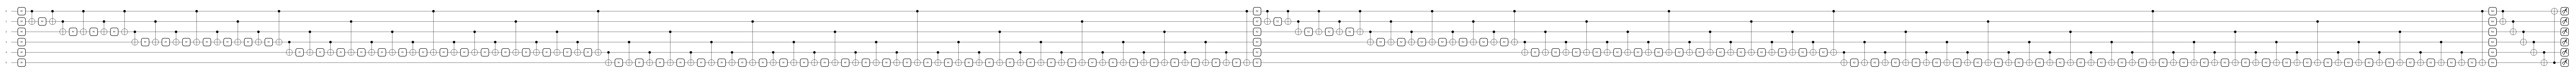

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-11-2ea64f6e9e1a>:61: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:305.)
  q_result = q_result.clone().detach().to(torch.float32).to(x.device)  # Safely clone and move to GPU


No checkpoint found at /content/sample_data/checkpoint.pthqnn.tar. Starting from scratch.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/75 - Loss: 5.0289 - Accuracy: 0.0944 - Precision: 0.1869 - Recall: 0.0944 - F1: 0.0864


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  23.058823529411764 precision_test-  0.17704501683256443 recall_test-  0.23058823529411768 f1 test-  0.16335883359797695
Checkpoint saved at epoch 1.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/75 - Loss: 4.4047 - Accuracy: 0.2812 - Precision: 0.3961 - Recall: 0.2812 - F1: 0.2569


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  46.705882352941174 precision_test-  0.3919273463202066 recall_test-  0.4670588235294117 f1 test-  0.37388793391605274
Checkpoint saved at epoch 2.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/75 - Loss: 3.3854 - Accuracy: 0.4864 - Precision: 0.5597 - Recall: 0.4864 - F1: 0.4485


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  66.58823529411765 precision_test-  0.6107400050356706 recall_test-  0.6658823529411765 f1 test-  0.600100375580024
Checkpoint saved at epoch 3.
Epoch 4/75 - Loss: 2.4120 - Accuracy: 0.6381 - Precision: 0.6852 - Recall: 0.6381 - F1: 0.6133


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  72.70588235294117 precision_test-  0.6867607323876673 recall_test-  0.7270588235294118 f1 test-  0.6736625258966165
Checkpoint saved at epoch 4.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/75 - Loss: 1.7322 - Accuracy: 0.7391 - Precision: 0.7515 - Recall: 0.7391 - F1: 0.7281


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  76.94117647058823 precision_test-  0.763535141329259 recall_test-  0.7694117647058825 f1 test-  0.728966474398545
Checkpoint saved at epoch 5.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/75 - Loss: 1.3062 - Accuracy: 0.7889 - Precision: 0.8016 - Recall: 0.7889 - F1: 0.7752


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  79.17647058823529 precision_test-  0.7575992634816164 recall_test-  0.7917647058823529 f1 test-  0.7523755656108597
Checkpoint saved at epoch 6.
Epoch 7/75 - Loss: 1.0427 - Accuracy: 0.8249 - Precision: 0.8313 - Recall: 0.8249 - F1: 0.8207


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  83.17647058823529 precision_test-  0.8181591870259689 recall_test-  0.8317647058823529 f1 test-  0.8054121205591794
Checkpoint saved at epoch 7.
Epoch 8/75 - Loss: 0.8623 - Accuracy: 0.8551 - Precision: 0.8647 - Recall: 0.8551 - F1: 0.8494


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  84.94117647058823 precision_test-  0.8465650199473728 recall_test-  0.8494117647058824 f1 test-  0.827530136803038
Checkpoint saved at epoch 8.
Epoch 9/75 - Loss: 0.7384 - Accuracy: 0.8722 - Precision: 0.8780 - Recall: 0.8722 - F1: 0.8690


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  88.3529411764706 precision_test-  0.8920611577964519 recall_test-  0.8835294117647058 f1 test-  0.8753507929978519
Checkpoint saved at epoch 9.
Epoch 10/75 - Loss: 0.6432 - Accuracy: 0.8892 - Precision: 0.8947 - Recall: 0.8892 - F1: 0.8864


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  86.11764705882354 precision_test-  0.8654882303798712 recall_test-  0.8611764705882352 f1 test-  0.8475122263357558
Checkpoint saved at epoch 10.


KeyboardInterrupt: 

In [ ]:
  # Step 1: Install Required Packages
  #!pip install pennylane pennylane-lightning-gpu torch torchvision matplotlib scikit-learn

  import pennylane as qml
  from pennylane import numpy as np
  import torch
  from torchvision import datasets, transforms
  from torch.utils.data import DataLoader, Dataset, random_split
  from torch import nn, optim
  import matplotlib.pyplot as plt
  from sklearn.metrics import precision_score, recall_score, f1_score


  # Step 3: Set Up the Quantum Device with lightning.qubit and GPU
  print("image_size ", image_size)
  n_pixels = image_size * image_size  # Total number of pixels in the image (784 for 28x28)
  n_qubits = int(np.ceil(np.log2(n_pixels)))  # Number of qubits needed for amplitude encoding
  L = 1  # Number of repetitions of the quantum layer

  # Use lightning.qubit device with GPU support
  dev = qml.device("lightning.qubit", wires=n_qubits)

  def quantum_layer(weights):
      for l in range(L):
          for i in range(n_qubits):
              qml.Rot(weights[l, i, 0], weights[l, i, 1], weights[l, i, 2], wires=i)  # Trainable rotation gates
          # Add entanglement between qubits (e.g., CNOT, CZ, or any other entangling gate)
          for i in range(n_qubits - 1):
              qml.CNOT(wires=[i, i + 1])
      # For a ring entanglement
      qml.CNOT(wires=[n_qubits - 1, 0])

  @qml.qnode(dev, interface="torch")
  def quantum_circuit(inputs, weights):
      # Amplitude encoding: encodes the normalized pixel values into quantum amplitudes
      qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), pad_with=0.0, normalize=True)
      quantum_layer(weights)
      # Return the full statevector
      return qml.state()

  # Example input for drawing the circuit (dummy input)
  example_input = np.random.rand(n_pixels).astype(np.float32)
  example_weights = np.random.rand(L, n_qubits, 3).astype(np.float32)  # Randomly initialized weights

  # Draw the circuit using Matplotlib (optional)
  qml.draw_mpl(quantum_circuit)(example_input, example_weights)
  plt.show()

  # Step 4: Define the Hybrid Quantum-Classical Model
  class HybridModel(nn.Module):
      def __init__(self):
          super(HybridModel, self).__init__()
          self.q_weights = nn.Parameter(0.01 * torch.randn(L, n_qubits, 3, dtype=torch.float32))  # Trainable quantum weights
          self.fc1 = nn.Linear(2**n_qubits, 256)  # First classical layer (increased size)
          self.fc2 = nn.Linear(256, 170)           # Output layer for 170 classes

      def forward(self, x):
          q_out = []
          for i in range(x.size(0)):
              q_result = quantum_circuit(x[i], self.q_weights)
              q_result = q_result.clone().detach().to(torch.float32).to(x.device)  # Safely clone and move to GPU
              q_out.append(q_result)
          q_out = torch.stack(q_out)  # Shape: [batch_size, 2^n_qubits]
          # Pass through classical layers
          x = self.fc1(q_out)
          #x = nn.functional.relu(x)
          x = self.fc2(x)
          return x

  # Step 5: Move Model to GPU
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = HybridModel().to(device)

  # Step 7: Evaluate the Model on GPU and Calculate Metrics
  def test_model(model, test_loader):
      model.eval()
      correct = 0
      total = 0
      all_targets = []
      all_preds = []

      with torch.no_grad():
          for data, targets in test_loader:
              data = data.float().to(device)  # Ensure data is a float tensor and move to GPU
              targets = targets.long().to(device)  # Move targets to GPU
              output = model(data)
              _, predicted = torch.max(output.data, 1)
              total += targets.size(0)
              correct += (predicted == targets).sum().item()
              all_targets.extend(targets.cpu().numpy())
              all_preds.extend(predicted.cpu().numpy())

      accuracy = 100 * correct / total
      precision = precision_score(all_targets, all_preds, average='macro')
      recall = recall_score(all_targets, all_preds, average='macro')
      f1 = f1_score(all_targets, all_preds, average='macro')

      # print(f'Accuracy: {accuracy}%')
      # print(f'Precision: {precision:.4f}')
      # print(f'Recall: {recall:.4f}')
      # print(f'F1 Score: {f1:.4f}')
      return accuracy, precision, recall, f1

  # Step 6: Train the Model on GPU and Track Metrics
  def train_model(model, train_loader, criterion, optimizer, epochs=5, start_epoch=0):

  #def train_model(model, train_loader, criterion, optimizer, epochs=5):
      model.train()
      history = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

      for epoch in range(epochs):
          total_loss = 0
          all_targets = []
          all_preds = []

          for data, targets in train_loader:
              data = data.float().to(device)  # Ensure data is a float tensor and move to GPU
              targets = targets.long().to(device)  # Ensure targets are long tensors and move to GPU
              optimizer.zero_grad()
              output = model(data)
              loss = criterion(output, targets)
              loss.backward()
              optimizer.step()

              total_loss += loss.item()
              _, preds = torch.max(output, 1)
              all_targets.extend(targets.cpu().numpy())
              all_preds.extend(preds.cpu().numpy())

          # Calculate metrics
          precision = precision_score(all_targets, all_preds, average='macro')
          recall = recall_score(all_targets, all_preds, average='macro')
          f1 = f1_score(all_targets, all_preds, average='macro')
          accuracy = (np.array(all_preds) == np.array(all_targets)).mean()

          avg_loss = total_loss / len(train_loader)
          history['loss'].append(avg_loss)
          history['accuracy'].append(accuracy)
          history['precision'].append(precision)
          history['recall'].append(recall)
          history['f1'].append(f1)

          print(f'Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')

          accuracy_test, precision_test, recall_test, f1_test = test_model(model, test_loader)
          print("accuracy_test- ",accuracy_test, "precision_test- ", precision_test, "recall_test- ",recall_test, "f1 test- ",f1_test)
          # Save the model after every epoch
          save_checkpoint(epoch + 1, model, optimizer)

          # Step the scheduler
          scheduler.step(avg_loss)
      return history

  # # Initialize the criterion and optimizer
  # criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
  # optimizer = optim.Adam(model.parameters(), lr=0.001)

  # # Train the model
  # history = train_model(model, train_loader, criterion, optimizer, epochs=50)

  # Initialize the criterion and optimizer
  from pytorch_toolbelt.losses import CrossEntropyFocalLoss
  from torch.optim.lr_scheduler import ReduceLROnPlateau
  import os

  # Define a function to save the model
  def save_checkpoint(epoch, model, optimizer, filename="/content/sample_data/checkpoint.pthqnn.tar"):
      checkpoint = {
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
      }
      torch.save(checkpoint, filename)
      #files.download(filename)
      print(f"Checkpoint saved at epoch {epoch}.")

  # Define a function to load the model
  def load_checkpoint(model, optimizer, filename="/content/sample_data/checkpoint.pthqnn.tar"):
      if os.path.isfile(filename):
          checkpoint = torch.load(filename)
          model.load_state_dict(checkpoint['model_state_dict'])
          optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
          scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
          start_epoch = checkpoint['epoch']
          print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}.")
      else:
          print(f"No checkpoint found at {filename}. Starting from scratch.")
          start_epoch = 0
      return start_epoch



  criterion = nn.CrossEntropyLoss()#gamma=2.0, reduction='mean')
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  # Implement learning rate scheduler
  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

  # Load the checkpoint if it exists
  start_epoch = load_checkpoint(model, optimizer)


  # Train the model
  #history2 = train_model(model, train_loader, criterion, optimizer, scheduler, epochs=21)
  history = train_model(model, train_loader, criterion, optimizer,epochs=75, start_epoch=start_epoch)

  accuracy, precision, recall, f1 = test_model(model, test_loader)




In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pennylane as qml
import math

# Define the quantum device
# Step 3: Set Up the Quantum Device with lightning.qubit and GPU
print("image_size ", image_size)
n_pixels = image_size * image_size  # Total number of pixels in the image (784 for 28x28)
n_qubits = int(np.ceil(np.log2(n_pixels)))  # Number of qubits needed for amplitude encoding
L = 1  # Number of repetitions of the quantum layer

# Use lightning.qubit device with GPU support
dev = qml.device("lightning.qubit", wires=n_qubits)

# Define the quantum circuit
@qml.qnode(dev, interface="torch")
def combined_quantum_circuit(inputs, attention_weights, weights, attention_weights2, weights2, active_layer=None):
    pad_size = max(0, 2**n_qubits - inputs.shape[0])
    padded_inputs = torch.cat([inputs, torch.zeros(pad_size)], dim=0)

    qml.AmplitudeEmbedding(features=padded_inputs, wires=range(n_qubits), pad_with=0.0, normalize=True)

    if active_layer is None or active_layer == 1:
        for l in range(weights.shape[0]):
            for i in range(n_qubits):
                qml.Rot(weights[l, i, 0], weights[l, i, 1], weights[l, i, 2], wires=i)
            for i in range(n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])
        if active_layer == 1:
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    norm_in = torch.norm(attention_weights.detach().cpu(), p=2)

    if attention_weights.detach().cpu().numpy().all() == 0:
        pass
    else:
        qml.MottonenStatePreparation(attention_weights.detach().cpu().numpy() / norm_in, wires=range(n_qubits))

    if active_layer is None or active_layer == 2:
        for l in range(weights2.shape[0]):
            for i in range(n_qubits):
                qml.Rot(weights2[l, i, 0], weights2[l, i, 1], weights2[l, i, 2], wires=i)
            for i in range(n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the hybrid model
class HybridModel(nn.Module):
    def __init__(self, n_qubits):
        super(HybridModel, self).__init__()
        self.n_qubits = n_qubits
        self.q_weights1 = nn.Parameter(0.01 * torch.randn(1, n_qubits, 3))
        self.q_weights2 = nn.Parameter(0.01 * torch.randn(1, n_qubits, 3))
        self.attention_weights1 = nn.Parameter(0.01 * torch.randn(2**n_qubits))
        self.attention_weights2 = nn.Parameter(0.01 * torch.randn(2**n_qubits))
        self.fc1 = nn.Linear(n_qubits, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 170)  # Assuming 10 classes

    def forward(self, x, active_layer=None):
        q_out = []
        for i in range(x.size(0)):
            flattened_input = x[i].view(-1)  # Flatten the image
            pad_size = max(0, 2**self.n_qubits - flattened_input.size(0))
            padded_input = torch.cat([flattened_input, torch.zeros(pad_size)], dim=0)
            q_result = combined_quantum_circuit(padded_input, self.attention_weights1, self.q_weights1, self.attention_weights2, self.q_weights2, active_layer)
            q_result_tensor = torch.tensor(q_result, dtype=torch.float32, device=x.device)
            q_out.append(q_result_tensor)
        q_out = torch.stack(q_out)
        x = self.fc1(q_out)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Setup model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel(n_qubits).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Setup dataset and dataloader

# Training function
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        total = 0
        correct = 0
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        accuracy = 100 * correct / total
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Accuracy: {accuracy}%')

# Testing function
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}%')

# Train the model
train_model(model, train_loader, criterion, optimizer, device, epochs=10)

# Test the model
test_model(model, test_loader, device)


image_size  8


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import numpy as np

# Constants
CHANNELS = 1
N_LAYERS = 3



# Function to determine number of qubits based on image size
def get_num_qubits(image_size):
    n_pixels = image_size * image_size  # Total number of pixels in the image
    n_qubits = int(np.ceil(np.log2(n_pixels)))  # Number of qubits needed for amplitude encoding
    return n_qubits

# Define the quantum circuit
def create_quantum_circuit(n_qubits):
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev)
    def quantum_circuit(inputs, weights):
        # Encode the classical input data into the quantum circuit using amplitude embedding
        qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)

        # Apply parametrized quantum layers
        for i in range(N_LAYERS):
            for j in range(n_qubits):
                qml.RY(weights[i][j], wires=j)
            for j in range(n_qubits - 1):
                qml.CNOT(wires=[j, j + 1])

        # Measure the expectation values of all qubits
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    return quantum_circuit

# Define the hybrid quantum-classical model
class QNN(nn.Module):
    def __init__(self, image_size, n_classes):
        super().__init__()
        self.image_size = image_size
        self.n_qubits = get_num_qubits(image_size)
        self.quantum_circuit = create_quantum_circuit(self.n_qubits)

        # self.pre_net = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(image_size * image_size, 2**self.n_qubits),
        #     nn.ReLU(),
        #     nn.BatchNorm1d(2**self.n_qubits)
        # )
        weight_shapes = {"weights": (N_LAYERS, self.n_qubits)}
        self.quantum_layer = qml.qnn.TorchLayer(self.quantum_circuit, weight_shapes)
        self.post_net = nn.Linear(self.n_qubits, 256)
        self.post_net2 = nn.Linear(256, n_classes)

    def forward(self, x):
#        x = self.pre_net(x)
        x = self.quantum_layer(x)
        x = self.post_net(x)
        x = self.post_net2(x)
        return x

# Example visualization of the quantum model
def visualize_quantum_model(image_size):
    n_qubits = get_num_qubits(image_size)
    quantum_circuit = create_quantum_circuit(n_qubits)

    # Generate random inputs and weights for the visualization
    sample_input = np.random.random(2 ** n_qubits)
    sample_weights = np.random.random((N_LAYERS, n_qubits))

    # Draw the circuit
    print("Quantum Circuit:")
    qml.draw(quantum_circuit)(sample_input, sample_weights)

# Example usage
visualize_quantum_model(image_size)

# Training function
def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 100 == 99:    # print every 100 mini-batches
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {running_loss / 100:.6f} '
                  f'Accuracy: {100. * correct / total:.2f}%')
            running_loss = 0.0
        # Step the scheduler
       # scheduler.step(running_loss)

# Testing function
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return accuracy

# Example usage (assuming train_loader and test_loader are already defined)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Get input size and number of classes from the dataset
sample_data, _ = next(iter(train_loader))
batch_size, image_size = sample_data.shape
image_size=int(np.sqrt(image_size))
n_classes = 170  # Assuming 170 classes as per your description

# Initialize the model
model = QNN(image_size, n_classes).to(device)
print(f"Image size: {image_size}x{image_size}")
print(f"Number of channels: {CHANNELS}")
print(f"Number of qubits: {model.n_qubits}")
print(f"Number of quantum layers: {N_LAYERS}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Add the ReduceLROnPlateau scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Load the checkpoint if it exists
#start_epoch = load_checkpoint(model, optimizer, scheduler)

# Training loop
num_epochs = 200
best_accuracy = 0
for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, criterion, device, epoch)
    accuracy = test(model, test_loader, criterion, device)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved with accuracy: {best_accuracy:.2f}%")

print("Training complete!")
print(f"Best test accuracy: {best_accuracy:.2f}%")

Quantum Circuit:
Using device: cpu
Image size: 8x8
Number of channels: 1
Number of qubits: 6
Number of quantum layers: 3


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [3168/4250 (74%)]	Loss: 4.204156 Accuracy: 9.59%

Test set: Average loss: 0.0878, Accuracy: 258/850 (30.35%)

New best model saved with accuracy: 30.35%
Train Epoch: 2 [3168/4250 (74%)]	Loss: 2.249627 Accuracy: 39.19%

Test set: Average loss: 0.0609, Accuracy: 444/850 (52.24%)

New best model saved with accuracy: 52.24%
Train Epoch: 3 [3168/4250 (74%)]	Loss: 1.507535 Accuracy: 57.41%

Test set: Average loss: 0.0512, Accuracy: 501/850 (58.94%)

New best model saved with accuracy: 58.94%
Train Epoch: 4 [3168/4250 (74%)]	Loss: 1.195239 Accuracy: 65.16%

Test set: Average loss: 0.0438, Accuracy: 531/850 (62.47%)

New best model saved with accuracy: 62.47%
Train Epoch: 5 [3168/4250 (74%)]	Loss: 1.049844 Accuracy: 67.75%

Test set: Average loss: 0.0414, Accuracy: 577/850 (67.88%)

New best model saved with accuracy: 67.88%
Train Epoch: 6 [3168/4250 (74%)]	Loss: 0.955276 Accuracy: 70.16%

Test set: Average loss: 0.0392, Accuracy: 576/850 (67.76%)

Train Epoch: 7 [3168/4250 (74%

KeyboardInterrupt: 

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 256]

In [ ]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np

# Constants
N_LAYERS = 2  # Number of quantum layers for attention mechanism
N_CLASSES = 170  # Number of output classes (multi-class classification)

# Function to determine number of qubits based on image size
def get_num_qubits(image_size):
    n_pixels = image_size * image_size  # Total number of pixels in the image
    n_qubits = int(np.ceil(np.log2(n_pixels)))  # Number of qubits needed for amplitude encoding
    return n_qubits

# Quantum attention mechanism using 6 qubits
def create_quantum_attention_circuit():
    dev = qml.device('default.qubit', wires=6)

    @qml.qnode(dev)
    def quantum_attention_circuit(inputs, query_weights, key_weights, value_weights):
        # Step 1: Amplitude embedding for inputs (assuming inputs are normalized)
        qml.AmplitudeEmbedding(inputs, wires=range(n), normalize=True)

        # Step 2: Apply parameterized rotation gates (query, key, value)
        for i in range(6):
            qml.RY(query_weights[i], wires=i)  # Query
            qml.RY(key_weights[i], wires=i)    # Key
            qml.RY(value_weights[i], wires=i)  # Value

        # Step 3: Logical similarity (QLS) using CNOT and Toffoli gates
        for i in range(5):  # Multi-controlled operations for similarity
            qml.Toffoli(wires=[i, (i+1)%6, (i+2)%6])
            qml.CNOT(wires=[i, (i+1)%6])

        # Step 4: Measure the output in the Pauli-Z basis (attention scores)
        return [qml.expval(qml.PauliZ(i)) for i in range(6)]

    return quantum_attention_circuit

# Define the hybrid quantum-classical model for multi-class classification
class QNN(nn.Module):
    def __init__(self, image_size, n_classes):
        super().__init__()
        self.image_size = image_size
        self.n_qubits = get_num_qubits(image_size)  # Calculate the number of qubits required for the image size
        self.n_classes = n_classes
        self.quantum_attention = create_quantum_attention_circuit()

        # Define the weight shapes for the quantum circuit
        weight_shapes = {"query_weights": (6,), "key_weights": (6,), "value_weights": (6,)}
        self.quantum_layer = qml.qnn.TorchLayer(self.quantum_attention, weight_shapes)

        # Add a final layer that maps quantum outputs to class logits
        self.fc = nn.Linear(6, n_classes)

    def forward(self, x):
        x = self.quantum_layer(x)
        x = self.fc(x)  # Final linear layer to map quantum outputs to class logits
        return x

# Training function
def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 100 == 99:    # print every 100 mini-batches
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {running_loss / 100:.6f} '
                  f'Accuracy: {100. * correct / total:.2f}%')
            running_loss = 0.0

# Testing function
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return accuracy

# Example usage (assuming train_loader and test_loader are already defined)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Get input size and number of classes from the dataset
sample_data, _ = next(iter(train_loader))
batch_size, image_size = sample_data.shape
image_size = int(np.sqrt(image_size))

# Initialize the model
model = QNN(image_size, N_CLASSES).to(device)
print(f"Image size: {image_size}x{image_size}")
print(f"Number of qubits: {model.n_qubits}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Add the ReduceLROnPlateau scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Training loop
num_epochs = 200
best_accuracy = 0
for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, criterion, device, epoch)
    accuracy = test(model, test_loader, criterion, device)

    scheduler.step(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved with accuracy: {best_accuracy:.2f}%")

print("Training complete!")
print(f"Best test accuracy: {best_accuracy:.2f}%")


Using device: cpu
Image size: 16x16
Number of qubits: 8


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


ValueError: State must be of length 64; got length 256. Use the 'pad_with' argument for automated padding.

In [ ]:
# Example visualization of the quantum model
def visualize_quantum_model(image_size, n_classes):
    n_qubits = get_num_qubits(image_size)
    quantum_circuit = create_quantum_circuit(n_qubits)

    # Generate random inputs and weights for the visualization
    sample_input = np.random.random(2 ** n_qubits)
    sample_weights = np.random.random((N_LAYERS, n_qubits))

    # Draw the circuit
    print("Quantum Circuit:")
    qml.draw_mpl(quantum_circuit)(sample_input, sample_weights)

# Example usage
visualize_quantum_model(image_size, N_CLASSES)

In [ ]:
sample_data, k = next(iter(train_loader))
sample_data.shape
k

tensor([  9,  43,  46, 153,  40,  75,  21, 130,  84, 168, 149, 136, 141,  92,
        161,  46, 135,  18,   7,  42,  15,  57,  68, 119, 168, 117,  41,  23,
        153, 126,  73,  76])

image_size  8


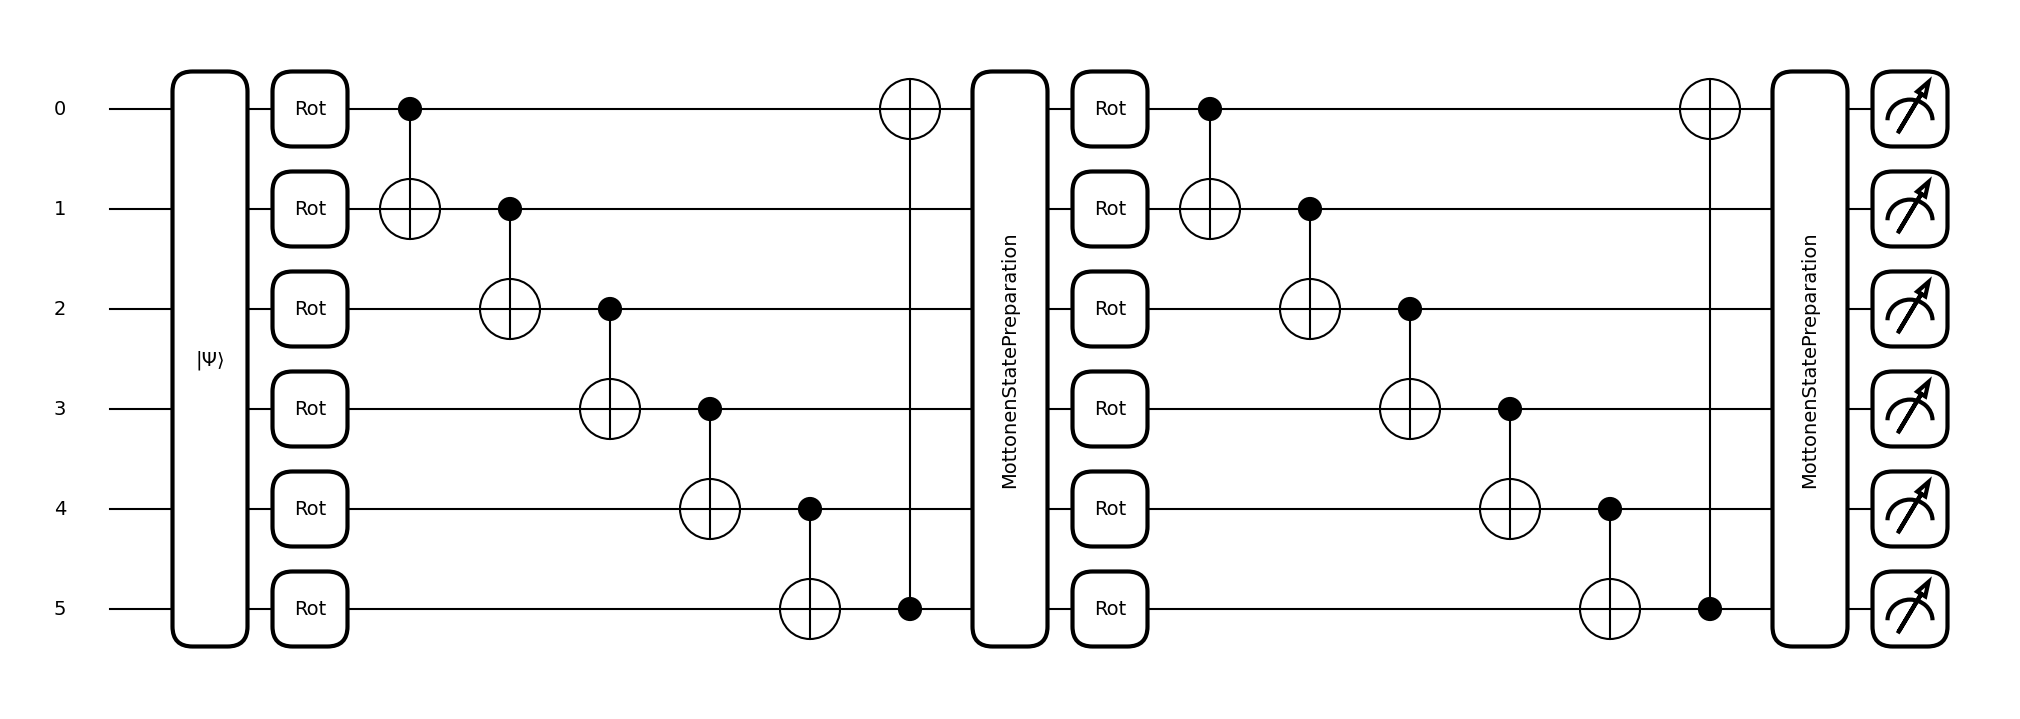

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


No checkpoint found at /content/sample_data/checkpoint.pth.tar. Starting from scratch.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/75 - Loss: 4.6908 - Accuracy: 0.0558 - Precision: 0.1026 - Recall: 0.0558 - F1: 0.0514


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  22.352941176470587 precision_test-  0.1216800295357543 recall_test-  0.2235294117647059 f1 test-  0.13177928107395245
Checkpoint saved at epoch 1.
Epoch 2/75 - Loss: 2.1980 - Accuracy: 0.4591 - Precision: 0.4811 - Recall: 0.4591 - F1: 0.4542


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  64.94117647058823 precision_test-  0.5736895342777696 recall_test-  0.6494117647058824 f1 test-  0.5760371293147654
Checkpoint saved at epoch 2.
Epoch 3/75 - Loss: 0.9684 - Accuracy: 0.7092 - Precision: 0.7117 - Recall: 0.7092 - F1: 0.7073


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  76.70588235294117 precision_test-  0.7395876835582718 recall_test-  0.7670588235294118 f1 test-  0.7271794691376735
Checkpoint saved at epoch 3.
Epoch 4/75 - Loss: 0.6240 - Accuracy: 0.8078 - Precision: 0.8107 - Recall: 0.8078 - F1: 0.8074


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  81.6470588235294 precision_test-  0.7907223495458789 recall_test-  0.8164705882352942 f1 test-  0.7829063626058511
Checkpoint saved at epoch 4.
Epoch 5/75 - Loss: 0.4655 - Accuracy: 0.8527 - Precision: 0.8538 - Recall: 0.8527 - F1: 0.8518


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  84.58823529411765 precision_test-  0.8458390182229193 recall_test-  0.8458823529411765 f1 test-  0.8263799599093715
Checkpoint saved at epoch 5.
Epoch 6/75 - Loss: 0.3890 - Accuracy: 0.8847 - Precision: 0.8857 - Recall: 0.8847 - F1: 0.8840


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  88.11764705882354 precision_test-  0.8816267719208895 recall_test-  0.8811764705882353 f1 test-  0.8656379568144275
Checkpoint saved at epoch 6.
Epoch 7/75 - Loss: 0.3158 - Accuracy: 0.9073 - Precision: 0.9086 - Recall: 0.9073 - F1: 0.9072


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  87.41176470588235 precision_test-  0.8740321769733534 recall_test-  0.8741176470588234 f1 test-  0.8552911656626826
Checkpoint saved at epoch 7.
Epoch 8/75 - Loss: 0.2864 - Accuracy: 0.9108 - Precision: 0.9112 - Recall: 0.9108 - F1: 0.9103


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  89.88235294117646 precision_test-  0.9024523678935443 recall_test-  0.8988235294117648 f1 test-  0.889248170130523
Checkpoint saved at epoch 8.
Epoch 9/75 - Loss: 0.2506 - Accuracy: 0.9212 - Precision: 0.9222 - Recall: 0.9212 - F1: 0.9211


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  90.3529411764706 precision_test-  0.9090813598166539 recall_test-  0.903529411764706 f1 test-  0.8934560777553857
Checkpoint saved at epoch 9.
Epoch 10/75 - Loss: 0.2368 - Accuracy: 0.9226 - Precision: 0.9231 - Recall: 0.9226 - F1: 0.9222


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  89.17647058823529 precision_test-  0.900749299719888 recall_test-  0.8917647058823529 f1 test-  0.8796964799905976
Checkpoint saved at epoch 10.
Epoch 11/75 - Loss: 0.2104 - Accuracy: 0.9320 - Precision: 0.9327 - Recall: 0.9320 - F1: 0.9318


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  90.11764705882354 precision_test-  0.9055508870214752 recall_test-  0.9011764705882352 f1 test-  0.8899103699877695
Checkpoint saved at epoch 11.
Epoch 12/75 - Loss: 0.1993 - Accuracy: 0.9315 - Precision: 0.9318 - Recall: 0.9315 - F1: 0.9312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  88.94117647058823 precision_test-  0.898565486800781 recall_test-  0.8894117647058822 f1 test-  0.878126739051434
Checkpoint saved at epoch 12.
Epoch 13/75 - Loss: 0.1780 - Accuracy: 0.9433 - Precision: 0.9441 - Recall: 0.9433 - F1: 0.9433


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  92.11764705882354 precision_test-  0.9325373482726423 recall_test-  0.9211764705882353 f1 test-  0.917203058379529
Checkpoint saved at epoch 13.
Epoch 14/75 - Loss: 0.1733 - Accuracy: 0.9405 - Precision: 0.9409 - Recall: 0.9405 - F1: 0.9402


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  92.47058823529412 precision_test-  0.9163748832866481 recall_test-  0.9247058823529412 f1 test-  0.9130128041892747
Checkpoint saved at epoch 14.
Epoch 15/75 - Loss: 0.1767 - Accuracy: 0.9369 - Precision: 0.9377 - Recall: 0.9369 - F1: 0.9370


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  90.94117647058823 precision_test-  0.9237428910958322 recall_test-  0.9094117647058825 f1 test-  0.9005787186669539
Checkpoint saved at epoch 15.
Epoch 16/75 - Loss: 0.1633 - Accuracy: 0.9459 - Precision: 0.9467 - Recall: 0.9459 - F1: 0.9459


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  93.05882352941177 precision_test-  0.9311437908496732 recall_test-  0.9305882352941176 f1 test-  0.922134173016526
Checkpoint saved at epoch 16.
Epoch 17/75 - Loss: 0.1588 - Accuracy: 0.9431 - Precision: 0.9432 - Recall: 0.9431 - F1: 0.9427


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  91.41176470588235 precision_test-  0.9156639928698752 recall_test-  0.9141176470588236 f1 test-  0.9063667541608719
Checkpoint saved at epoch 17.
Epoch 18/75 - Loss: 0.1464 - Accuracy: 0.9471 - Precision: 0.9480 - Recall: 0.9471 - F1: 0.9471


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  92.94117647058823 precision_test-  0.9275093370681605 recall_test-  0.9294117647058824 f1 test-  0.9221824119747994
Checkpoint saved at epoch 18.
Epoch 19/75 - Loss: 0.1502 - Accuracy: 0.9501 - Precision: 0.9505 - Recall: 0.9501 - F1: 0.9500


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  94.58823529411765 precision_test-  0.9445972328325271 recall_test-  0.9458823529411765 f1 test-  0.9393352562470211
Checkpoint saved at epoch 19.
Epoch 20/75 - Loss: 0.1433 - Accuracy: 0.9501 - Precision: 0.9502 - Recall: 0.9501 - F1: 0.9498


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  90.82352941176471 precision_test-  0.9084633177280236 recall_test-  0.9082352941176471 f1 test-  0.8962062937062937
Checkpoint saved at epoch 20.
Epoch 21/75 - Loss: 0.1463 - Accuracy: 0.9424 - Precision: 0.9428 - Recall: 0.9424 - F1: 0.9421


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  92.0 precision_test-  0.9248586870645694 recall_test-  0.9200000000000002 f1 test-  0.910355461531932
Checkpoint saved at epoch 21.
Epoch 22/75 - Loss: 0.1356 - Accuracy: 0.9536 - Precision: 0.9542 - Recall: 0.9536 - F1: 0.9535


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  92.58823529411765 precision_test-  0.9261466637937227 recall_test-  0.9258823529411765 f1 test-  0.9165143026907733
Checkpoint saved at epoch 22.
Epoch 23/75 - Loss: 0.1217 - Accuracy: 0.9584 - Precision: 0.9587 - Recall: 0.9584 - F1: 0.9581


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  93.05882352941177 precision_test-  0.9308595489477842 recall_test-  0.9305882352941176 f1 test-  0.9239681560269793
Checkpoint saved at epoch 23.
Epoch 24/75 - Loss: 0.1169 - Accuracy: 0.9567 - Precision: 0.9573 - Recall: 0.9567 - F1: 0.9567


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  93.41176470588235 precision_test-  0.9280327515621634 recall_test-  0.9341176470588236 f1 test-  0.9248396451683648
Checkpoint saved at epoch 24.
Epoch 25/75 - Loss: 0.1120 - Accuracy: 0.9616 - Precision: 0.9620 - Recall: 0.9616 - F1: 0.9614


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  93.52941176470588 precision_test-  0.924650398620987 recall_test-  0.9352941176470588 f1 test-  0.9252884044060515
Checkpoint saved at epoch 25.
Epoch 26/75 - Loss: 0.1180 - Accuracy: 0.9574 - Precision: 0.9579 - Recall: 0.9574 - F1: 0.9574


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  92.23529411764706 precision_test-  0.9213059163059163 recall_test-  0.9223529411764707 f1 test-  0.9125590259413788
Checkpoint saved at epoch 26.
Epoch 27/75 - Loss: 0.1158 - Accuracy: 0.9591 - Precision: 0.9593 - Recall: 0.9591 - F1: 0.9589


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  93.88235294117646 precision_test-  0.9300070028011205 recall_test-  0.9388235294117647 f1 test-  0.9284953608483019
Checkpoint saved at epoch 27.
Epoch 28/75 - Loss: 0.1029 - Accuracy: 0.9638 - Precision: 0.9640 - Recall: 0.9638 - F1: 0.9636


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  93.6470588235294 precision_test-  0.9335439560439561 recall_test-  0.936470588235294 f1 test-  0.9287751137751139
Checkpoint saved at epoch 28.
Epoch 29/75 - Loss: 0.1221 - Accuracy: 0.9569 - Precision: 0.9577 - Recall: 0.9569 - F1: 0.9571


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  93.29411764705883 precision_test-  0.9335177404295052 recall_test-  0.9329411764705882 f1 test-  0.9239056694939048
Checkpoint saved at epoch 29.


In [ ]:
# Step 1: Install Required Packages
#!pip install pennylane pennylane-lightning-gpu torch torchvision matplotlib scikit-learn

import pennylane as qml
from pennylane import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from google.colab import files


# Define a function to save the model
def save_checkpoint(epoch, model, optimizer, scheduler,  filename="/content/sample_data/checkpoint.pth.tar"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }
    torch.save(checkpoint, filename)
    #files.download(filename)
    print(f"Checkpoint saved at epoch {epoch}.")

# Define a function to load the model
def load_checkpoint(model, optimizer, scheduler, filename="/content/sample_data/checkpoint.pth.tar"):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}.")
    else:
        print(f"No checkpoint found at {filename}. Starting from scratch.")
        start_epoch = 0
    return start_epoch


# Step 5: Move Model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Step 3: Set Up the Quantum Device with lightning.qubit and GPU
print("image_size ", image_size)
n_pixels = image_size * image_size  # Total number of pixels in the image (784 for 28x28)
n_qubits = int(np.ceil(np.log2(n_pixels)))  # Number of qubits needed for amplitude encoding
L = 1  # Number of repetitions of the quantum layer

# Use lightning.qubit device with GPU support
dev = qml.device("lightning.qubit", wires=n_qubits)

# Define the combined quantum circuit
@qml.qnode(dev, interface="torch")
def combined_quantum_circuit(inputs, attention_weights, weights, attention_weights2, weights2):
    # Step 1: Amplitude encoding of the input data
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), pad_with=0.0, normalize=True)

    # Step 2: First quantum layer
    for l in range(weights.shape[0]):  # Assuming L is the first dimension of weights
        for i in range(n_qubits):
            qml.Rot(weights[l, i, 0], weights[l, i, 1], weights[l, i, 2], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[n_qubits - 1, 0])

    # Step 3: Apply the first set of attention weights
    norm_value = torch.linalg.norm(attention_weights, ord=2)
    attention_weights = attention_weights / norm_value
    attention_weights_np = attention_weights.detach().cpu().numpy()
    qml.MottonenStatePreparation(attention_weights_np, wires=range(n_qubits))

    # Step 4: Second quantum layer
    for l in range(weights2.shape[0]):  # Assuming L is the first dimension of weights2
        for i in range(n_qubits):
            qml.Rot(weights2[l, i, 0], weights2[l, i, 1], weights2[l, i, 2], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[n_qubits - 1, 0])

    # Step 5: Apply the second set of attention weights
    norm_value2 = torch.linalg.norm(attention_weights2, ord=2)
    attention_weights2 = attention_weights2 / norm_value2
    attention_weights2_np = attention_weights2.detach().cpu().numpy()
    qml.MottonenStatePreparation(attention_weights2_np, wires=range(n_qubits))

    # Return the full statevector
    return qml.state()



# Example input for drawing the circuit
# Example input for drawing the circuit
example_input = torch.rand(n_pixels).cpu().numpy()  # Ensure the input is a NumPy array
example_attention_weights1 = torch.rand(2**n_qubits, dtype=torch.float32).to(device)  # Randomly initialized attention weights on the correct device
example_attention_weights2 = torch.rand(2**n_qubits, dtype=torch.float32).to(device)  # Second attention weights
example_weights1 = torch.rand(L, n_qubits, 3, dtype=torch.float32).to(device)  # Randomly initialized weights on the correct device
example_weights2 = torch.rand(L, n_qubits, 3, dtype=torch.float32).to(device)  # Second quantum layer weights

# Draw the circuit
qml.draw_mpl(combined_quantum_circuit)(example_input, example_attention_weights1, example_weights1, example_attention_weights2, example_weights2)
plt.show()



# Step 4: Define the Hybrid Quantum-Classical Model
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.q_weights1 = nn.Parameter(0.01 * torch.randn(L, n_qubits, 3, dtype=torch.float32))  # First quantum layer weights
        self.q_weights2 = nn.Parameter(0.01 * torch.randn(L, n_qubits, 3, dtype=torch.float32))  # Second quantum layer weights

        self.attention_weights1 = nn.Parameter(0.01 * torch.randn(2**n_qubits, dtype=torch.float32))  # First attention weights
        self.attention_weights2 = nn.Parameter(0.01 * torch.randn(2**n_qubits, dtype=torch.float32))  # Second attention weights

        self.fc1 = nn.Linear(2**n_qubits, 512)  # First classical layer (increased size)
        self.fc2 = nn.Linear(512, 256)          # Second classical layer
        self.fc3 = nn.Linear(256, 170)          # Output layer for 170 classes

    def forward(self, x):
        q_out= []

        for i in range(x.size(0)):
            q_result = combined_quantum_circuit(x[i], self.attention_weights1, self.q_weights1, self.attention_weights2, self.q_weights2)
            q_result = q_result.clone().detach().to(torch.float32).to(x.device)  # Safely clone and move to GPU
            q_out.append(q_result)



        q_out = torch.stack(q_out)  # Shape: [batch_size, 2^n_qubits]

        # Pass through classical layers
        x = self.fc1(q_out)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Step 5: Move Model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel().to(device)

# Step 7: Evaluate the Model on GPU and Calculate Metrics
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for data, targets in test_loader:
            data = data.float().to(device)  # Ensure data is a float tensor and move to GPU
            targets = targets.long().to(device)  # Move targets to GPU
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    # print(f'Accuracy: {accuracy}%')
    # print(f'Precision: {precision:.4f}')
    # print(f'Recall: {recall:.4f}')
    # print(f'F1 Score: {f1:.4f}')
    return accuracy, precision, recall, f1



def test_model_with_analysis(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_targets = []
    all_preds = []
    misclassified_images = []
    misclassified_preds = []
    misclassified_labels = []

    with torch.no_grad():
        for data, targets in test_loader:
            data = data.float().to(device)  # Ensure data is a float tensor and move to GPU
            targets = targets.long().to(device)  # Move targets to GPU
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Identify misclassifications
            for i in range(len(predicted)):
                if predicted[i] != targets[i]:
                    misclassified_images.append(data[i].cpu().numpy())
                    misclassified_preds.append(predicted[i].cpu().numpy())
                    misclassified_labels.append(targets[i].cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    print(f'Accuracy: {accuracy}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    return accuracy, precision, recall, f1, misclassified_images, misclassified_preds, misclassified_labels


# Step 6: Train the Model on GPU and Track Metrics
# def train_model(model, train_loader, criterion, optimizer,scheduler, epochs=5):
#     model.train()
#     history = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

#     for epoch in range(epochs):
#         total_loss = 0
#         all_targets = []
#         all_preds = []

#         for data, targets in train_loader:
#             data = data.float().to(device)  # Ensure data is a float tensor and move to GPU
#             targets = targets.long().to(device)  # Ensure targets are long tensors and move to GPU
#             optimizer.zero_grad()
#             output = model(data)
#             loss = criterion(output, targets)
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()
#             _, preds = torch.max(output, 1)
#             all_targets.extend(targets.cpu().numpy())
#             all_preds.extend(preds.cpu().numpy())

#         # Calculate metrics
#         precision = precision_score(all_targets, all_preds, average='macro')
#         recall = recall_score(all_targets, all_preds, average='macro')
#         f1 = f1_score(all_targets, all_preds, average='macro')
#         accuracy = (np.array(all_preds) == np.array(all_targets)).mean()

#         avg_loss = total_loss / len(train_loader)
#         history['loss'].append(avg_loss)
#         history['accuracy'].append(accuracy)
#         history['precision'].append(precision)
#         history['recall'].append(recall)
#         history['f1'].append(f1)

#         print(f'Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')

#         #accuracy_test, precision_test, recall_test, f1_test = test_model(model, test_loader)
#         #print("accuracy_test- ",accuracy_test, "precision_test- ", precision_test, "recall_test- ",recall_test, "f1 test- ",f1_test)
#         scheduler.step(avg_loss)

#     return history

# Step 6: Train the Model on GPU and Track Metrics
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=5, start_epoch=0):
    model.train()
    history = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for epoch in range(start_epoch, epochs):
        total_loss = 0
        all_targets = []
        all_preds = []

        for data, targets in train_loader:
            data = data.float().to(device)  # Ensure data is a float tensor and move to GPU
            targets = targets.long().to(device)  # Ensure targets are long tensors and move to GPU
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(output, 1)
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        # Calculate metrics
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')
        accuracy = (np.array(all_preds) == np.array(all_targets)).mean()

        avg_loss = total_loss / len(train_loader)
        history['loss'].append(avg_loss)
        history['accuracy'].append(accuracy)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)

        print(f'Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')

        accuracy_test, precision_test, recall_test, f1_test = test_model(model, test_loader)
        print("accuracy_test- ",accuracy_test, "precision_test- ", precision_test, "recall_test- ",recall_test, "f1 test- ",f1_test)

        # Save the model after every epoch
        save_checkpoint(epoch + 1, model, optimizer, scheduler)

        # Step the scheduler
        scheduler.step(avg_loss)

    return history

# Initialize the criterion and optimizer
from pytorch_toolbelt.losses import CrossEntropyFocalLoss

criterion = nn.CrossEntropyLoss() #nn.crossCrossEntropyFocalLoss(gamma=2.0, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Implement learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Load the checkpoint if it exists
start_epoch = load_checkpoint(model, optimizer, scheduler)


# Train the model
#history2 = train_model(model, train_loader, criterion, optimizer, scheduler, epochs=21)
history2 = train_model(model, train_loader, criterion, optimizer, scheduler, epochs=75, start_epoch=start_epoch)


# Test the model and analyze mistakes
accuracy, precision, recall, f1, misclassified_images, misclassified_preds, misclassified_labels = test_model_with_analysis(model, test_loader)



#accuracy, precision, recall, f1 = test_model(model, test_loader)


In [ ]:
import re

data = """Epoch 1/75 - Loss: 5.0375 - Accuracy: 0.0784 - Precision: 0.1296 - Recall: 0.0784 - F1: 0.0651
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  15.529411764705882 precision_test-  0.11303689157920094 recall_test-  0.1552941176470588 f1 test-  0.10558916906067062
Checkpoint saved at epoch 1.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch 2/75 - Loss: 4.4509 - Accuracy: 0.3005 - Precision: 0.3713 - Recall: 0.3005 - F1: 0.2589
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  46.0 precision_test-  0.3799046526812417 recall_test-  0.4599999999999999 f1 test-  0.37279095922471656
Checkpoint saved at epoch 2.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch 3/75 - Loss: 3.4211 - Accuracy: 0.5009 - Precision: 0.5633 - Recall: 0.5009 - F1: 0.4747
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  66.82352941176471 precision_test-  0.6223635275587609 recall_test-  0.668235294117647 f1 test-  0.5986252053220729
Checkpoint saved at epoch 3.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch 4/75 - Loss: 2.4407 - Accuracy: 0.6376 - Precision: 0.6746 - Recall: 0.6376 - F1: 0.6171
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  73.41176470588235 precision_test-  0.6879932175667469 recall_test-  0.7341176470588235 f1 test-  0.6831421433238043
Checkpoint saved at epoch 4.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch 5/75 - Loss: 1.7545 - Accuracy: 0.7346 - Precision: 0.7527 - Recall: 0.7346 - F1: 0.7191
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  77.76470588235294 precision_test-  0.7435268652915712 recall_test-  0.7776470588235294 f1 test-  0.7331988676452345
Checkpoint saved at epoch 5.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch 6/75 - Loss: 1.3253 - Accuracy: 0.7864 - Precision: 0.7977 - Recall: 0.7864 - F1: 0.7785
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  80.94117647058823 precision_test-  0.7944069900687548 recall_test-  0.8094117647058823 f1 test-  0.775816111032374
Checkpoint saved at epoch 6.
Epoch 7/75 - Loss: 1.0543 - Accuracy: 0.8268 - Precision: 0.8300 - Recall: 0.8268 - F1: 0.8187
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  82.47058823529412 precision_test-  0.8159360410830997 recall_test-  0.8247058823529411 f1 test-  0.7986919715692095
Checkpoint saved at epoch 7.
Epoch 8/75 - Loss: 0.8714 - Accuracy: 0.8567 - Precision: 0.8608 - Recall: 0.8567 - F1: 0.8519
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  85.41176470588235 precision_test-  0.8438005986708409 recall_test-  0.8541176470588234 f1 test-  0.8348433266080325
Checkpoint saved at epoch 8.
Epoch 9/75 - Loss: 0.7442 - Accuracy: 0.8748 - Precision: 0.8800 - Recall: 0.8748 - F1: 0.8713
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  87.52941176470588 precision_test-  0.8820763305322129 recall_test-  0.8752941176470589 f1 test-  0.8647677812383693
Checkpoint saved at epoch 9.
Epoch 10/75 - Loss: 0.6480 - Accuracy: 0.8944 - Precision: 0.8999 - Recall: 0.8944 - F1: 0.8906
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  88.47058823529412 precision_test-  0.8885139696904403 recall_test-  0.8847058823529412 f1 test-  0.8699101878513642
Checkpoint saved at epoch 10.
Epoch 11/75 - Loss: 0.5765 - Accuracy: 0.9045 - Precision: 0.9095 - Recall: 0.9045 - F1: 0.9027
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  89.41176470588235 precision_test-  0.901060924369748 recall_test-  0.8941176470588236 f1 test-  0.8870767467826292
Checkpoint saved at epoch 11.
Epoch 12/75 - Loss: 0.5163 - Accuracy: 0.9191 - Precision: 0.9231 - Recall: 0.9191 - F1: 0.9174
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  88.82352941176471 precision_test-  0.8880722639933166 recall_test-  0.888235294117647 f1 test-  0.876650865474395
Checkpoint saved at epoch 12.
Epoch 13/75 - Loss: 0.4738 - Accuracy: 0.9118 - Precision: 0.9139 - Recall: 0.9118 - F1: 0.9099
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  90.23529411764706 precision_test-  0.9070995670995672 recall_test-  0.9023529411764705 f1 test-  0.8941901725725255
Checkpoint saved at epoch 13.
Epoch 14/75 - Loss: 0.4307 - Accuracy: 0.9249 - Precision: 0.9271 - Recall: 0.9249 - F1: 0.9233
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  91.29411764705883 precision_test-  0.9179014939309057 recall_test-  0.9129411764705881 f1 test-  0.9076112123170946
Checkpoint saved at epoch 14.
Epoch 15/75 - Loss: 0.3970 - Accuracy: 0.9292 - Precision: 0.9308 - Recall: 0.9292 - F1: 0.9279
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  91.29411764705883 precision_test-  0.9216876750700279 recall_test-  0.9129411764705881 f1 test-  0.9070412636525168
Checkpoint saved at epoch 15.
Epoch 16/75 - Loss: 0.3690 - Accuracy: 0.9296 - Precision: 0.9310 - Recall: 0.9296 - F1: 0.9284
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  91.41176470588235 precision_test-  0.9288939259914493 recall_test-  0.9141176470588234 f1 test-  0.9097827009591716
Checkpoint saved at epoch 16.
Epoch 17/75 - Loss: 0.3451 - Accuracy: 0.9334 - Precision: 0.9354 - Recall: 0.9334 - F1: 0.9328
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  91.52941176470588 precision_test-  0.9249556489262372 recall_test-  0.9152941176470588 f1 test-  0.9095125651781998
Checkpoint saved at epoch 17.
Epoch 18/75 - Loss: 0.3206 - Accuracy: 0.9421 - Precision: 0.9434 - Recall: 0.9421 - F1: 0.9412
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  92.47058823529412 precision_test-  0.933095238095238 recall_test-  0.9247058823529412 f1 test-  0.9222535170367989
Checkpoint saved at epoch 18.
Epoch 19/75 - Loss: 0.3035 - Accuracy: 0.9445 - Precision: 0.9468 - Recall: 0.9445 - F1: 0.9426
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  91.88235294117646 precision_test-  0.916300186741363 recall_test-  0.9188235294117646 f1 test-  0.909325486124794
Checkpoint saved at epoch 19.
Epoch 20/75 - Loss: 0.2858 - Accuracy: 0.9449 - Precision: 0.9461 - Recall: 0.9449 - F1: 0.9445
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  91.6470588235294 precision_test-  0.9262628384687208 recall_test-  0.9164705882352941 f1 test-  0.9089028484011182
Checkpoint saved at epoch 20.
Epoch 21/75 - Loss: 0.2711 - Accuracy: 0.9414 - Precision: 0.9434 - Recall: 0.9414 - F1: 0.9404
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  91.05882352941177 precision_test-  0.9161145064086241 recall_test-  0.9105882352941177 f1 test-  0.9040207994619759
Checkpoint saved at epoch 21.
Epoch 22/75 - Loss: 0.2567 - Accuracy: 0.9501 - Precision: 0.9509 - Recall: 0.9501 - F1: 0.9486
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  93.17647058823529 precision_test-  0.9309768907563025 recall_test-  0.9317647058823529 f1 test-  0.9237800434859259
Checkpoint saved at epoch 22.
Epoch 23/75 - Loss: 0.2441 - Accuracy: 0.9511 - Precision: 0.9526 - Recall: 0.9511 - F1: 0.9506
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  92.82352941176471 precision_test-  0.9356826670061965 recall_test-  0.9282352941176472 f1 test-  0.9210110640992993
Checkpoint saved at epoch 23.
Epoch 24/75 - Loss: 0.2318 - Accuracy: 0.9553 - Precision: 0.9557 - Recall: 0.9553 - F1: 0.9545
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  92.0 precision_test-  0.923177349371121 recall_test-  0.92 f1 test-  0.9120656141244377
Checkpoint saved at epoch 24.
Epoch 25/75 - Loss: 0.2231 - Accuracy: 0.9536 - Precision: 0.9549 - Recall: 0.9536 - F1: 0.9533
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  92.94117647058823 precision_test-  0.9313795518207284 recall_test-  0.9294117647058824 f1 test-  0.9231180084813302
Checkpoint saved at epoch 25.
Epoch 26/75 - Loss: 0.2128 - Accuracy: 0.9574 - Precision: 0.9574 - Recall: 0.9574 - F1: 0.9558
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.3529411764706 precision_test-  0.9437581699346405 recall_test-  0.9435294117647057 f1 test-  0.9387874870227813
Checkpoint saved at epoch 26.
Epoch 27/75 - Loss: 0.2026 - Accuracy: 0.9579 - Precision: 0.9586 - Recall: 0.9579 - F1: 0.9578
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  93.6470588235294 precision_test-  0.9398942234236352 recall_test-  0.936470588235294 f1 test-  0.9297430184194889
Checkpoint saved at epoch 27.
Epoch 28/75 - Loss: 0.1969 - Accuracy: 0.9598 - Precision: 0.9614 - Recall: 0.9598 - F1: 0.9595
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.23529411764706 precision_test-  0.9390732959850605 recall_test-  0.9423529411764705 f1 test-  0.935299537064243
Checkpoint saved at epoch 28.
Epoch 29/75 - Loss: 0.1880 - Accuracy: 0.9619 - Precision: 0.9625 - Recall: 0.9619 - F1: 0.9616
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.47058823529412 precision_test-  0.9481349206349207 recall_test-  0.9447058823529412 f1 test-  0.940214107307533
Checkpoint saved at epoch 29.
Epoch 30/75 - Loss: 0.1822 - Accuracy: 0.9612 - Precision: 0.9621 - Recall: 0.9612 - F1: 0.9603
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  93.88235294117646 precision_test-  0.9345523594053007 recall_test-  0.9388235294117648 f1 test-  0.9315795392612002
Checkpoint saved at epoch 30.
Epoch 31/75 - Loss: 0.1762 - Accuracy: 0.9602 - Precision: 0.9603 - Recall: 0.9602 - F1: 0.9595
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  93.88235294117646 precision_test-  0.9392284186401832 recall_test-  0.9388235294117647 f1 test-  0.9340504756681226
Checkpoint saved at epoch 31.
Epoch 32/75 - Loss: 0.1681 - Accuracy: 0.9633 - Precision: 0.9640 - Recall: 0.9633 - F1: 0.9626
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.0 precision_test-  0.9347186147186147 recall_test-  0.9400000000000001 f1 test-  0.9329877475465711
Checkpoint saved at epoch 32.
Epoch 33/75 - Loss: 0.1641 - Accuracy: 0.9652 - Precision: 0.9664 - Recall: 0.9652 - F1: 0.9644
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.47058823529412 precision_test-  0.9467909214968039 recall_test-  0.9447058823529413 f1 test-  0.9399236058059588
Checkpoint saved at epoch 33.
Epoch 34/75 - Loss: 0.1574 - Accuracy: 0.9645 - Precision: 0.9652 - Recall: 0.9645 - F1: 0.9642
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.3529411764706 precision_test-  0.9453221288515407 recall_test-  0.943529411764706 f1 test-  0.9375112546046802
Checkpoint saved at epoch 34.
Epoch 35/75 - Loss: 0.1522 - Accuracy: 0.9654 - Precision: 0.9661 - Recall: 0.9654 - F1: 0.9654
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.82352941176471 precision_test-  0.9458898944193062 recall_test-  0.948235294117647 f1 test-  0.9430217898210977
Checkpoint saved at epoch 35.
Epoch 36/75 - Loss: 0.1482 - Accuracy: 0.9696 - Precision: 0.9708 - Recall: 0.9696 - F1: 0.9687
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.47058823529412 precision_test-  0.9396778711484595 recall_test-  0.9447058823529412 f1 test-  0.9383613195723922
Checkpoint saved at epoch 36.
Epoch 37/75 - Loss: 0.1438 - Accuracy: 0.9692 - Precision: 0.9695 - Recall: 0.9692 - F1: 0.9689
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.47058823529412 precision_test-  0.9433740769034888 recall_test-  0.9447058823529412 f1 test-  0.9399183006535948
Checkpoint saved at epoch 37.
Epoch 38/75 - Loss: 0.1416 - Accuracy: 0.9675 - Precision: 0.9680 - Recall: 0.9675 - F1: 0.9671
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.70588235294117 precision_test-  0.9496345811051693 recall_test-  0.9470588235294117 f1 test-  0.9421779037955509
Checkpoint saved at epoch 38.
Epoch 39/75 - Loss: 0.1372 - Accuracy: 0.9682 - Precision: 0.9697 - Recall: 0.9682 - F1: 0.9679
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  95.05882352941177 precision_test-  0.9521625923096512 recall_test-  0.9505882352941177 f1 test-  0.9474604317251376
Checkpoint saved at epoch 39.
Epoch 40/75 - Loss: 0.1346 - Accuracy: 0.9673 - Precision: 0.9675 - Recall: 0.9673 - F1: 0.9669
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  95.05882352941177 precision_test-  0.9543539467068877 recall_test-  0.9505882352941177 f1 test-  0.9459481368304897
Checkpoint saved at epoch 40.
Epoch 41/75 - Loss: 0.1303 - Accuracy: 0.9682 - Precision: 0.9686 - Recall: 0.9682 - F1: 0.9680
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  95.05882352941177 precision_test-  0.9485901027077497 recall_test-  0.9505882352941176 f1 test-  0.9457839219603926
Checkpoint saved at epoch 41.
Epoch 42/75 - Loss: 0.1272 - Accuracy: 0.9675 - Precision: 0.9681 - Recall: 0.9675 - F1: 0.9668
accuracy_test-  95.05882352941177 precision_test-  0.9593977591036414 recall_test-  0.9505882352941176 f1 test-  0.9477994957752743
Checkpoint saved at epoch 42.
Epoch 43/75 - Loss: 0.1218 - Accuracy: 0.9718 - Precision: 0.9718 - Recall: 0.9718 - F1: 0.9712
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.58823529411765 precision_test-  0.940280112044818 recall_test-  0.9458823529411765 f1 test-  0.9382620320855615
Checkpoint saved at epoch 43.
Epoch 44/75 - Loss: 0.1195 - Accuracy: 0.9680 - Precision: 0.9694 - Recall: 0.9680 - F1: 0.9681
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.3529411764706 precision_test-  0.942755496137849 recall_test-  0.9435294117647061 f1 test-  0.9368389693735715
Checkpoint saved at epoch 44.
Epoch 45/75 - Loss: 0.1177 - Accuracy: 0.9704 - Precision: 0.9711 - Recall: 0.9704 - F1: 0.9698
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.3529411764706 precision_test-  0.938529411764706 recall_test-  0.943529411764706 f1 test-  0.9366123169410366
Checkpoint saved at epoch 45.
Epoch 46/75 - Loss: 0.1148 - Accuracy: 0.9729 - Precision: 0.9728 - Recall: 0.9729 - F1: 0.9724
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.94117647058823 precision_test-  0.9498225957049485 recall_test-  0.9494117647058824 f1 test-  0.94346490111196
Checkpoint saved at epoch 46.
Epoch 47/75 - Loss: 0.1134 - Accuracy: 0.9713 - Precision: 0.9718 - Recall: 0.9713 - F1: 0.9710
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.3529411764706 precision_test-  0.9353431372549019 recall_test-  0.943529411764706 f1 test-  0.9350914521848779
Checkpoint saved at epoch 47.
Epoch 48/75 - Loss: 0.1099 - Accuracy: 0.9715 - Precision: 0.9728 - Recall: 0.9715 - F1: 0.9708
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.70588235294117 precision_test-  0.9431639928698753 recall_test-  0.9470588235294117 f1 test-  0.9402896613190732
Checkpoint saved at epoch 48.
Epoch 49/75 - Loss: 0.1096 - Accuracy: 0.9706 - Precision: 0.9713 - Recall: 0.9706 - F1: 0.9701
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  95.52941176470588 precision_test-  0.9487535014005604 recall_test-  0.9552941176470588 f1 test-  0.9491834635952283
Checkpoint saved at epoch 49.
Epoch 50/75 - Loss: 0.1063 - Accuracy: 0.9720 - Precision: 0.9724 - Recall: 0.9720 - F1: 0.9714
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.82352941176471 precision_test-  0.953312324929972 recall_test-  0.9482352941176472 f1 test-  0.9453296703296704
Checkpoint saved at epoch 50.
Epoch 51/75 - Loss: 0.1043 - Accuracy: 0.9718 - Precision: 0.9727 - Recall: 0.9718 - F1: 0.9714
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.58823529411765 precision_test-  0.9419174942704354 recall_test-  0.9458823529411765 f1 test-  0.9403733684616039
Checkpoint saved at epoch 51.
Epoch 52/75 - Loss: 0.1019 - Accuracy: 0.9706 - Precision: 0.9707 - Recall: 0.9706 - F1: 0.9702
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.82352941176471 precision_test-  0.9405929038281979 recall_test-  0.9482352941176472 f1 test-  0.940430753406532
Checkpoint saved at epoch 52.
Epoch 53/75 - Loss: 0.1008 - Accuracy: 0.9722 - Precision: 0.9727 - Recall: 0.9722 - F1: 0.9717
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  95.29411764705883 precision_test-  0.947703081232493 recall_test-  0.9529411764705882 f1 test-  0.9475757575757577
Checkpoint saved at epoch 53.
Epoch 54/75 - Loss: 0.0978 - Accuracy: 0.9734 - Precision: 0.9740 - Recall: 0.9734 - F1: 0.9732
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  95.29411764705883 precision_test-  0.9496078431372549 recall_test-  0.9529411764705882 f1 test-  0.9480205415499534
Checkpoint saved at epoch 54.
Epoch 55/75 - Loss: 0.0969 - Accuracy: 0.9736 - Precision: 0.9740 - Recall: 0.9736 - F1: 0.9734
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  95.17647058823529 precision_test-  0.9450490196078432 recall_test-  0.951764705882353 f1 test-  0.9454212454212455
Checkpoint saved at epoch 55.
Epoch 56/75 - Loss: 0.0955 - Accuracy: 0.9765 - Precision: 0.9769 - Recall: 0.9765 - F1: 0.9763
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.94117647058823 precision_test-  0.942930892636775 recall_test-  0.9494117647058824 f1 test-  0.942440370087429
Checkpoint saved at epoch 56.
Epoch 57/75 - Loss: 0.0947 - Accuracy: 0.9727 - Precision: 0.9732 - Recall: 0.9727 - F1: 0.9725
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.82352941176471 precision_test-  0.9416106442577031 recall_test-  0.9482352941176472 f1 test-  0.9400245368666421
Checkpoint saved at epoch 57.
Epoch 58/75 - Loss: 0.0928 - Accuracy: 0.9727 - Precision: 0.9728 - Recall: 0.9727 - F1: 0.9719
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.58823529411765 precision_test-  0.9486951447245566 recall_test-  0.9458823529411765 f1 test-  0.940296867684411
Checkpoint saved at epoch 58.
Epoch 59/75 - Loss: 0.0910 - Accuracy: 0.9722 - Precision: 0.9732 - Recall: 0.9722 - F1: 0.9718
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  95.05882352941177 precision_test-  0.9478558696205757 recall_test-  0.9505882352941177 f1 test-  0.943973559120618
Checkpoint saved at epoch 59.
Epoch 60/75 - Loss: 0.0898 - Accuracy: 0.9727 - Precision: 0.9728 - Recall: 0.9727 - F1: 0.9724
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  95.76470588235294 precision_test-  0.9558029878618115 recall_test-  0.9576470588235295 f1 test-  0.9534856973092266
Checkpoint saved at epoch 60.
Epoch 61/75 - Loss: 0.0885 - Accuracy: 0.9748 - Precision: 0.9750 - Recall: 0.9748 - F1: 0.9743
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.94117647058823 precision_test-  0.9461051693404633 recall_test-  0.9494117647058824 f1 test-  0.9431620580496014
Checkpoint saved at epoch 61.
Epoch 62/75 - Loss: 0.0876 - Accuracy: 0.9760 - Precision: 0.9763 - Recall: 0.9760 - F1: 0.9759
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.58823529411765 precision_test-  0.9423809523809524 recall_test-  0.9458823529411765 f1 test-  0.941128087598676
Checkpoint saved at epoch 62.
Epoch 63/75 - Loss: 0.0857 - Accuracy: 0.9734 - Precision: 0.9738 - Recall: 0.9734 - F1: 0.9732
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.94117647058823 precision_test-  0.9434033613445378 recall_test-  0.9494117647058824 f1 test-  0.9434853055441291
Checkpoint saved at epoch 63.
Epoch 64/75 - Loss: 0.0851 - Accuracy: 0.9760 - Precision: 0.9775 - Recall: 0.9760 - F1: 0.9754
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.82352941176471 precision_test-  0.9448529411764706 recall_test-  0.948235294117647 f1 test-  0.9416672079210778
Checkpoint saved at epoch 64.
Epoch 65/75 - Loss: 0.0832 - Accuracy: 0.9758 - Precision: 0.9760 - Recall: 0.9758 - F1: 0.9754
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.70588235294117 precision_test-  0.9404575163398692 recall_test-  0.9470588235294117 f1 test-  0.9402389440624735
Checkpoint saved at epoch 65.
Epoch 66/75 - Loss: 0.0812 - Accuracy: 0.9744 - Precision: 0.9745 - Recall: 0.9744 - F1: 0.9742
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.82352941176471 precision_test-  0.941015406162465 recall_test-  0.948235294117647 f1 test-  0.9409449700626172
Checkpoint saved at epoch 66.
Epoch 67/75 - Loss: 0.0790 - Accuracy: 0.9739 - Precision: 0.9748 - Recall: 0.9739 - F1: 0.9732
accuracy_test-  95.17647058823529 precision_test-  0.9558193277310923 recall_test-  0.9517647058823528 f1 test-  0.9514662461721286
Checkpoint saved at epoch 67.
Epoch 68/75 - Loss: 0.0800 - Accuracy: 0.9727 - Precision: 0.9732 - Recall: 0.9727 - F1: 0.9726
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  95.29411764705883 precision_test-  0.9460084033613446 recall_test-  0.9529411764705882 f1 test-  0.9469404451757394
Checkpoint saved at epoch 68.
Epoch 69/75 - Loss: 0.0784 - Accuracy: 0.9753 - Precision: 0.9755 - Recall: 0.9753 - F1: 0.9750
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  95.17647058823529 precision_test-  0.9546561281855399 recall_test-  0.951764705882353 f1 test-  0.9472933112638995
Checkpoint saved at epoch 69.
Epoch 70/75 - Loss: 0.0793 - Accuracy: 0.9772 - Precision: 0.9774 - Recall: 0.9772 - F1: 0.9768
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.58823529411765 precision_test-  0.9440056022408964 recall_test-  0.9458823529411765 f1 test-  0.9408152958152959
Checkpoint saved at epoch 70.
Epoch 71/75 - Loss: 0.0771 - Accuracy: 0.9739 - Precision: 0.9741 - Recall: 0.9739 - F1: 0.9735
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  94.58823529411765 precision_test-  0.9447969187675069 recall_test-  0.9458823529411765 f1 test-  0.9392769184719648
Checkpoint saved at epoch 71.
Epoch 72/75 - Loss: 0.0762 - Accuracy: 0.9765 - Precision: 0.9769 - Recall: 0.9765 - F1: 0.9762
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  95.05882352941177 precision_test-  0.9496638655462184 recall_test-  0.9505882352941177 f1 test-  0.9454302422723475
Checkpoint saved at epoch 72.
Epoch 73/75 - Loss: 0.0748 - Accuracy: 0.9767 - Precision: 0.9768 - Recall: 0.9767 - F1: 0.9765
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  95.41176470588235 precision_test-  0.956078431372549 recall_test-  0.9541176470588235 f1 test-  0.9513292589763179
Checkpoint saved at epoch 73.
Epoch 74/75 - Loss: 0.0744 - Accuracy: 0.9774 - Precision: 0.9787 - Recall: 0.9774 - F1: 0.9770
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  95.17647058823529 precision_test-  0.9557586367880485 recall_test-  0.951764705882353 f1 test-  0.94786595757184
Checkpoint saved at epoch 74.
Epoch 75/75 - Loss: 0.0719 - Accuracy: 0.9779 - Precision: 0.9779 - Recall: 0.9779 - F1: 0.9778
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
accuracy_test-  95.17647058823529 precision_test-  0.9466391941391942 recall_test-  0.951764705882353 f1 test-  0.9455689408630586
Checkpoint saved at epoch 75.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
"""

# Regex pattern to extract epoch data
pattern = r'Epoch (\d+)/\d+ - Loss: ([\d\.]+) - Accuracy: ([\d\.]+) - Precision: ([\d\.]+) - Recall: ([\d\.]+) - F1: ([\d\.]+)'

# Find all matches
matches = re.findall(pattern, data)

# Assign extracted data to variable x
train_epochwise = [{
    "epoch": int(match[0]),
    "loss": float(match[1]),
    "accuracy": float(match[2]),
    "precision": float(match[3]),
    "recall": float(match[4]),
    "f1_score": float(match[5])
} for match in matches]

# Display the extracted data
for entry in train_epochwise:
    print(entry)



{'epoch': 1, 'loss': 5.0375, 'accuracy': 0.0784, 'precision': 0.1296, 'recall': 0.0784, 'f1_score': 0.0651}
{'epoch': 2, 'loss': 4.4509, 'accuracy': 0.3005, 'precision': 0.3713, 'recall': 0.3005, 'f1_score': 0.2589}
{'epoch': 3, 'loss': 3.4211, 'accuracy': 0.5009, 'precision': 0.5633, 'recall': 0.5009, 'f1_score': 0.4747}
{'epoch': 4, 'loss': 2.4407, 'accuracy': 0.6376, 'precision': 0.6746, 'recall': 0.6376, 'f1_score': 0.6171}
{'epoch': 5, 'loss': 1.7545, 'accuracy': 0.7346, 'precision': 0.7527, 'recall': 0.7346, 'f1_score': 0.7191}
{'epoch': 6, 'loss': 1.3253, 'accuracy': 0.7864, 'precision': 0.7977, 'recall': 0.7864, 'f1_score': 0.7785}
{'epoch': 7, 'loss': 1.0543, 'accuracy': 0.8268, 'precision': 0.83, 'recall': 0.8268, 'f1_score': 0.8187}
{'epoch': 8, 'loss': 0.8714, 'accuracy': 0.8567, 'precision': 0.8608, 'recall': 0.8567, 'f1_score': 0.8519}
{'epoch': 9, 'loss': 0.7442, 'accuracy': 0.8748, 'precision': 0.88, 'recall': 0.8748, 'f1_score': 0.8713}
{'epoch': 10, 'loss': 0.648, 'ac

In [ ]:
# Step 3: Extracting the data for plotting
epochs = [entry['epoch'] for entry in train_epochwise]
loss = [entry['loss'] for entry in train_epochwise]
accuracy = [entry['accuracy'] for entry in train_epochwise]
precision = [entry['precision'] for entry in train_epochwise]
recall = [entry['recall'] for entry in train_epochwise]
f1_score = [entry['f1_score'] for entry in train_epochwise]

# Step 4: Plotting and saving the data

# Plot Loss
plt.figure(figsize=(7, 5))
plt.plot(epochs, loss, label='Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.savefig('Vanilla_loss.png')  # Save the plot as "MAQNN_loss.png"
plt.close()  # Close the figure

# Plot Accuracy
plt.figure(figsize=(7, 5))
plt.plot(epochs, accuracy, label='Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('Vanilla_QNN_accuracy.png')  # Save the plot as "MAQNN_accuracy.png"
plt.close()

# Plot Precision
plt.figure(figsize=(7, 5))
plt.plot(epochs, precision, label='Precision', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training Precision')
plt.legend()
plt.grid(True)
plt.savefig('Vanilla_precision.png')  # Save the plot as "MAQNN_precision.png"
plt.close()

# Plot Recall
plt.figure(figsize=(7, 5))
plt.plot(epochs, recall, label='Recall', color='red')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training Recall')
plt.legend()
plt.grid(True)
plt.savefig('Vanilla_recall.png')  # Save the plot as "MAQNN_recall.png"
plt.close()

# Plot F1 Score
plt.figure(figsize=(7, 5))
plt.plot(epochs, f1_score, label='F1 Score', color='purple')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('Vanilla__f1_score.png')  # Save the plot as "MAQNN_f1_score.png"
plt.close()


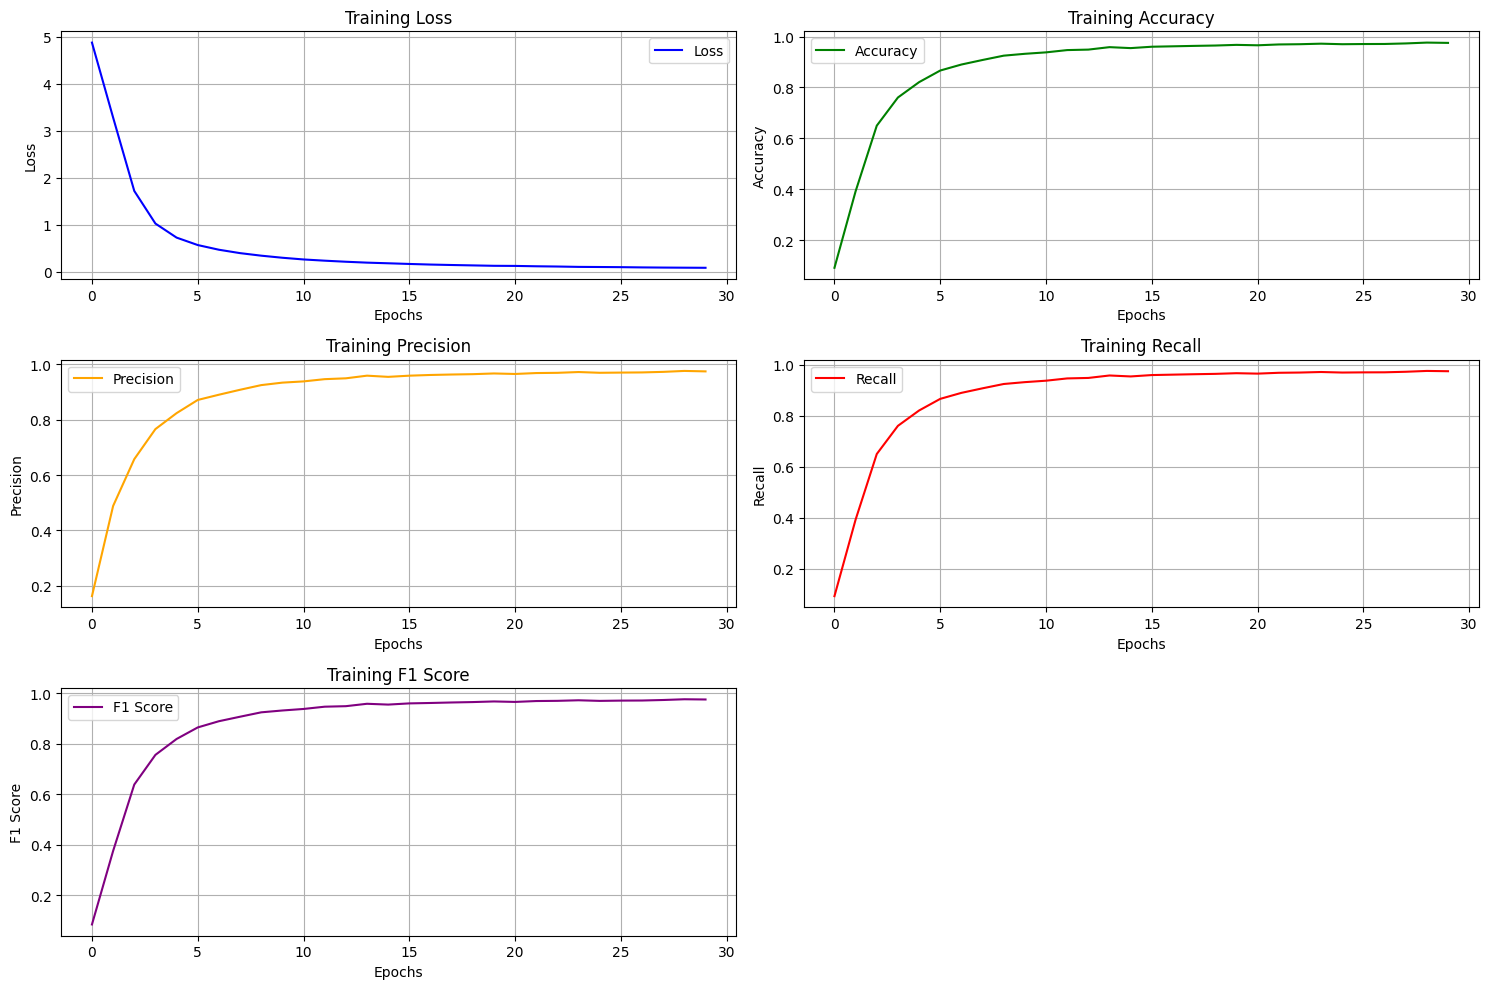

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# Plot Loss
plt.subplot(3, 2, 1)
plt.plot(history['loss'], label='Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(3, 2, 2)
plt.plot(history['accuracy'], label='Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)

# Plot Precision
plt.subplot(3, 2, 3)
plt.plot(history['precision'], label='Precision', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training Precision')
plt.legend()
plt.grid(True)

# Plot Recall
plt.subplot(3, 2, 4)
plt.plot(history['recall'], label='Recall', color='red')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training Recall')
plt.legend()
plt.grid(True)

# Plot F1 Score
plt.subplot(3, 2, 5)
plt.plot(history['f1'], label='F1 Score', color='purple')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training F1 Score')
plt.legend()
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset
import torchvision.transforms.functional as F
from skimage.feature import hog
import numpy as np

# Custom function to flatten, extend with projections, add HoG, and then normalize

image_size = 10

def flatten_extend_hog_and_normalize(img):
    img = img.view(image_size, image_size).numpy()  # Convert the image to a NumPy array with shape (28, 28)

    # Calculate horizontal and vertical projections
    vertical_projection = img.sum(axis=1)  # Sum over columns to get vertical projection (28,)
    horizontal_projection = img.sum(axis=0)  # Sum over rows to get horizontal projection (28,)

    # Rotate the image by 30 degrees for angular projection
    rotated_img = F.rotate(torch.tensor(img).unsqueeze(0), angle=30, fill=0)  # Rotate the image by 30 degrees
    rotated_img = rotated_img.squeeze(0).numpy()  # Convert the rotated image back to NumPy array
    angular_projection = rotated_img.sum(axis=0)  # Sum over rows of the rotated image (28,)

    # Flatten the original image
    img_flat = img.flatten()  # Flatten the image to (784,)

    # Compute HoG features
    #hog_features = hog(img, pixels_per_cell=(4, 4), cells_per_block=(2, 2), feature_vector=True)
    hog_features, _ = hog(img, orientations=12, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # Concatenate all features
    extended_features = np.concatenate((img_flat, hog_features), axis=0)

    # Convert to tensor
    extended_features = torch.tensor(extended_features, dtype=torch.float32)

    # Normalize the extended feature vector
    norm = extended_features.norm(p=2)  # Calculate the L2 norm
    normalized_features = extended_features / norm  # Normalize the entire feature vector

    return normalized_features



# Define the transform to resize, inspect size, flatten, and normalize the images
# transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
#     transforms.Resize((image_size, image_size)),  # Resize all images to 28x28 pixels
#     transforms.ToTensor(),  # Convert to tensor
#     transforms.Lambda(flatten_extend_hog_and_normalize)  # Flatten, extend with projections, add HoG, and normalize
# ])

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((image_size, image_size)),  # Resize all images to 28x28 pixels
#    transforms.RandomRotation(10),  # Randomly rotate by 10 degrees
#    transforms.RandomResizedCrop(size=image_size, scale=(0.9, 1.1)),  # Random scaling
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
#    transforms.Lambda(lambda x: x + 0.05 * torch.randn_like(x)),  # Adding noise
    transforms.Lambda(lambda x: x.squeeze()),  # Remove the channel dimension
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image to [784] elements

])



# Load the datasets with the defined transformation
train_dataset_all = datasets.ImageFolder(root='/content/data/train', transform=transform)
test_dataset_all = datasets.ImageFolder(root='/content/data/test', transform=transform)

# Randomly select 1000 images for training and 300 images for testing
train_indices = torch.randperm(len(train_dataset_all))[:2000]
test_indices = torch.randperm(len(test_dataset_all))[:600]

# Create subsets
train_dataset = Subset(train_dataset_all, train_indices)
test_dataset = Subset(test_dataset_all, test_indices)

# # Create DataLoaders
# train_loader = DataLoader(train_dataset_all, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset_all, batch_size=32, shuffle=False)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
for images, targets in train_loader:
    print("Flattened and Normalized Images shape:", images.shape)
    print("Targets shape:", targets.shape)
    break  # Only need to check the first batch

Flattened and Normalized Images shape: torch.Size([32, 100])
Targets shape: torch.Size([32])


In [ ]:
import numpy as np

# Extract all labels from the dataset
all_labels = [label for _, label in train_dataset_all]

# Get the unique labels using numpy
unique_labels = np.unique(all_labels)

# Count the number of unique labels
num_unique_labels = len(unique_labels)

print("Number of unique labels in train_dataset_all:", num_unique_labels)
#print("Unique labels:", unique_labels)


Number of unique labels in train_dataset_all: 170


image_size  8


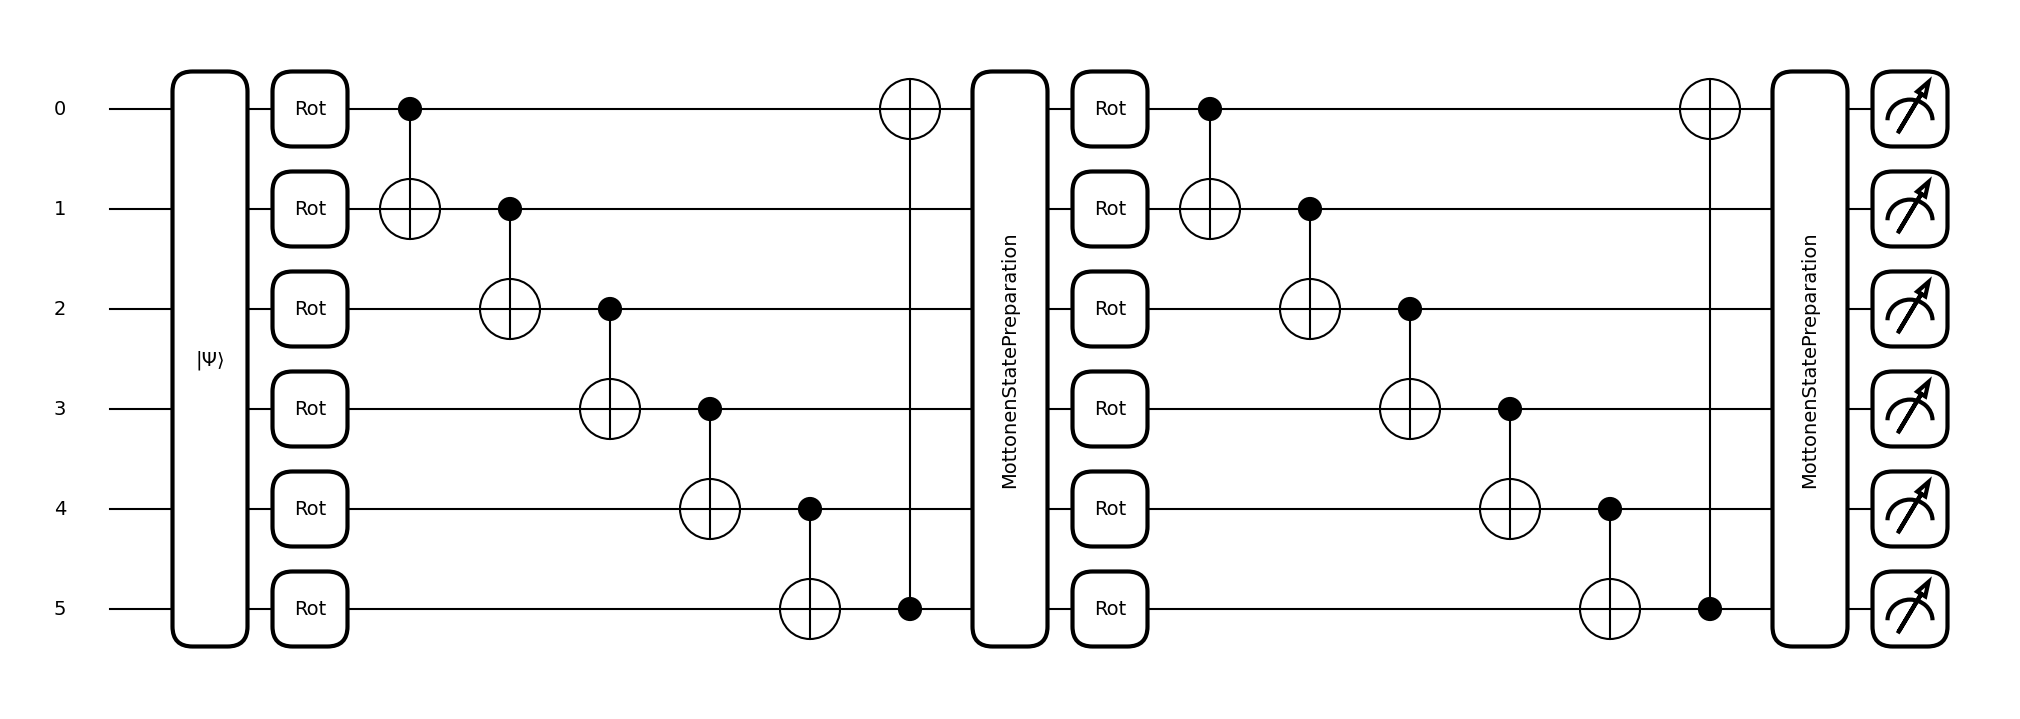

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-12-f6477dce771e>:129: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:305.)
  q_result = q_result.clone().detach().to(torch.float32).to(x.device)  # Safely clone and move to GPU


No checkpoint found at /content/sample_data/checkpoint.pth.tar. Starting from scratch.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/75 - Loss: 4.5376 - Accuracy: 0.0588 - Precision: 0.1007 - Recall: 0.0588 - F1: 0.0445


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  27.058823529411764 precision_test-  0.19537248667817292 recall_test-  0.27058823529411763 f1 test-  0.18786717150025253
Checkpoint saved at epoch 1.
Epoch 2/75 - Loss: 1.6510 - Accuracy: 0.4976 - Precision: 0.5140 - Recall: 0.4976 - F1: 0.4927


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  68.3529411764706 precision_test-  0.6557876029199557 recall_test-  0.6835294117647058 f1 test-  0.630848013676434
Checkpoint saved at epoch 2.
Epoch 3/75 - Loss: 0.4785 - Accuracy: 0.7581 - Precision: 0.7647 - Recall: 0.7581 - F1: 0.7590


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  75.76470588235294 precision_test-  0.7466634835752483 recall_test-  0.7576470588235293 f1 test-  0.7238974409920597
Checkpoint saved at epoch 3.
Epoch 4/75 - Loss: 0.2767 - Accuracy: 0.8367 - Precision: 0.8390 - Recall: 0.8367 - F1: 0.8366


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  81.05882352941177 precision_test-  0.8156605649252707 recall_test-  0.8105882352941177 f1 test-  0.7868212368986363
Checkpoint saved at epoch 4.
Epoch 5/75 - Loss: 0.2194 - Accuracy: 0.8567 - Precision: 0.8596 - Recall: 0.8567 - F1: 0.8573


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  84.70588235294117 precision_test-  0.8385130718954248 recall_test-  0.8470588235294118 f1 test-  0.8220728084245459
Checkpoint saved at epoch 5.
Epoch 6/75 - Loss: 0.1742 - Accuracy: 0.8821 - Precision: 0.8842 - Recall: 0.8821 - F1: 0.8824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  84.94117647058823 precision_test-  0.8531580510992275 recall_test-  0.8494117647058824 f1 test-  0.8310287436250925
Checkpoint saved at epoch 6.
Epoch 7/75 - Loss: 0.1421 - Accuracy: 0.8972 - Precision: 0.8995 - Recall: 0.8972 - F1: 0.8977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  86.94117647058823 precision_test-  0.8666944656650538 recall_test-  0.8694117647058824 f1 test-  0.8512603598671711
Checkpoint saved at epoch 7.
Epoch 8/75 - Loss: 0.1267 - Accuracy: 0.9089 - Precision: 0.9104 - Recall: 0.9089 - F1: 0.9089


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  87.88235294117646 precision_test-  0.8844327731092435 recall_test-  0.8788235294117648 f1 test-  0.8642041119203748
Checkpoint saved at epoch 8.
Epoch 9/75 - Loss: 0.1242 - Accuracy: 0.9054 - Precision: 0.9074 - Recall: 0.9054 - F1: 0.9058


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  89.17647058823529 precision_test-  0.8949910748613169 recall_test-  0.8917647058823529 f1 test-  0.8800760542802065
Checkpoint saved at epoch 9.
Epoch 10/75 - Loss: 0.0993 - Accuracy: 0.9235 - Precision: 0.9250 - Recall: 0.9235 - F1: 0.9238


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  89.88235294117646 precision_test-  0.8952264239028945 recall_test-  0.8988235294117648 f1 test-  0.8851947072535308
Checkpoint saved at epoch 10.
Epoch 11/75 - Loss: 0.1050 - Accuracy: 0.9158 - Precision: 0.9173 - Recall: 0.9158 - F1: 0.9160


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  88.3529411764706 precision_test-  0.8877614379084968 recall_test-  0.8835294117647058 f1 test-  0.8703635580106168
Checkpoint saved at epoch 11.
Epoch 12/75 - Loss: 0.0943 - Accuracy: 0.9245 - Precision: 0.9259 - Recall: 0.9245 - F1: 0.9248


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  89.29411764705883 precision_test-  0.9029318394024276 recall_test-  0.8929411764705883 f1 test-  0.880977048407389
Checkpoint saved at epoch 12.
Epoch 13/75 - Loss: 0.0811 - Accuracy: 0.9329 - Precision: 0.9339 - Recall: 0.9329 - F1: 0.9329


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  91.41176470588235 precision_test-  0.9125350140056022 recall_test-  0.9141176470588237 f1 test-  0.9048604989781461
Checkpoint saved at epoch 13.
Epoch 14/75 - Loss: 0.0763 - Accuracy: 0.9374 - Precision: 0.9390 - Recall: 0.9374 - F1: 0.9376


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  91.52941176470588 precision_test-  0.919150865474395 recall_test-  0.9152941176470589 f1 test-  0.907209293974
Checkpoint saved at epoch 14.
Epoch 15/75 - Loss: 0.0711 - Accuracy: 0.9379 - Precision: 0.9387 - Recall: 0.9379 - F1: 0.9380


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  91.29411764705883 precision_test-  0.9173866819455053 recall_test-  0.9129411764705881 f1 test-  0.904258274405333
Checkpoint saved at epoch 15.
Epoch 16/75 - Loss: 0.0637 - Accuracy: 0.9478 - Precision: 0.9487 - Recall: 0.9478 - F1: 0.9477


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  90.3529411764706 precision_test-  0.9068062982768865 recall_test-  0.9035294117647058 f1 test-  0.8934470268293798
Checkpoint saved at epoch 16.
Epoch 17/75 - Loss: 0.0700 - Accuracy: 0.9393 - Precision: 0.9403 - Recall: 0.9393 - F1: 0.9393


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  93.05882352941177 precision_test-  0.9358053221288515 recall_test-  0.9305882352941176 f1 test-  0.9250905166385043
Checkpoint saved at epoch 17.
Epoch 18/75 - Loss: 0.0722 - Accuracy: 0.9339 - Precision: 0.9350 - Recall: 0.9339 - F1: 0.9340


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  92.82352941176471 precision_test-  0.9282918552036198 recall_test-  0.9282352941176472 f1 test-  0.9193613764975994
Checkpoint saved at epoch 18.
Epoch 19/75 - Loss: 0.0569 - Accuracy: 0.9515 - Precision: 0.9523 - Recall: 0.9515 - F1: 0.9517


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  89.52941176470588 precision_test-  0.9053932178932178 recall_test-  0.8952941176470588 f1 test-  0.8842869248055008
Checkpoint saved at epoch 19.
Epoch 20/75 - Loss: 0.0626 - Accuracy: 0.9456 - Precision: 0.9464 - Recall: 0.9456 - F1: 0.9457


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  90.23529411764706 precision_test-  0.8992232277526394 recall_test-  0.9023529411764706 f1 test-  0.8919027377850907
Checkpoint saved at epoch 20.
Epoch 21/75 - Loss: 0.0631 - Accuracy: 0.9428 - Precision: 0.9438 - Recall: 0.9428 - F1: 0.9429


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  88.70588235294117 precision_test-  0.8890590781767254 recall_test-  0.8870588235294118 f1 test-  0.8735795077663591
Checkpoint saved at epoch 21.
Epoch 22/75 - Loss: 0.0542 - Accuracy: 0.9466 - Precision: 0.9469 - Recall: 0.9466 - F1: 0.9465


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  92.82352941176471 precision_test-  0.9310877684407096 recall_test-  0.9282352941176469 f1 test-  0.9225058275058275
Checkpoint saved at epoch 22.
Epoch 23/75 - Loss: 0.0665 - Accuracy: 0.9449 - Precision: 0.9451 - Recall: 0.9449 - F1: 0.9447


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  92.11764705882354 precision_test-  0.9248459383753503 recall_test-  0.9211764705882353 f1 test-  0.9130609586491938
Checkpoint saved at epoch 23.
Epoch 24/75 - Loss: 0.0496 - Accuracy: 0.9541 - Precision: 0.9549 - Recall: 0.9541 - F1: 0.9542


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  91.6470588235294 precision_test-  0.9111985400220693 recall_test-  0.9164705882352941 f1 test-  0.9031913210628382
Checkpoint saved at epoch 24.
Epoch 25/75 - Loss: 0.0535 - Accuracy: 0.9499 - Precision: 0.9507 - Recall: 0.9499 - F1: 0.9500


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  94.3529411764706 precision_test-  0.9489262371615312 recall_test-  0.943529411764706 f1 test-  0.939966569378334
Checkpoint saved at epoch 25.
Epoch 26/75 - Loss: 0.0499 - Accuracy: 0.9518 - Precision: 0.9522 - Recall: 0.9518 - F1: 0.9518


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  91.6470588235294 precision_test-  0.9204971988795518 recall_test-  0.9164705882352941 f1 test-  0.9091595409588489
Checkpoint saved at epoch 26.
Epoch 27/75 - Loss: 0.0590 - Accuracy: 0.9480 - Precision: 0.9492 - Recall: 0.9480 - F1: 0.9482


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  93.05882352941177 precision_test-  0.9289705882352942 recall_test-  0.9305882352941177 f1 test-  0.9219758672699848
Checkpoint saved at epoch 27.
Epoch 28/75 - Loss: 0.0436 - Accuracy: 0.9602 - Precision: 0.9603 - Recall: 0.9602 - F1: 0.9601


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  93.05882352941177 precision_test-  0.9362955182072827 recall_test-  0.9305882352941176 f1 test-  0.9237865402571286
Checkpoint saved at epoch 28.
Epoch 29/75 - Loss: 0.0513 - Accuracy: 0.9522 - Precision: 0.9529 - Recall: 0.9522 - F1: 0.9524


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  92.3529411764706 precision_test-  0.9216036414565826 recall_test-  0.9235294117647059 f1 test-  0.9135286797825497
Checkpoint saved at epoch 29.
Epoch 30/75 - Loss: 0.0552 - Accuracy: 0.9456 - Precision: 0.9464 - Recall: 0.9456 - F1: 0.9458


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  92.58823529411765 precision_test-  0.9286303239244416 recall_test-  0.9258823529411765 f1 test-  0.9177077497665734
Checkpoint saved at epoch 30.
Epoch 31/75 - Loss: 0.0685 - Accuracy: 0.9358 - Precision: 0.9363 - Recall: 0.9358 - F1: 0.9358


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  92.58823529411765 precision_test-  0.9303851540616247 recall_test-  0.9258823529411765 f1 test-  0.9182924265277206
Checkpoint saved at epoch 31.
Epoch 32/75 - Loss: 0.0479 - Accuracy: 0.9539 - Precision: 0.9542 - Recall: 0.9539 - F1: 0.9538


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  91.41176470588235 precision_test-  0.9158496732026145 recall_test-  0.9141176470588236 f1 test-  0.902486127563527
Checkpoint saved at epoch 32.
Epoch 33/75 - Loss: 0.0476 - Accuracy: 0.9569 - Precision: 0.9581 - Recall: 0.9569 - F1: 0.9571


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  94.82352941176471 precision_test-  0.942044817927171 recall_test-  0.948235294117647 f1 test-  0.942058823529412
Checkpoint saved at epoch 33.
Epoch 34/75 - Loss: 0.0378 - Accuracy: 0.9642 - Precision: 0.9645 - Recall: 0.9642 - F1: 0.9642


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  94.11764705882354 precision_test-  0.9385224089635854 recall_test-  0.9411764705882353 f1 test-  0.9342332040164857
Checkpoint saved at epoch 34.
Epoch 35/75 - Loss: 0.0328 - Accuracy: 0.9687 - Precision: 0.9694 - Recall: 0.9687 - F1: 0.9688


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  92.47058823529412 precision_test-  0.9104598506069095 recall_test-  0.9247058823529412 f1 test-  0.9119172983878866
Checkpoint saved at epoch 35.
Epoch 36/75 - Loss: 0.0457 - Accuracy: 0.9527 - Precision: 0.9534 - Recall: 0.9527 - F1: 0.9528


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  90.11764705882354 precision_test-  0.9034622566975509 recall_test-  0.9011764705882352 f1 test-  0.8889165813041245
Checkpoint saved at epoch 36.
Epoch 37/75 - Loss: 0.0391 - Accuracy: 0.9600 - Precision: 0.9610 - Recall: 0.9600 - F1: 0.9602


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  92.0 precision_test-  0.9135060690943044 recall_test-  0.92 f1 test-  0.9062222821392371
Checkpoint saved at epoch 37.
Epoch 38/75 - Loss: 0.0499 - Accuracy: 0.9534 - Precision: 0.9538 - Recall: 0.9534 - F1: 0.9535


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  92.58823529411765 precision_test-  0.9291013071895423 recall_test-  0.9258823529411765 f1 test-  0.9193500290559113
Checkpoint saved at epoch 38.
Epoch 39/75 - Loss: 0.0478 - Accuracy: 0.9553 - Precision: 0.9558 - Recall: 0.9553 - F1: 0.9553


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  92.82352941176471 precision_test-  0.9302521008403359 recall_test-  0.9282352941176472 f1 test-  0.9191838630419946
Checkpoint saved at epoch 39.
Epoch 40/75 - Loss: 0.0417 - Accuracy: 0.9562 - Precision: 0.9571 - Recall: 0.9562 - F1: 0.9563


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  93.05882352941177 precision_test-  0.9294724556489262 recall_test-  0.9305882352941176 f1 test-  0.9231491461249247
Checkpoint saved at epoch 40.
Epoch 41/75 - Loss: 0.0638 - Accuracy: 0.9445 - Precision: 0.9451 - Recall: 0.9445 - F1: 0.9446


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  91.05882352941177 precision_test-  0.9155345471521942 recall_test-  0.9105882352941177 f1 test-  0.9004491173449468
Checkpoint saved at epoch 41.
Epoch 42/75 - Loss: 0.0227 - Accuracy: 0.9741 - Precision: 0.9744 - Recall: 0.9741 - F1: 0.9741


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  95.05882352941177 precision_test-  0.9439775910364145 recall_test-  0.9505882352941177 f1 test-  0.9444071941130764
Checkpoint saved at epoch 42.
Epoch 43/75 - Loss: 0.0196 - Accuracy: 0.9760 - Precision: 0.9762 - Recall: 0.9760 - F1: 0.9758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  95.41176470588235 precision_test-  0.9531839402427638 recall_test-  0.9541176470588235 f1 test-  0.949270011034717
Checkpoint saved at epoch 43.
Epoch 44/75 - Loss: 0.0185 - Accuracy: 0.9751 - Precision: 0.9754 - Recall: 0.9751 - F1: 0.9747


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  95.05882352941177 precision_test-  0.9480158730158731 recall_test-  0.9505882352941177 f1 test-  0.9458383120147825
Checkpoint saved at epoch 44.
Epoch 45/75 - Loss: 0.0178 - Accuracy: 0.9784 - Precision: 0.9790 - Recall: 0.9784 - F1: 0.9784


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  95.29411764705883 precision_test-  0.9509721161191749 recall_test-  0.9529411764705882 f1 test-  0.9487064079711138
Checkpoint saved at epoch 45.
Epoch 46/75 - Loss: 0.0182 - Accuracy: 0.9765 - Precision: 0.9768 - Recall: 0.9765 - F1: 0.9765


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  94.70588235294117 precision_test-  0.9515873015873015 recall_test-  0.9470588235294117 f1 test-  0.9444165311812373
Checkpoint saved at epoch 46.
Epoch 47/75 - Loss: 0.0181 - Accuracy: 0.9772 - Precision: 0.9777 - Recall: 0.9772 - F1: 0.9772


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  94.94117647058823 precision_test-  0.9480042016806722 recall_test-  0.9494117647058824 f1 test-  0.944945054945055
Checkpoint saved at epoch 47.
Epoch 48/75 - Loss: 0.0187 - Accuracy: 0.9744 - Precision: 0.9747 - Recall: 0.9744 - F1: 0.9744


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  95.17647058823529 precision_test-  0.9557329598506069 recall_test-  0.951764705882353 f1 test-  0.9479849888673417
Checkpoint saved at epoch 48.
Epoch 49/75 - Loss: 0.0175 - Accuracy: 0.9767 - Precision: 0.9771 - Recall: 0.9767 - F1: 0.9766


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  93.52941176470588 precision_test-  0.9332773109243697 recall_test-  0.9352941176470588 f1 test-  0.9281012778071601
Checkpoint saved at epoch 49.
Epoch 50/75 - Loss: 0.0182 - Accuracy: 0.9751 - Precision: 0.9754 - Recall: 0.9751 - F1: 0.9749


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  94.11764705882354 precision_test-  0.9384173669467787 recall_test-  0.9411764705882353 f1 test-  0.9346880896880898
Checkpoint saved at epoch 50.
Epoch 51/75 - Loss: 0.0175 - Accuracy: 0.9781 - Precision: 0.9784 - Recall: 0.9781 - F1: 0.9781


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  94.70588235294117 precision_test-  0.9485690943043883 recall_test-  0.9470588235294117 f1 test-  0.9413409466350642
Checkpoint saved at epoch 51.
Epoch 52/75 - Loss: 0.0183 - Accuracy: 0.9741 - Precision: 0.9744 - Recall: 0.9741 - F1: 0.9741


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_test-  95.41176470588235 precision_test-  0.9522816399286986 recall_test-  0.9541176470588236 f1 test-  0.9499866310160427
Checkpoint saved at epoch 52.


In [ ]:
# Step 1: Install Required Packages
#!pip install pennylane pennylane-lightning-gpu torch torchvision matplotlib scikit-learn

import pennylane as qml
from pennylane import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from google.colab import files


# Define a function to save the model
def save_checkpoint(epoch, model, optimizer, scheduler,  filename="/content/sample_data/checkpoint.pth.tar"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }
    torch.save(checkpoint, filename)
    #files.download(filename)
    print(f"Checkpoint saved at epoch {epoch}.")

# Define a function to load the model
def load_checkpoint(model, optimizer, scheduler, filename="/content/sample_data/checkpoint.pth.tar"):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}.")
    else:
        print(f"No checkpoint found at {filename}. Starting from scratch.")
        start_epoch = 0
    return start_epoch


# Step 5: Move Model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Step 3: Set Up the Quantum Device with lightning.qubit and GPU
print("image_size ", image_size)
n_pixels = image_size * image_size  # Total number of pixels in the image (784 for 28x28)
n_qubits = int(np.ceil(np.log2(n_pixels)))  # Number of qubits needed for amplitude encoding
L = 1  # Number of repetitions of the quantum layer

# Use lightning.qubit device with GPU support
dev = qml.device("lightning.qubit", wires=n_qubits)

# Define the combined quantum circuit
@qml.qnode(dev, interface="torch")
def combined_quantum_circuit(inputs, attention_weights, weights, attention_weights2, weights2):
    # Step 1: Amplitude encoding of the input data
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), pad_with=0.0, normalize=True)

    # Step 2: First quantum layer
    for l in range(weights.shape[0]):  # Assuming L is the first dimension of weights
        for i in range(n_qubits):
            qml.Rot(weights[l, i, 0], weights[l, i, 1], weights[l, i, 2], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[n_qubits - 1, 0])

    # Step 3: Apply the first set of attention weights
    norm_value = torch.linalg.norm(attention_weights, ord=2)
    attention_weights = attention_weights / norm_value
    attention_weights_np = attention_weights.detach().cpu().numpy()
    qml.MottonenStatePreparation(attention_weights_np, wires=range(n_qubits))

    # Step 4: Second quantum layer
    for l in range(weights2.shape[0]):  # Assuming L is the first dimension of weights2
        for i in range(n_qubits):
            qml.Rot(weights2[l, i, 0], weights2[l, i, 1], weights2[l, i, 2], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[n_qubits - 1, 0])

    # Step 5: Apply the second set of attention weights
    norm_value2 = torch.linalg.norm(attention_weights2, ord=2)
    attention_weights2 = attention_weights2 / norm_value2
    attention_weights2_np = attention_weights2.detach().cpu().numpy()
    qml.MottonenStatePreparation(attention_weights2_np, wires=range(n_qubits))

    # Return the full statevector
    return qml.state()



# Example input for drawing the circuit
# Example input for drawing the circuit
example_input = torch.rand(n_pixels).cpu().numpy()  # Ensure the input is a NumPy array
example_attention_weights1 = torch.rand(2**n_qubits, dtype=torch.float32).to(device)  # Randomly initialized attention weights on the correct device
example_attention_weights2 = torch.rand(2**n_qubits, dtype=torch.float32).to(device)  # Second attention weights
example_weights1 = torch.rand(L, n_qubits, 3, dtype=torch.float32).to(device)  # Randomly initialized weights on the correct device
example_weights2 = torch.rand(L, n_qubits, 3, dtype=torch.float32).to(device)  # Second quantum layer weights

# Draw the circuit
qml.draw_mpl(combined_quantum_circuit)(example_input, example_attention_weights1, example_weights1, example_attention_weights2, example_weights2)
plt.show()



# Step 4: Define the Hybrid Quantum-Classical Model
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.q_weights1 = nn.Parameter(0.01 * torch.randn(L, n_qubits, 3, dtype=torch.float32))  # First quantum layer weights
        self.q_weights2 = nn.Parameter(0.01 * torch.randn(L, n_qubits, 3, dtype=torch.float32))  # Second quantum layer weights

        self.attention_weights1 = nn.Parameter(0.01 * torch.randn(2**n_qubits, dtype=torch.float32))  # First attention weights
        self.attention_weights2 = nn.Parameter(0.01 * torch.randn(2**n_qubits, dtype=torch.float32))  # Second attention weights

        self.fc1 = nn.Linear(2**n_qubits, 512)  # First classical layer (increased size)
        self.fc2 = nn.Linear(512, 256)          # Second classical layer
        self.fc3 = nn.Linear(256, 170)          # Output layer for 170 classes

    def forward(self, x):
        q_out= []

        for i in range(x.size(0)):
            q_result = combined_quantum_circuit(x[i], self.attention_weights1, self.q_weights1, self.attention_weights2, self.q_weights2)
            q_result = q_result.clone().detach().to(torch.float32).to(x.device)  # Safely clone and move to GPU
            q_out.append(q_result)



        q_out = torch.stack(q_out)  # Shape: [batch_size, 2^n_qubits]

        # Pass through classical layers
        x = self.fc1(q_out)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Step 5: Move Model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel().to(device)

# Step 7: Evaluate the Model on GPU and Calculate Metrics
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for data, targets in test_loader:
            data = data.float().to(device)  # Ensure data is a float tensor and move to GPU
            targets = targets.long().to(device)  # Move targets to GPU
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    # print(f'Accuracy: {accuracy}%')
    # print(f'Precision: {precision:.4f}')
    # print(f'Recall: {recall:.4f}')
    # print(f'F1 Score: {f1:.4f}')
    return accuracy, precision, recall, f1



def test_model_with_analysis(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_targets = []
    all_preds = []
    misclassified_images = []
    misclassified_preds = []
    misclassified_labels = []

    with torch.no_grad():
        for data, targets in test_loader:
            data = data.float().to(device)  # Ensure data is a float tensor and move to GPU
            targets = targets.long().to(device)  # Move targets to GPU
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Identify misclassifications
            for i in range(len(predicted)):
                if predicted[i] != targets[i]:
                    misclassified_images.append(data[i].cpu().numpy())
                    misclassified_preds.append(predicted[i].cpu().numpy())
                    misclassified_labels.append(targets[i].cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    print(f'Accuracy: {accuracy}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    return accuracy, precision, recall, f1, misclassified_images, misclassified_preds, misclassified_labels


# Step 6: Train the Model on GPU and Track Metrics
# def train_model(model, train_loader, criterion, optimizer,scheduler, epochs=5):
#     model.train()
#     history = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

#     for epoch in range(epochs):
#         total_loss = 0
#         all_targets = []
#         all_preds = []

#         for data, targets in train_loader:
#             data = data.float().to(device)  # Ensure data is a float tensor and move to GPU
#             targets = targets.long().to(device)  # Ensure targets are long tensors and move to GPU
#             optimizer.zero_grad()
#             output = model(data)
#             loss = criterion(output, targets)
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()
#             _, preds = torch.max(output, 1)
#             all_targets.extend(targets.cpu().numpy())
#             all_preds.extend(preds.cpu().numpy())

#         # Calculate metrics
#         precision = precision_score(all_targets, all_preds, average='macro')
#         recall = recall_score(all_targets, all_preds, average='macro')
#         f1 = f1_score(all_targets, all_preds, average='macro')
#         accuracy = (np.array(all_preds) == np.array(all_targets)).mean()

#         avg_loss = total_loss / len(train_loader)
#         history['loss'].append(avg_loss)
#         history['accuracy'].append(accuracy)
#         history['precision'].append(precision)
#         history['recall'].append(recall)
#         history['f1'].append(f1)

#         print(f'Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')

#         #accuracy_test, precision_test, recall_test, f1_test = test_model(model, test_loader)
#         #print("accuracy_test- ",accuracy_test, "precision_test- ", precision_test, "recall_test- ",recall_test, "f1 test- ",f1_test)
#         scheduler.step(avg_loss)

#     return history

# Step 6: Train the Model on GPU and Track Metrics
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=5, start_epoch=0):
    model.train()
    history = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for epoch in range(start_epoch, epochs):
        total_loss = 0
        all_targets = []
        all_preds = []

        for data, targets in train_loader:
            data = data.float().to(device)  # Ensure data is a float tensor and move to GPU
            targets = targets.long().to(device)  # Ensure targets are long tensors and move to GPU
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(output, 1)
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        # Calculate metrics
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')
        accuracy = (np.array(all_preds) == np.array(all_targets)).mean()

        avg_loss = total_loss / len(train_loader)
        history['loss'].append(avg_loss)
        history['accuracy'].append(accuracy)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)

        print(f'Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')

        accuracy_test, precision_test, recall_test, f1_test = test_model(model, test_loader)
        print("accuracy_test- ",accuracy_test, "precision_test- ", precision_test, "recall_test- ",recall_test, "f1 test- ",f1_test)

        # Save the model after every epoch
        save_checkpoint(epoch + 1, model, optimizer, scheduler)

        # Step the scheduler
        scheduler.step(avg_loss)

    return history

# Initialize the criterion and optimizer
from pytorch_toolbelt.losses import CrossEntropyFocalLoss

criterion = CrossEntropyFocalLoss(gamma=2.0, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Implement learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Load the checkpoint if it exists
start_epoch = load_checkpoint(model, optimizer, scheduler)


# Train the model
#history2 = train_model(model, train_loader, criterion, optimizer, scheduler, epochs=21)
history2 = train_model(model, train_loader, criterion, optimizer, scheduler, epochs=75, start_epoch=start_epoch)


# Test the model and analyze mistakes
accuracy, precision, recall, f1, misclassified_images, misclassified_preds, misclassified_labels = test_model_with_analysis(model, test_loader)



#accuracy, precision, recall, f1 = test_model(model, test_loader)


In [ ]:
import re

data = """
Epoch 1/50 - Loss: 4.7632 - Accuracy: 0.0785 - Precision: 0.0971 - Recall: 0.0676 - F1: 0.0582
Checkpoint saved at epoch 1.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch 2/50 - Loss: 2.2299 - Accuracy: 0.3730 - Precision: 0.4218 - Recall: 0.3454 - F1: 0.3312
Checkpoint saved at epoch 2.
Epoch 3/50 - Loss: 0.6223 - Accuracy: 0.6905 - Precision: 0.6935 - Recall: 0.6785 - F1: 0.6766
Checkpoint saved at epoch 3.
Epoch 4/50 - Loss: 0.3302 - Accuracy: 0.7905 - Precision: 0.7996 - Recall: 0.7877 - F1: 0.7887
Checkpoint saved at epoch 4.
Epoch 5/50 - Loss: 0.2389 - Accuracy: 0.8405 - Precision: 0.8470 - Recall: 0.8385 - F1: 0.8398
Checkpoint saved at epoch 5.
Epoch 6/50 - Loss: 0.1782 - Accuracy: 0.8720 - Precision: 0.8788 - Recall: 0.8730 - F1: 0.8741
Checkpoint saved at epoch 6.
Epoch 7/50 - Loss: 0.1500 - Accuracy: 0.8890 - Precision: 0.8947 - Recall: 0.8901 - F1: 0.8905
Checkpoint saved at epoch 7.
Epoch 8/50 - Loss: 0.1112 - Accuracy: 0.9155 - Precision: 0.9208 - Recall: 0.9168 - F1: 0.9170
Checkpoint saved at epoch 8.
Epoch 9/50 - Loss: 0.1057 - Accuracy: 0.9175 - Precision: 0.9226 - Recall: 0.9199 - F1: 0.9202
Checkpoint saved at epoch 9.
Epoch 10/50 - Loss: 0.0990 - Accuracy: 0.9280 - Precision: 0.9338 - Recall: 0.9294 - F1: 0.9302
Checkpoint saved at epoch 10.
Epoch 11/50 - Loss: 0.0802 - Accuracy: 0.9325 - Precision: 0.9350 - Recall: 0.9327 - F1: 0.9322
Checkpoint saved at epoch 11.
Epoch 12/50 - Loss: 0.0698 - Accuracy: 0.9420 - Precision: 0.9483 - Recall: 0.9429 - F1: 0.9445
Checkpoint saved at epoch 12.
Epoch 13/50 - Loss: 0.0761 - Accuracy: 0.9300 - Precision: 0.9345 - Recall: 0.9334 - F1: 0.9334
Checkpoint saved at epoch 13.
Epoch 14/50 - Loss: 0.0547 - Accuracy: 0.9510 - Precision: 0.9529 - Recall: 0.9525 - F1: 0.9518
Checkpoint saved at epoch 14.
Epoch 15/50 - Loss: 0.0645 - Accuracy: 0.9460 - Precision: 0.9497 - Recall: 0.9483 - F1: 0.9485
Checkpoint saved at epoch 15.
Epoch 16/50 - Loss: 0.0568 - Accuracy: 0.9460 - Precision: 0.9482 - Recall: 0.9472 - F1: 0.9469
Checkpoint saved at epoch 16.
Epoch 17/50 - Loss: 0.0421 - Accuracy: 0.9605 - Precision: 0.9629 - Recall: 0.9611 - F1: 0.9608
Checkpoint saved at epoch 17.
Epoch 18/50 - Loss: 0.0567 - Accuracy: 0.9455 - Precision: 0.9508 - Recall: 0.9492 - F1: 0.9491
Checkpoint saved at epoch 18.
Epoch 19/50 - Loss: 0.0576 - Accuracy: 0.9440 - Precision: 0.9471 - Recall: 0.9454 - F1: 0.9456
Checkpoint saved at epoch 19.
Epoch 20/50 - Loss: 0.0580 - Accuracy: 0.9520 - Precision: 0.9543 - Recall: 0.9532 - F1: 0.9532
Checkpoint saved at epoch 20.
Epoch 21/50 - Loss: 0.0525 - Accuracy: 0.9535 - Precision: 0.9571 - Recall: 0.9563 - F1: 0.9558
Checkpoint saved at epoch 21.
Epoch 22/50 - Loss: 0.0635 - Accuracy: 0.9595 - Precision: 0.9615 - Recall: 0.9600 - F1: 0.9600
Checkpoint saved at epoch 22.
Epoch 23/50 - Loss: 0.0326 - Accuracy: 0.9680 - Precision: 0.9712 - Recall: 0.9696 - F1: 0.9699
Checkpoint saved at epoch 23.
Epoch 24/50 - Loss: 0.0450 - Accuracy: 0.9600 - Precision: 0.9639 - Recall: 0.9620 - F1: 0.9625
Checkpoint saved at epoch 24.
Epoch 25/50 - Loss: 0.0417 - Accuracy: 0.9590 - Precision: 0.9622 - Recall: 0.9615 - F1: 0.9614
Checkpoint saved at epoch 25.
Epoch 26/50 - Loss: 0.0528 - Accuracy: 0.9550 - Precision: 0.9578 - Recall: 0.9567 - F1: 0.9564
Checkpoint saved at epoch 26.
Epoch 27/50 - Loss: 0.0590 - Accuracy: 0.9510 - Precision: 0.9560 - Recall: 0.9540 - F1: 0.9542
Checkpoint saved at epoch 27.
Epoch 28/50 - Loss: 0.0610 - Accuracy: 0.9505 - Precision: 0.9535 - Recall: 0.9499 - F1: 0.9505
Checkpoint saved at epoch 28.
Epoch 29/50 - Loss: 0.0313 - Accuracy: 0.9665 - Precision: 0.9691 - Recall: 0.9681 - F1: 0.9678
Checkpoint saved at epoch 29.
Epoch 30/50 - Loss: 0.0439 - Accuracy: 0.9585 - Precision: 0.9616 - Recall: 0.9607 - F1: 0.9606
Checkpoint saved at epoch 30.
Epoch 31/50 - Loss: 0.0516 - Accuracy: 0.9530 - Precision: 0.9552 - Recall: 0.9542 - F1: 0.9539
Checkpoint saved at epoch 31.
Epoch 32/50 - Loss: 0.0511 - Accuracy: 0.9575 - Precision: 0.9600 - Recall: 0.9573 - F1: 0.9578
Checkpoint saved at epoch 32.
Epoch 33/50 - Loss: 0.0343 - Accuracy: 0.9615 - Precision: 0.9646 - Recall: 0.9613 - F1: 0.9622
Checkpoint saved at epoch 33.
Epoch 34/50 - Loss: 0.0277 - Accuracy: 0.9710 - Precision: 0.9723 - Recall: 0.9718 - F1: 0.9717
Checkpoint saved at epoch 34.
Epoch 35/50 - Loss: 0.0349 - Accuracy: 0.9630 - Precision: 0.9650 - Recall: 0.9644 - F1: 0.9643
Checkpoint saved at epoch 35.
Epoch 36/50 - Loss: 0.0410 - Accuracy: 0.9655 - Precision: 0.9667 - Recall: 0.9661 - F1: 0.9661
Checkpoint saved at epoch 36.
Epoch 37/50 - Loss: 0.0399 - Accuracy: 0.9605 - Precision: 0.9633 - Recall: 0.9618 - F1: 0.9622
Checkpoint saved at epoch 37.
Epoch 38/50 - Loss: 0.0310 - Accuracy: 0.9710 - Precision: 0.9739 - Recall: 0.9726 - F1: 0.9728
Checkpoint saved at epoch 38.
Epoch 39/50 - Loss: 0.0240 - Accuracy: 0.9715 - Precision: 0.9736 - Recall: 0.9733 - F1: 0.9731
Checkpoint saved at epoch 39.
Epoch 40/50 - Loss: 0.0205 - Accuracy: 0.9750 - Precision: 0.9768 - Recall: 0.9760 - F1: 0.9761
Checkpoint saved at epoch 40.
Epoch 41/50 - Loss: 0.0228 - Accuracy: 0.9720 - Precision: 0.9730 - Recall: 0.9728 - F1: 0.9723
Checkpoint saved at epoch 41.
Epoch 42/50 - Loss: 0.0162 - Accuracy: 0.9800 - Precision: 0.9812 - Recall: 0.9802 - F1: 0.9804
Checkpoint saved at epoch 42.
"""

# Regex pattern to extract epoch data
pattern = r'Epoch (\d+)/\d+ - Loss: ([\d\.]+) - Accuracy: ([\d\.]+) - Precision: ([\d\.]+) - Recall: ([\d\.]+) - F1: ([\d\.]+)'

# Find all matches
matches = re.findall(pattern, data)

# Assign extracted data to variable x
train_epochwise = [{
    "epoch": int(match[0]),
    "loss": float(match[1]),
    "accuracy": float(match[2]),
    "precision": float(match[3]),
    "recall": float(match[4]),
    "f1_score": float(match[5])
} for match in matches]

# Display the extracted data
for entry in train_epochwise:
    print(entry)



{'epoch': 1, 'loss': 4.7632, 'accuracy': 0.0785, 'precision': 0.0971, 'recall': 0.0676, 'f1_score': 0.0582}
{'epoch': 2, 'loss': 2.2299, 'accuracy': 0.373, 'precision': 0.4218, 'recall': 0.3454, 'f1_score': 0.3312}
{'epoch': 3, 'loss': 0.6223, 'accuracy': 0.6905, 'precision': 0.6935, 'recall': 0.6785, 'f1_score': 0.6766}
{'epoch': 4, 'loss': 0.3302, 'accuracy': 0.7905, 'precision': 0.7996, 'recall': 0.7877, 'f1_score': 0.7887}
{'epoch': 5, 'loss': 0.2389, 'accuracy': 0.8405, 'precision': 0.847, 'recall': 0.8385, 'f1_score': 0.8398}
{'epoch': 6, 'loss': 0.1782, 'accuracy': 0.872, 'precision': 0.8788, 'recall': 0.873, 'f1_score': 0.8741}
{'epoch': 7, 'loss': 0.15, 'accuracy': 0.889, 'precision': 0.8947, 'recall': 0.8901, 'f1_score': 0.8905}
{'epoch': 8, 'loss': 0.1112, 'accuracy': 0.9155, 'precision': 0.9208, 'recall': 0.9168, 'f1_score': 0.917}
{'epoch': 9, 'loss': 0.1057, 'accuracy': 0.9175, 'precision': 0.9226, 'recall': 0.9199, 'f1_score': 0.9202}
{'epoch': 10, 'loss': 0.099, 'accura

In [ ]:
import matplotlib.pyplot as plt

def find_image_with_label(loader, label):
    """Find the first image in the loader with the given label."""
    for data, targets in loader:
        for i in range(len(targets)):
            if targets[i].item() == label:
                return data[i][:784].cpu().numpy().reshape(image_size, image_size)
    return None

def plot_misclassified_images_with_true_examples(misclassified_images, misclassified_preds, misclassified_labels, train_loader, num_images=5):
    plt.figure(figsize=(5, 5 * num_images))
    for i in range(min(num_images, len(misclassified_images))):
        # Take only the first 784 pixels (assuming the images are flattened to 784 pixels)
        misclassified_image = misclassified_images[i][:784].reshape(image_size, image_size)
        predicted_label = misclassified_preds[i]
        true_label = misclassified_labels[i]

        # Find a true example of the ground truth label from the train_loader
        true_image_ground_truth = find_image_with_label(train_loader, true_label)

        # Find a true example of the predicted label from the train_loader
        true_image_predicted = find_image_with_label(train_loader, predicted_label)

        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(misclassified_image, cmap='gray')
        plt.title(f"Misclassified: True {true_label},\n Predicted {predicted_label}", fontsize=10)
        plt.axis('off')

        if true_image_ground_truth is not None:
            plt.subplot(num_images, 3, 3 * i + 2)
            plt.imshow(true_image_ground_truth, cmap='gray')
            plt.title(f"True Image of\n Label {true_label}", fontsize=10)
            plt.axis('off')
        else:
            plt.subplot(num_images, 3, 3 * i + 2)
            plt.text(0.5, 0.5, "No example found", horizontalalignment='center', verticalalignment='center', fontsize=10)
            plt.axis('off')

        if true_image_predicted is not None:
            plt.subplot(num_images, 3, 3 * i + 3)
            plt.imshow(true_image_predicted, cmap='gray')
            plt.title(f"True Image of\n Predicted Label {predicted_label}", fontsize=10)
            plt.axis('off')
        else:
            plt.subplot(num_images, 3, 3 * i + 3)
            plt.text(0.5, 0.5, "No example found", horizontalalignment='center', verticalalignment='center', fontsize=10)
            plt.axis('off')

    plt.tight_layout()
    plt.show()
# Plot the first few misclassified images
plot_misclassified_images_with_true_examples(misclassified_images, misclassified_preds, misclassified_labels, train_loader, num_images=10)


NameError: name 'misclassified_images' is not defined

In [ ]:
# Step 3: Extracting the data for plotting
epochs = [entry['epoch'] for entry in train_epochwise]
loss = [entry['loss'] for entry in train_epochwise]
accuracy = [entry['accuracy'] for entry in train_epochwise]
precision = [entry['precision'] for entry in train_epochwise]
recall = [entry['recall'] for entry in train_epochwise]
f1_score = [entry['f1_score'] for entry in train_epochwise]

# Step 4: Plotting and saving the data

# Plot Loss
plt.figure(figsize=(7, 5))
plt.plot(epochs, loss, label='Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.savefig('MAQNN_loss.png')  # Save the plot as "MAQNN_loss.png"
plt.close()  # Close the figure

# Plot Accuracy
plt.figure(figsize=(7, 5))
plt.plot(epochs, accuracy, label='Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('MAQNN_accuracy.png')  # Save the plot as "MAQNN_accuracy.png"
plt.close()

# Plot Precision
plt.figure(figsize=(7, 5))
plt.plot(epochs, precision, label='Precision', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training Precision')
plt.legend()
plt.grid(True)
plt.savefig('MAQNN_precision.png')  # Save the plot as "MAQNN_precision.png"
plt.close()

# Plot Recall
plt.figure(figsize=(7, 5))
plt.plot(epochs, recall, label='Recall', color='red')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training Recall')
plt.legend()
plt.grid(True)
plt.savefig('MAQNN_recall.png')  # Save the plot as "MAQNN_recall.png"
plt.close()

# Plot F1 Score
plt.figure(figsize=(7, 5))
plt.plot(epochs, f1_score, label='F1 Score', color='purple')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('MAQNN_f1_score.png')  # Save the plot as "MAQNN_f1_score.png"
plt.close()


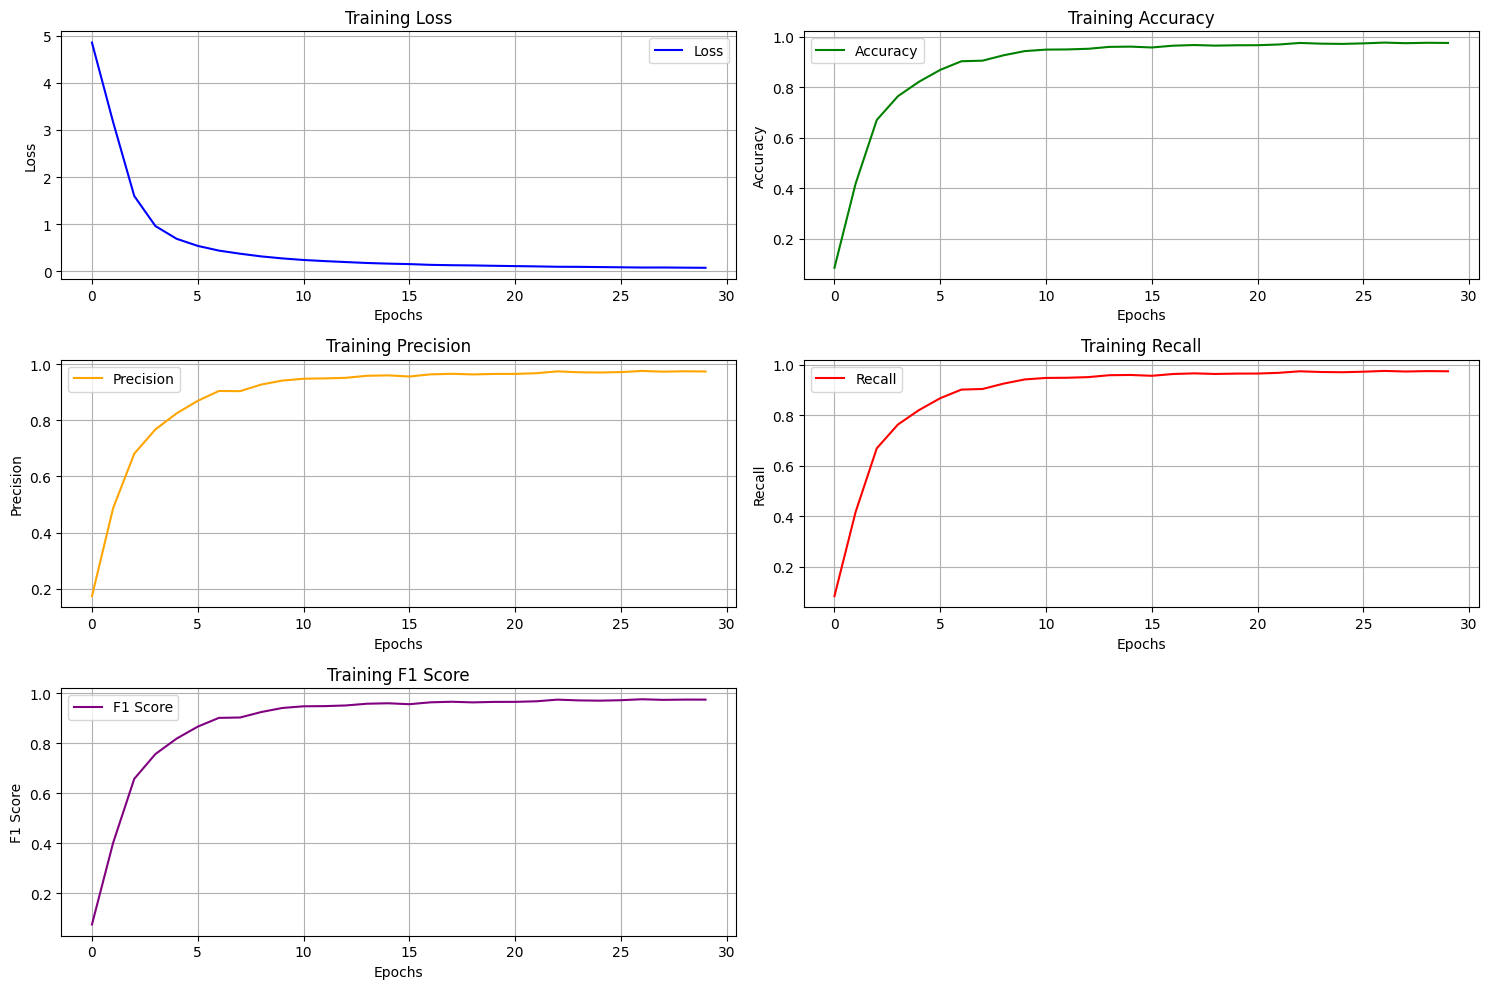

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# Plot Loss
plt.subplot(3, 2, 1)
plt.plot(history2['loss'], label='Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(3, 2, 2)
plt.plot(history2['accuracy'], label='Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)

# Plot Precision
plt.subplot(3, 2, 3)
plt.plot(history2['precision'], label='Precision', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training Precision')
plt.legend()
plt.grid(True)

# Plot Recall
plt.subplot(3, 2, 4)
plt.plot(history2['recall'], label='Recall', color='red')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training Recall')
plt.legend()
plt.grid(True)

# Plot F1 Score
plt.subplot(3, 2, 5)
plt.plot(history2['f1'], label='F1 Score', color='purple')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training F1 Score')
plt.legend()
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
from pennylane.optimize import QNGOptimizer

In [ ]:
# Step 1: Install Required Packages
#!pip install pennylane pennylane-lightning-gpu torch torchvision scikit-learn

# import pennylane as qml
# from pennylane import numpy as np
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# from sklearn.metrics import precision_score, recall_score, f1_score
# from pennylane.optimize import QNGOptimizer
# from torch import nn, optim

# # Step 2: Set Up the Quantum Device with lightning.qubit
# print("image_size ", image_size)
# n_pixels = image_size * image_size  # Total number of pixels in the image (784 for 28x28)
# n_qubits = int(np.ceil(np.log2(n_pixels)))  # Number of qubits needed for amplitude encoding
# L = 3  # Number of repetitions of the quantum layer

# # Use lightning.qubit device for simulation with GPU support
# dev = qml.device("lightning.qubit", wires=n_qubits+1)

# # Step 3: Define the Quantum Layer
# def quantum_layer(weights):
#     for l in range(L):
#         for i in range(n_qubits):
#             qml.Rot(weights[l, i, 0], weights[l, i, 1], weights[l, i, 2], wires=i)  # Trainable rotation gates
#         # Add entanglement between qubits (e.g., CNOT, CZ, or any other entangling gate)
#         for i in range(n_qubits - 1):
#             qml.CNOT(wires=[i, i + 1])
#     # For a ring entanglement
#     qml.CNOT(wires=[n_qubits - 1, 0])

# # Step 4: Define the Quantum Circuit with QNode
# @qml.qnode(dev, interface="torch", diff_method="parameter-shift")
# def quantum_circuit(inputs, weights):
#     qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), pad_with=0.0, normalize=True)
#     quantum_layer(weights)
#     return qml.probs(wires=range(n_qubits))

# # Step 5: Define the Quantum-Only Model with Trainable Weights and a Classical Layer
# class QuantumModel(nn.Module):
#     def __init__(self):
#         super(QuantumModel, self).__init__()
#         self.q_weights = nn.Parameter(0.01 * torch.randn(L, n_qubits, 3, dtype=torch.float32))  # Trainable quantum weights
#         self.classical_layer = nn.Linear(2 ** n_qubits, 170)  # Example: 10 classes for output

#     def forward(self, x):
#         q_out = []
#         for i in range(x.size(0)):
#             q_result = quantum_circuit(x[i], self.q_weights)  # Process each input separately
#             q_out.append(q_result)
#         q_out = torch.stack(q_out)
#         x = self.classical_layer(q_out)  # Apply the classical layer
#         return x

# # Step 6: Define a Function to Compute the Loss
# def quantum_loss(weights, inputs, targets):
#     q_out = []
#     for i in range(inputs.size(0)):
#         q_result = quantum_circuit(inputs[i], weights)  # Process each input separately
#         q_out.append(q_result)
#     q_out = torch.stack(q_out)
#     loss = nn.CrossEntropyLoss()(q_out, targets)
#     return loss

# # Step 7: Initialize the QNG Optimizer
# qng_optimizer = QNGOptimizer(stepsize=0.01)

# # Step 8: Define the Metric Tensor Function
# def metric_tensor_fn(weights, inputs):
#     # Process each input separately to avoid broadcasting issues
#     metric_tensors = [qml.metric_tensor(quantum_circuit)(inputs[i].to(device), weights.to(device)) for i in range(inputs.size(0))]
#     return torch.stack(metric_tensors).mean(dim=0)

# # Step 9: Define the Training Loop with QNG
# def train_model_qng(model, train_loader, optimizer, epochs=5):
#     model.train()
#     history = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

#     for epoch in range(epochs):
#         total_loss = 0
#         all_targets = []
#         all_preds = []

#         for data, targets in train_loader:
#             data = data.float().to(device)  # Ensure data is on the correct device
#             targets = targets.long().to(device)  # Ensure targets are on the correct device

#             # Define closure function for the QNG optimizer
#             def closure():
#                 return quantum_loss(model.q_weights.to(device), data, targets)

#             # Use metric_tensor_fn to calculate the QGT
#             optimized_weights, loss_value = qng_optimizer.step_and_cost(
#                 closure, model.q_weights.to(device), metric_tensor_fn=lambda w: metric_tensor_fn(w.to(device), data)
#             )
#             model.q_weights.data = optimized_weights.clone().detach().to(device)

#             total_loss += loss_value.item()
#             output = model(data)
#             _, preds = torch.max(output, 1)
#             all_targets.extend(targets.cpu().numpy())
#             all_preds.extend(preds.cpu().numpy())

#             optimizer.step()  # Update classical weights

#         precision = precision_score(all_targets, all_preds, average='macro')
#         recall = recall_score(all_targets, all_preds, average='macro')
#         f1 = f1_score(all_targets, all_preds, average='macro')
#         accuracy = (np.array(all_preds) == np.array(all_targets)).mean()

#         avg_loss = total_loss / len(train_loader)
#         history['loss'].append(avg_loss)
#         history['accuracy'].append(accuracy)
#         history['precision'].append(precision)
#         history['recall'].append(recall)
#         history['f1'].append(f1)

#         print(f'Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}')

#     return history

# # Step 10: Prepare DataLoader, Criterion, and Device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = QuantumModel().to(device)

# # Initialize the criterion and optimizer
# criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Assume train_loader is already defined
# # For example:
# # train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Step 11: Train the Model with QNG
# history = train_model_qng(model, train_loader, optimizer, epochs=30)

# # Step 12: Evaluate the Model on GPU and Calculate Metrics
# def test_model(model, test_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     all_targets = []
#     all_preds = []

#     with torch.no_grad():
#         for data, targets in test_loader:
#             data = data.float().to(device)
#             targets = targets.long().to(device)
#             output = model(data)
#             _, predicted = torch.max(output.data, 1)
#             total += targets.size(0)
#             correct += (predicted == targets).sum().item()
#             all_targets.extend(targets.cpu().numpy())
#             all_preds.extend(predicted.cpu().numpy())

#     accuracy = 100 * correct / total
#     precision = precision_score(all_targets, all_preds, average='macro')
#     recall = recall_score(all_targets, all_preds, average='macro')
#     f1 = f1_score(all_targets, all_preds, average='macro')

#     print(f'Accuracy: {accuracy}%')
#     print(f'Precision: {precision:.4f}')
#     print(f'Recall: {recall:.4f}')
#     print(f'F1 Score: {f1:.4f}')
#     return accuracy, precision, recall, f1

# # Assume test_loader is already defined
# # test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# # Evaluate the model
# accuracy, precision, recall, f1 = test_model(model, test_loader)